# Assignment 2: The Winter is here
##### This works best with epic battle music. No spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
import glob
import PIL.Image
import PIL.ImageChops
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import skimage.measure
import skimage.morphology
from random import randint

resnet_input = 224#size of resnet18 input images

In [3]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 100
num_epochs = 5
learning_rate =  0.01
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [4]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [5]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [6]:
def jamie_bronn_build_dataset(dir,img_path,train):            
    image = PIL.Image.open(img_path)
    img_name = img_path.split("/")[-1].split(".")[-2]
    print(img_name)
    xml_path = dir+'/Annotations/'+img_name+'.xml'
    xml_tree = ET.parse(xml_path)
    xml_root = xml_tree.getroot()

    temp_img = PIL.Image.new('RGB',image.size,0)
#     image.show()
    
    location = []
    labels = []
    object_img = []
    img_whole = []
    for object in xml_root.findall('object'):
        name = object.find('name').text
        position = [int(object.find('bndbox').find('xmin').text), int(object.find('bndbox').find('ymin').text),
                    int(object.find('bndbox').find('xmax').text), int(object.find('bndbox').find('ymax').text)]
        location.append(position)
        crop_img = image.crop(position).convert('RGB')
        object_img.append(crop_img)
        labels.append(classes.index(name))
        if not train:
            img_whole.append(image)
        
#         temp_img.paste(crop_img,position)

#     temp_img = PIL.ImageChops.subtract(image,temp_img)
#     l = skimage.morphology.label(np.array(image.convert('L')))
#     regions = skimage.measure.regionprops(l)
#     max_area = 0
#     for region in regions:
#         if region.area >= max_area:
#             position = region.bbox
#             max_area = region.area
            
#     location.append(position)        
#     crop_img = image.crop(position).convert('RGB')
# #     crop_img.show()
#     object_img.append(crop_img)
#     labels.append(classes.index('__background__'))

    iou_threshold = 0.3
    num = 0
    while(num < 1):
        bbox = image.getbbox()
        boxA = random_bbox(bbox)
        mscore = 0
        for boxB in location:
                score = (bb_intersection_over_union(boxA, boxB))
                if (score > mscore):
                    mscore = score
        if (mscore < iou_threshold):
            object_img.append(image.crop(boxA).convert('RGB'))
            labels.append(classes.index('__background__'))
            if not train:
                img_whole.append(image)
            num = num + 1
        
    return object_img, labels, img_whole

In [7]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        print(train)
        if(train):
            dir = root_dir + '/train/VOCdevkit/VOC2007'
        else :
            dir = root_dir + '/test/VOCdevkit/VOC2007'
        self.transform = transform
        self.img = [];
        self.label = [];
        self.img_whole = []
        i = 0
        for img_path in glob.glob(dir+'/JPEGImages/*.jpg'):
            object_img, name, image = jamie_bronn_build_dataset(dir,img_path,train)
            self.img.extend(object_img)
            self.label.extend(name)
            self.img_whole.extend(image)
#             i = i+1
#             if i == 7:
#                 break
                       
                
    def __len__(self):
        return len(self.img)
        
    def __getitem__(self, idx):
        if self.transform is None:
            if not train:
                return (self.img[idx],self.label[idx],self.img_whole[idx])
            else:
                return (self.img[idx],self.label[idx],-1)
        else:
            img_transformed = self.transform(self.img[idx])
            if not train:
                return (img_transformed,self.label[idx],self.img_whole[idx])
            else:
                return (img_transformed,self.label[idx],-1)

In [8]:
# train_dataset = hound_dataset(root_dir='.', train=False, transform=None) # Supply proper root_dir

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [9]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='.', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = hound_dataset(root_dir='.', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

True
008310
001492
004514
004611
003239
004685
000806
008390
002933
003699
001137
002520
007803
007330
002056
005173
004512
006346
008100
007311
002036
003382
007997
005058
009764
006209
003790
003280
001486
003618
003646
002253
008213
006357
007141
008771
000977
007970
008076
009745
009905
004111
002272
004186
000524
006398
000352
006424
002180
004228
003783
005217
000164
006468
008360
004019
003337
008982
008529
007897
005845
009532
003299
007292
001755
000270
002899
005851
004140
004607
004926
003135
009299
004423
006725
006852
007544
001442
001504
000477
006687
005186
003039
003824
009834
007208
007132
001522
002345
005487
000435
005086
006355
006179
002140
002858
005930
008426
007138
004033
003821
008318
005358
000867
008069
000215
000608
003654
005094
001677
002969
007745
007370
001523
004649
006035
003094
006133
006304
005517
002405
000308
007474
006275
007398
000726
000851
001068
003017
001012
006919
009285
009945
008253
003260
008268
005897
006314
005169
001239
004999
001290
0

006208
000892
003767
004145
006128
001014
001259
006802
004195
006949
002145
000464
002218
008093
009836
007052
003857
004307
000275
002437
003159
007097
009108
001555
009209
007890
000516
004644
009131
000794
004396
000748
009039
003466
002477
001877
004169
004576
000592
000081
009271
007621
007446
005352
005856
005144
007470
002954
008843
005278
005796
002944
001121
005404
002324
006417
001024
000946
004121
005542
006098
001205
001978
008542
000480
008425
007080
007077
007727
007350
003425
000934
005652
000782
002967
003462
006610
000047
008346
000973
007753
009189
009463
004911
006874
004468
007667
007831
006706
008653
004674
001409
003021
006538
008190
003218
000964
004077
004253
006335
003023
005786
004552
004687
006840
003895
002912
008106
006011
009586
003997
003117
003567
009908
008663
008801
008115
001084
009807
008068
004708
007876
004524
005388
007475
006965
000259
008125
005700
000965
009585
000899
006681
007125
006562
002891
009278
000276
006055
000514
007558
003828
003636

009476
007678
002481
003338
006682
009868
003335
001544
005911
006519
001593
006849
002126
004452
003721
008988
004579
002632
001176
005825
002311
004441
001045
008096
006523
000060
004627
001127
002067
003038
002932
004474
002228
004110
001684
004281
007672
000407
002139
007040
006933
003849
001603
001827
008098
006214
004025
008250
000321
008596
004998
000417
001948
007521
004544
000625
008044
007211
009613
004439
003949
000367
003435
009832
007611
002611
006046
005408
006696
008576
008942
004239
004170
000997
002571
004013
004584
001136
009792
005655
003057
001982
002682
006570
009823
007411
006512
007498
002836
006171
006436
007230
003603
003202
008699
006103
000882
005910
008755
007493
004595
004588
007007
002212
008509
009810
009163
005398
006369
005519
003548
005918
004384
003412
006074
000233
003045
006548
009940
002884
003108
007058
004912
009221
008258
009091
002637
007197
004872
007712
009016
002810
001406
008433
005536
001537
009406
008040
003491
006134
000800
005784
005097

000672
005268
000035
000102
001057
000827
006206
001882
004148
001772
003477
004948
000688
006734
003996
006605
006483
006158
006425
009551
007385
005336
004783
001577
004836
004095
004655
004273
000713
003740
007916
009580
007626
004898
000786
005773
009707
000430
007841
003377
002334
003499
006241
000214
005033
004793
009755
002461
002605
003138
007486
001862
000537
007374
003605
006330
006170
007250
006071
000042
006488
003886
009568
002102
003339
003555
003034
003205
000460
004785
001288
004075
000189
009761
002221
001263
007422
001330
008624
007210
002315
003784
007182
006004
002494
005136
006626
009448
009351
005239
006833
004164
008815
009412
008790
002004
007819
008862
002827
004303
007458
001999
005461
003609
007723
006462
004812
003009
006740
007184
001780
005037
002201
001027
002364
006842
009781
003455
001451
007489
001972
001557
009800
001699
004574
007868
002646
004275
007477
002375
005579
009687
008477
007513
006033
008930
008387
008753
005588
008140
006971
000194
001312

007525
003253
002023
005593
008716
003759
000764
001479
004012
000710
001432
009584
003401
007108
006755
006140
005387
000406
005826
001304
004732
002458
000424
006805
000544
007021
002590
008939
002376
006990
002328
001746
006994
001184
003183
009195
000208
006156
000597
006730
009179
004020
001093
003924
004519
004372
005760
003593
008971
001954
004333
008062
005609
003126
002866
001148
003380
006222
004693
008438
005630
006524
009087
006709
003957
001761
003594
006058
005738
006448
006230
009259
008322
009073
003988
008009
006107
002448
001821
009588
003596
003149
006088
009519
005349
005326
008568
004782
005209
000077
005003
004660
008517
007065
004823
008150
007336
009700
007933
000796
008413
001388
007296
002392
007572
007799
002989
002146
006569
006738
002491
008606
007185
009470
006847
003303
005304
001756
001536
006163
009671
002330
005470
007720
005496
005303
008053
005824
000416
007662
000850
003325
004939
005740
009245
003397
009334
004837
001395
009218
005679
002098
006810

009264
008447
004640
003927
004049
009575
005347
006796
001162
002650
008598
009014
004248
001786
009017
008724
002521
004930
000442
002052
001462
000658
002076
004030
008851
001951
008734
003533
005596
009257
003454
008609
004072
007176
003999
007553
002832
000067
004889
004861
000053
000856
006928
001458
009356
005759
006843
000927
008183
006489
000723
000573
008178
002622
003764
007267
004311
005528
004234
005213
007367
006552
006555
003728
002203
000693
007560
007832
003245
009941
000168
003766
001838
004103
000623
003777
006676
001890
001957
003897
003906
006083
006359
004262
007989
009960
005196
000634
000533
003368
005178
006906
001505
007613
008700
009653
009225
000553
003277
008393
005279
006144
007944
000715
008918
004316
003864
000265
005958
001641
009622
008915
009134
000286
005691
002614
000473
000094
005139
001381
003512
003220
007136
000002
007304
006539
004206
005261
008839
007192
006364
002127
006672
009263
004276
002138
009824
002793
000139
001850
007112
004927
008352

006970
000779
007218
003762
006877
005626
001173
009317
009038
007913
007290
008464
003757
009561
009216
005767
004079
004156
005804
008367
003520
007734
008505
008804
007030
000281
009031
005466
005712
004290
001774
005627
002950
008866
002026
004944
003409
009626
001403
005610
005059
009444
004892
003113
001503
000836
006646
000368
007659
000111
008006
008957
008476
006826
003332
005468
004383
002297
007870
001038
001664
008245
003479
003319
006528
003043
007733
000884
005808
001824
000560
004235
007456
004919
005157
004199
009548
001006
001704
004536
004564
000004
003582
002326
000087
001090
005745
009211
006451
003883
008844
007982
001355
001943
007402
005137
003676
006143
001297
003201
003574
000248
000155
000399
004187
004336
009097
007281
008179
008110
009936
005066
001876
005240
007246
005904
002507
008149
004449
000199
006192
005069
007142
007596
000466
000736
004775
000985
000243
004394
001700
009206
001067
004780
002620
002948
001808
004132
005959
007811
002271
002097
004130

001869
000234
002907
006075
006280
004443
004197
001912
003459
005123
009599
009727
007063
004040
003794
006830
003875
003527
009328
001487
000495
004214
008599
000649
008711
001340
007784
004590
007761
006788
004593
008038
004086
001030
006780
002464
001891
005807
007726
004385
008432
008832
003447
001508
003324
001181
006039
000569
005533
001605
009564
007391
002661
004784
002528
001336
007577
004921
008283
003831
004119
009921
006531
005816
008916
003378
000191
009640
000809
003341
003761
002453
009449
000182
001208
006021
002970
001134
007875
006032
001703
008998
006554
004180
009633
007190
001573
004097
003962
002922
005013
003438
007518
004716
000167
005677
009335
000679
006984
003816
007581
008934
008765
004629
006211
005538
004408
000765
001805
002788
004914
001410
000058
004309
002110
006600
007221
007520
002033
001401
003203
002245
007589
008056
006891
002850
009275
006926
005158
008290
005166
008947
003501
008736
006969
000003
007757
008779
001527
001546
006516
005309
008195

002982
006401
002388
007617
008158
005227
002312
003523
009450
009662
005545
002246
006574
005793
005221
000348
001625
005558
003119
005335
003653
008857
006273
000718
009815
003738
005857
009198
000798
004476
008157
006093
000708
000916
002356
001235
004506
007119
006942
003498
000652
002123
003131
004696
006665
000983
004734
002309
009137
005237
005945
004598
000783
000070
009265
006820
002758
009910
003531
006413
001111
004036
008904
000741
002390
000781
005572
001567
003843
009436
007881
005126
005232
000504
006756
006493
004920
001637
000995
002979
005766
006957
005619
001198
005604
002882
002550
006333
001619
008797
009442
004401
002130
007240
007120
005040
009210
003402
006787
004608
000725
002457
003306
009292
005472
001454
007550
000925
009403
002028
003222
008798
006732
007091
006834
003867
003689
004959
005142
002087
002681
001256
000471
002626
000841
005972
001369
005444
000149
008520
006577
003305
004855
003180
009635
002488
006920
006491
006256
004161
008820
008340
008392

In [7]:
labels_list = [0,0,1,1,2,2,2,2,2]
# for image,label in train_loader:
#     labels_list.extend(label)
weights = []
for i in range(len(classes)):
    if labels_list.count(i) == 0 :
        weights.append(labels_list.count(i))
    else:
        weights.append(1/labels_list.count(i))
weights = [x/sum(weights) for x in weights]
print (weights) 

[0.4166666666666667, 0.4166666666666667, 0.16666666666666669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [11]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [23]:
criterion = nn.CrossEntropyLoss(torch.FloatTensor(weights).cuda())
print(torch.FloatTensor(weights).cuda())
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)


1.00000e-02 *
  2.7845
  0.1839
  0.2323
  0.3329
  0.2212
  0.3523
  0.1511
  0.9135
  0.2162
  0.7957
  0.1978
  0.1723
  0.2990
  0.2256
  0.2167
  3.0268
  0.3473
  0.1962
  0.2362
  0.1823
  0.2039
[torch.cuda.FloatTensor of size 21 (GPU 0)]



In [8]:
def arya_train():
    # Begin
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels, _) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [2/10336], Loss: 2.6672
Epoch [1/5], Step [4/10336], Loss: 2.5739
Epoch [1/5], Step [6/10336], Loss: 1.8674
Epoch [1/5], Step [8/10336], Loss: 1.3433
Epoch [1/5], Step [10/10336], Loss: 1.2273
Epoch [1/5], Step [12/10336], Loss: 4.5346
Epoch [1/5], Step [14/10336], Loss: 1.1433
Epoch [1/5], Step [16/10336], Loss: 4.7906
Epoch [1/5], Step [18/10336], Loss: 3.1026
Epoch [1/5], Step [20/10336], Loss: 1.0096
Epoch [1/5], Step [22/10336], Loss: 3.0411
Epoch [1/5], Step [24/10336], Loss: 1.7962
Epoch [1/5], Step [26/10336], Loss: 1.5870
Epoch [1/5], Step [28/10336], Loss: 1.6730
Epoch [1/5], Step [30/10336], Loss: 0.7179
Epoch [1/5], Step [32/10336], Loss: 0.8908
Epoch [1/5], Step [34/10336], Loss: 5.0378
Epoch [1/5], Step [36/10336], Loss: 1.1625
Epoch [1/5], Step [38/10336], Loss: 0.9738
Epoch [1/5], Step [40/10336], Loss: 4.1939
Epoch [1/5], Step [42/10336], Loss: 1.7670
Epoch [1/5], Step [44/10336], Loss: 2.2570
Epoch [1/5], Step [46/10336], Loss: 4.3289
Epoch [1/5], St

Epoch [1/5], Step [380/10336], Loss: 1.6705
Epoch [1/5], Step [382/10336], Loss: 2.2245
Epoch [1/5], Step [384/10336], Loss: 0.0673
Epoch [1/5], Step [386/10336], Loss: 0.4526
Epoch [1/5], Step [388/10336], Loss: 6.4292
Epoch [1/5], Step [390/10336], Loss: 3.4289
Epoch [1/5], Step [392/10336], Loss: 1.8234
Epoch [1/5], Step [394/10336], Loss: 1.4770
Epoch [1/5], Step [396/10336], Loss: 0.3720
Epoch [1/5], Step [398/10336], Loss: 0.1693
Epoch [1/5], Step [400/10336], Loss: 1.4315
Epoch [1/5], Step [402/10336], Loss: 4.0207
Epoch [1/5], Step [404/10336], Loss: 5.5498
Epoch [1/5], Step [406/10336], Loss: 4.0518
Epoch [1/5], Step [408/10336], Loss: 1.3014
Epoch [1/5], Step [410/10336], Loss: 1.2411
Epoch [1/5], Step [412/10336], Loss: 2.1808
Epoch [1/5], Step [414/10336], Loss: 0.8486
Epoch [1/5], Step [416/10336], Loss: 4.5412
Epoch [1/5], Step [418/10336], Loss: 4.9621
Epoch [1/5], Step [420/10336], Loss: 5.8257
Epoch [1/5], Step [422/10336], Loss: 1.7946
Epoch [1/5], Step [424/10336], L

Epoch [1/5], Step [758/10336], Loss: 1.7093
Epoch [1/5], Step [760/10336], Loss: 0.9254
Epoch [1/5], Step [762/10336], Loss: 3.3251
Epoch [1/5], Step [764/10336], Loss: 0.9083
Epoch [1/5], Step [766/10336], Loss: 2.4006
Epoch [1/5], Step [768/10336], Loss: 0.8749
Epoch [1/5], Step [770/10336], Loss: 0.3503
Epoch [1/5], Step [772/10336], Loss: 0.6107
Epoch [1/5], Step [774/10336], Loss: 7.3194
Epoch [1/5], Step [776/10336], Loss: 0.2031
Epoch [1/5], Step [778/10336], Loss: 0.6034
Epoch [1/5], Step [780/10336], Loss: 0.0993
Epoch [1/5], Step [782/10336], Loss: 1.1254
Epoch [1/5], Step [784/10336], Loss: 0.6051
Epoch [1/5], Step [786/10336], Loss: 0.8812
Epoch [1/5], Step [788/10336], Loss: 1.5037
Epoch [1/5], Step [790/10336], Loss: 0.5456
Epoch [1/5], Step [792/10336], Loss: 1.4277
Epoch [1/5], Step [794/10336], Loss: 0.3557
Epoch [1/5], Step [796/10336], Loss: 2.2769
Epoch [1/5], Step [798/10336], Loss: 6.1807
Epoch [1/5], Step [800/10336], Loss: 2.0353
Epoch [1/5], Step [802/10336], L

Epoch [1/5], Step [1130/10336], Loss: 1.6087
Epoch [1/5], Step [1132/10336], Loss: 2.1634
Epoch [1/5], Step [1134/10336], Loss: 1.0803
Epoch [1/5], Step [1136/10336], Loss: 0.4561
Epoch [1/5], Step [1138/10336], Loss: 0.8204
Epoch [1/5], Step [1140/10336], Loss: 3.9196
Epoch [1/5], Step [1142/10336], Loss: 2.7514
Epoch [1/5], Step [1144/10336], Loss: 1.0717
Epoch [1/5], Step [1146/10336], Loss: 0.5141
Epoch [1/5], Step [1148/10336], Loss: 0.4776
Epoch [1/5], Step [1150/10336], Loss: 0.3548
Epoch [1/5], Step [1152/10336], Loss: 0.7041
Epoch [1/5], Step [1154/10336], Loss: 0.7534
Epoch [1/5], Step [1156/10336], Loss: 0.7816
Epoch [1/5], Step [1158/10336], Loss: 1.1415
Epoch [1/5], Step [1160/10336], Loss: 4.3918
Epoch [1/5], Step [1162/10336], Loss: 5.0874
Epoch [1/5], Step [1164/10336], Loss: 0.6086
Epoch [1/5], Step [1166/10336], Loss: 0.4757
Epoch [1/5], Step [1168/10336], Loss: 2.5412
Epoch [1/5], Step [1170/10336], Loss: 1.5532
Epoch [1/5], Step [1172/10336], Loss: 2.9925
Epoch [1/5

Epoch [1/5], Step [1496/10336], Loss: 0.0614
Epoch [1/5], Step [1498/10336], Loss: 1.2564
Epoch [1/5], Step [1500/10336], Loss: 1.9051
Epoch [1/5], Step [1502/10336], Loss: 0.3621
Epoch [1/5], Step [1504/10336], Loss: 0.6496
Epoch [1/5], Step [1506/10336], Loss: 6.0041
Epoch [1/5], Step [1508/10336], Loss: 0.0610
Epoch [1/5], Step [1510/10336], Loss: 2.8018
Epoch [1/5], Step [1512/10336], Loss: 5.4388
Epoch [1/5], Step [1514/10336], Loss: 0.6769
Epoch [1/5], Step [1516/10336], Loss: 1.5697
Epoch [1/5], Step [1518/10336], Loss: 0.7331
Epoch [1/5], Step [1520/10336], Loss: 1.1106
Epoch [1/5], Step [1522/10336], Loss: 2.9616
Epoch [1/5], Step [1524/10336], Loss: 0.4279
Epoch [1/5], Step [1526/10336], Loss: 1.1997
Epoch [1/5], Step [1528/10336], Loss: 0.1020
Epoch [1/5], Step [1530/10336], Loss: 1.2509
Epoch [1/5], Step [1532/10336], Loss: 2.2139
Epoch [1/5], Step [1534/10336], Loss: 0.7872
Epoch [1/5], Step [1536/10336], Loss: 3.3487
Epoch [1/5], Step [1538/10336], Loss: 3.2322
Epoch [1/5

Epoch [1/5], Step [1862/10336], Loss: 0.8344
Epoch [1/5], Step [1864/10336], Loss: 1.1508
Epoch [1/5], Step [1866/10336], Loss: 0.3950
Epoch [1/5], Step [1868/10336], Loss: 0.5709
Epoch [1/5], Step [1870/10336], Loss: 1.2372
Epoch [1/5], Step [1872/10336], Loss: 3.5268
Epoch [1/5], Step [1874/10336], Loss: 0.3963
Epoch [1/5], Step [1876/10336], Loss: 0.3809
Epoch [1/5], Step [1878/10336], Loss: 0.8563
Epoch [1/5], Step [1880/10336], Loss: 0.2010
Epoch [1/5], Step [1882/10336], Loss: 0.0750
Epoch [1/5], Step [1884/10336], Loss: 5.7225
Epoch [1/5], Step [1886/10336], Loss: 0.9268
Epoch [1/5], Step [1888/10336], Loss: 0.7925
Epoch [1/5], Step [1890/10336], Loss: 0.1638
Epoch [1/5], Step [1892/10336], Loss: 0.2411
Epoch [1/5], Step [1894/10336], Loss: 0.3749
Epoch [1/5], Step [1896/10336], Loss: 0.5086
Epoch [1/5], Step [1898/10336], Loss: 0.6684
Epoch [1/5], Step [1900/10336], Loss: 0.7202
Epoch [1/5], Step [1902/10336], Loss: 0.5109
Epoch [1/5], Step [1904/10336], Loss: 0.7307
Epoch [1/5

Epoch [1/5], Step [2228/10336], Loss: 0.4547
Epoch [1/5], Step [2230/10336], Loss: 0.3380
Epoch [1/5], Step [2232/10336], Loss: 2.1915
Epoch [1/5], Step [2234/10336], Loss: 3.6765
Epoch [1/5], Step [2236/10336], Loss: 0.4754
Epoch [1/5], Step [2238/10336], Loss: 0.6854
Epoch [1/5], Step [2240/10336], Loss: 3.4986
Epoch [1/5], Step [2242/10336], Loss: 3.3984
Epoch [1/5], Step [2244/10336], Loss: 1.5050
Epoch [1/5], Step [2246/10336], Loss: 2.2374
Epoch [1/5], Step [2248/10336], Loss: 0.6053
Epoch [1/5], Step [2250/10336], Loss: 3.5060
Epoch [1/5], Step [2252/10336], Loss: 0.9805
Epoch [1/5], Step [2254/10336], Loss: 0.1534
Epoch [1/5], Step [2256/10336], Loss: 0.3997
Epoch [1/5], Step [2258/10336], Loss: 0.8480
Epoch [1/5], Step [2260/10336], Loss: 0.4869
Epoch [1/5], Step [2262/10336], Loss: 6.4458
Epoch [1/5], Step [2264/10336], Loss: 3.1298
Epoch [1/5], Step [2266/10336], Loss: 2.5977
Epoch [1/5], Step [2268/10336], Loss: 0.5216
Epoch [1/5], Step [2270/10336], Loss: 0.3481
Epoch [1/5

Epoch [1/5], Step [2594/10336], Loss: 0.1463
Epoch [1/5], Step [2596/10336], Loss: 0.6708
Epoch [1/5], Step [2598/10336], Loss: 0.5260
Epoch [1/5], Step [2600/10336], Loss: 1.2332
Epoch [1/5], Step [2602/10336], Loss: 0.5680
Epoch [1/5], Step [2604/10336], Loss: 0.1183
Epoch [1/5], Step [2606/10336], Loss: 1.3957
Epoch [1/5], Step [2608/10336], Loss: 0.1854
Epoch [1/5], Step [2610/10336], Loss: 0.1178
Epoch [1/5], Step [2612/10336], Loss: 0.7409
Epoch [1/5], Step [2614/10336], Loss: 1.6285
Epoch [1/5], Step [2616/10336], Loss: 0.7626
Epoch [1/5], Step [2618/10336], Loss: 0.6171
Epoch [1/5], Step [2620/10336], Loss: 1.3989
Epoch [1/5], Step [2622/10336], Loss: 1.1459
Epoch [1/5], Step [2624/10336], Loss: 1.6856
Epoch [1/5], Step [2626/10336], Loss: 0.6736
Epoch [1/5], Step [2628/10336], Loss: 0.5235
Epoch [1/5], Step [2630/10336], Loss: 1.0694
Epoch [1/5], Step [2632/10336], Loss: 0.1832
Epoch [1/5], Step [2634/10336], Loss: 0.9202
Epoch [1/5], Step [2636/10336], Loss: 0.7970
Epoch [1/5

Epoch [1/5], Step [2960/10336], Loss: 1.8476
Epoch [1/5], Step [2962/10336], Loss: 2.7398
Epoch [1/5], Step [2964/10336], Loss: 0.4133
Epoch [1/5], Step [2966/10336], Loss: 1.3403
Epoch [1/5], Step [2968/10336], Loss: 1.5058
Epoch [1/5], Step [2970/10336], Loss: 2.3005
Epoch [1/5], Step [2972/10336], Loss: 0.9253
Epoch [1/5], Step [2974/10336], Loss: 0.5796
Epoch [1/5], Step [2976/10336], Loss: 3.3611
Epoch [1/5], Step [2978/10336], Loss: 1.5191
Epoch [1/5], Step [2980/10336], Loss: 3.8515
Epoch [1/5], Step [2982/10336], Loss: 0.3583
Epoch [1/5], Step [2984/10336], Loss: 1.2043
Epoch [1/5], Step [2986/10336], Loss: 0.8561
Epoch [1/5], Step [2988/10336], Loss: 0.0644
Epoch [1/5], Step [2990/10336], Loss: 1.6081
Epoch [1/5], Step [2992/10336], Loss: 1.3939
Epoch [1/5], Step [2994/10336], Loss: 1.0647
Epoch [1/5], Step [2996/10336], Loss: 0.8337
Epoch [1/5], Step [2998/10336], Loss: 0.5496
Epoch [1/5], Step [3000/10336], Loss: 1.2405
Epoch [1/5], Step [3002/10336], Loss: 0.9542
Epoch [1/5

Epoch [1/5], Step [3326/10336], Loss: 3.8136
Epoch [1/5], Step [3328/10336], Loss: 0.0656
Epoch [1/5], Step [3330/10336], Loss: 3.4835
Epoch [1/5], Step [3332/10336], Loss: 0.9752
Epoch [1/5], Step [3334/10336], Loss: 0.4647
Epoch [1/5], Step [3336/10336], Loss: 1.5618
Epoch [1/5], Step [3338/10336], Loss: 0.6919
Epoch [1/5], Step [3340/10336], Loss: 0.2691
Epoch [1/5], Step [3342/10336], Loss: 0.1047
Epoch [1/5], Step [3344/10336], Loss: 1.2666
Epoch [1/5], Step [3346/10336], Loss: 1.2344
Epoch [1/5], Step [3348/10336], Loss: 0.6603
Epoch [1/5], Step [3350/10336], Loss: 0.8332
Epoch [1/5], Step [3352/10336], Loss: 4.8576
Epoch [1/5], Step [3354/10336], Loss: 0.2468
Epoch [1/5], Step [3356/10336], Loss: 5.6299
Epoch [1/5], Step [3358/10336], Loss: 1.7791
Epoch [1/5], Step [3360/10336], Loss: 0.2731
Epoch [1/5], Step [3362/10336], Loss: 1.2254
Epoch [1/5], Step [3364/10336], Loss: 3.2268
Epoch [1/5], Step [3366/10336], Loss: 0.8503
Epoch [1/5], Step [3368/10336], Loss: 0.9711
Epoch [1/5

Epoch [1/5], Step [3692/10336], Loss: 1.5129
Epoch [1/5], Step [3694/10336], Loss: 0.7109
Epoch [1/5], Step [3696/10336], Loss: 1.0295
Epoch [1/5], Step [3698/10336], Loss: 0.2647
Epoch [1/5], Step [3700/10336], Loss: 3.3707
Epoch [1/5], Step [3702/10336], Loss: 0.6313
Epoch [1/5], Step [3704/10336], Loss: 0.1209
Epoch [1/5], Step [3706/10336], Loss: 0.9623
Epoch [1/5], Step [3708/10336], Loss: 0.8193
Epoch [1/5], Step [3710/10336], Loss: 3.1845
Epoch [1/5], Step [3712/10336], Loss: 0.5205
Epoch [1/5], Step [3714/10336], Loss: 0.1368
Epoch [1/5], Step [3716/10336], Loss: 0.5648
Epoch [1/5], Step [3718/10336], Loss: 0.6502
Epoch [1/5], Step [3720/10336], Loss: 0.4643
Epoch [1/5], Step [3722/10336], Loss: 1.0832
Epoch [1/5], Step [3724/10336], Loss: 4.3803
Epoch [1/5], Step [3726/10336], Loss: 0.2557
Epoch [1/5], Step [3728/10336], Loss: 1.2207
Epoch [1/5], Step [3730/10336], Loss: 0.3529
Epoch [1/5], Step [3732/10336], Loss: 0.4342
Epoch [1/5], Step [3734/10336], Loss: 0.8357
Epoch [1/5

Epoch [1/5], Step [4058/10336], Loss: 2.4356
Epoch [1/5], Step [4060/10336], Loss: 0.2581
Epoch [1/5], Step [4062/10336], Loss: 0.4952
Epoch [1/5], Step [4064/10336], Loss: 4.7817
Epoch [1/5], Step [4066/10336], Loss: 0.2666
Epoch [1/5], Step [4068/10336], Loss: 0.4892
Epoch [1/5], Step [4070/10336], Loss: 0.2456
Epoch [1/5], Step [4072/10336], Loss: 4.0388
Epoch [1/5], Step [4074/10336], Loss: 2.6674
Epoch [1/5], Step [4076/10336], Loss: 3.1299
Epoch [1/5], Step [4078/10336], Loss: 0.0682
Epoch [1/5], Step [4080/10336], Loss: 3.5660
Epoch [1/5], Step [4082/10336], Loss: 1.0910
Epoch [1/5], Step [4084/10336], Loss: 0.7327
Epoch [1/5], Step [4086/10336], Loss: 0.7163
Epoch [1/5], Step [4088/10336], Loss: 3.9845
Epoch [1/5], Step [4090/10336], Loss: 0.5222
Epoch [1/5], Step [4092/10336], Loss: 4.6057
Epoch [1/5], Step [4094/10336], Loss: 0.3742
Epoch [1/5], Step [4096/10336], Loss: 0.4752
Epoch [1/5], Step [4098/10336], Loss: 0.3044
Epoch [1/5], Step [4100/10336], Loss: 1.3507
Epoch [1/5

Epoch [1/5], Step [4424/10336], Loss: 2.4961
Epoch [1/5], Step [4426/10336], Loss: 1.0151
Epoch [1/5], Step [4428/10336], Loss: 1.1944
Epoch [1/5], Step [4430/10336], Loss: 0.5541
Epoch [1/5], Step [4432/10336], Loss: 0.8772
Epoch [1/5], Step [4434/10336], Loss: 0.3254
Epoch [1/5], Step [4436/10336], Loss: 0.3254
Epoch [1/5], Step [4438/10336], Loss: 1.9654
Epoch [1/5], Step [4440/10336], Loss: 0.4118
Epoch [1/5], Step [4442/10336], Loss: 0.2545
Epoch [1/5], Step [4444/10336], Loss: 2.1123
Epoch [1/5], Step [4446/10336], Loss: 0.1388
Epoch [1/5], Step [4448/10336], Loss: 0.4335
Epoch [1/5], Step [4450/10336], Loss: 0.7051
Epoch [1/5], Step [4452/10336], Loss: 2.0425
Epoch [1/5], Step [4454/10336], Loss: 5.3640
Epoch [1/5], Step [4456/10336], Loss: 0.2784
Epoch [1/5], Step [4458/10336], Loss: 1.0227
Epoch [1/5], Step [4460/10336], Loss: 2.2591
Epoch [1/5], Step [4462/10336], Loss: 0.8876
Epoch [1/5], Step [4464/10336], Loss: 5.8528
Epoch [1/5], Step [4466/10336], Loss: 2.0420
Epoch [1/5

Epoch [1/5], Step [4790/10336], Loss: 0.7287
Epoch [1/5], Step [4792/10336], Loss: 2.4720
Epoch [1/5], Step [4794/10336], Loss: 0.6532
Epoch [1/5], Step [4796/10336], Loss: 0.1287
Epoch [1/5], Step [4798/10336], Loss: 0.9552
Epoch [1/5], Step [4800/10336], Loss: 3.2519
Epoch [1/5], Step [4802/10336], Loss: 1.1031
Epoch [1/5], Step [4804/10336], Loss: 0.3337
Epoch [1/5], Step [4806/10336], Loss: 0.5555
Epoch [1/5], Step [4808/10336], Loss: 2.1835
Epoch [1/5], Step [4810/10336], Loss: 1.8829
Epoch [1/5], Step [4812/10336], Loss: 4.6591
Epoch [1/5], Step [4814/10336], Loss: 0.3022
Epoch [1/5], Step [4816/10336], Loss: 0.5750
Epoch [1/5], Step [4818/10336], Loss: 4.4202
Epoch [1/5], Step [4820/10336], Loss: 0.4571
Epoch [1/5], Step [4822/10336], Loss: 1.7211
Epoch [1/5], Step [4824/10336], Loss: 1.1422
Epoch [1/5], Step [4826/10336], Loss: 2.1132
Epoch [1/5], Step [4828/10336], Loss: 3.6681
Epoch [1/5], Step [4830/10336], Loss: 0.7884
Epoch [1/5], Step [4832/10336], Loss: 2.2072
Epoch [1/5

Epoch [1/5], Step [5156/10336], Loss: 0.2036
Epoch [1/5], Step [5158/10336], Loss: 1.4247
Epoch [1/5], Step [5160/10336], Loss: 0.0741
Epoch [1/5], Step [5162/10336], Loss: 0.3582
Epoch [1/5], Step [5164/10336], Loss: 0.2965
Epoch [1/5], Step [5166/10336], Loss: 2.8684
Epoch [1/5], Step [5168/10336], Loss: 3.7875
Epoch [1/5], Step [5170/10336], Loss: 2.7417
Epoch [1/5], Step [5172/10336], Loss: 1.4966
Epoch [1/5], Step [5174/10336], Loss: 1.1902
Epoch [1/5], Step [5176/10336], Loss: 0.6796
Epoch [1/5], Step [5178/10336], Loss: 2.8824
Epoch [1/5], Step [5180/10336], Loss: 0.3777
Epoch [1/5], Step [5182/10336], Loss: 3.8629
Epoch [1/5], Step [5184/10336], Loss: 1.1239
Epoch [1/5], Step [5186/10336], Loss: 2.3751
Epoch [1/5], Step [5188/10336], Loss: 1.2364
Epoch [1/5], Step [5190/10336], Loss: 0.3085
Epoch [1/5], Step [5192/10336], Loss: 0.9998
Epoch [1/5], Step [5194/10336], Loss: 0.5520
Epoch [1/5], Step [5196/10336], Loss: 1.1806
Epoch [1/5], Step [5198/10336], Loss: 2.0935
Epoch [1/5

Epoch [1/5], Step [5522/10336], Loss: 0.3057
Epoch [1/5], Step [5524/10336], Loss: 0.4187
Epoch [1/5], Step [5526/10336], Loss: 0.6815
Epoch [1/5], Step [5528/10336], Loss: 0.7254
Epoch [1/5], Step [5530/10336], Loss: 3.4541
Epoch [1/5], Step [5532/10336], Loss: 0.6401
Epoch [1/5], Step [5534/10336], Loss: 1.3417
Epoch [1/5], Step [5536/10336], Loss: 1.6747
Epoch [1/5], Step [5538/10336], Loss: 0.2144
Epoch [1/5], Step [5540/10336], Loss: 1.2855
Epoch [1/5], Step [5542/10336], Loss: 1.4081
Epoch [1/5], Step [5544/10336], Loss: 0.3485
Epoch [1/5], Step [5546/10336], Loss: 5.6405
Epoch [1/5], Step [5548/10336], Loss: 0.0826
Epoch [1/5], Step [5550/10336], Loss: 6.3682
Epoch [1/5], Step [5552/10336], Loss: 0.4350
Epoch [1/5], Step [5554/10336], Loss: 4.8865
Epoch [1/5], Step [5556/10336], Loss: 0.1875
Epoch [1/5], Step [5558/10336], Loss: 0.4715
Epoch [1/5], Step [5560/10336], Loss: 1.0033
Epoch [1/5], Step [5562/10336], Loss: 3.9456
Epoch [1/5], Step [5564/10336], Loss: 0.5159
Epoch [1/5

Epoch [1/5], Step [5888/10336], Loss: 0.6706
Epoch [1/5], Step [5890/10336], Loss: 0.5129
Epoch [1/5], Step [5892/10336], Loss: 1.1219
Epoch [1/5], Step [5894/10336], Loss: 0.5244
Epoch [1/5], Step [5896/10336], Loss: 0.1148
Epoch [1/5], Step [5898/10336], Loss: 3.8793
Epoch [1/5], Step [5900/10336], Loss: 5.9558
Epoch [1/5], Step [5902/10336], Loss: 2.4027
Epoch [1/5], Step [5904/10336], Loss: 0.8822
Epoch [1/5], Step [5906/10336], Loss: 0.3822
Epoch [1/5], Step [5908/10336], Loss: 0.1290
Epoch [1/5], Step [5910/10336], Loss: 0.4139
Epoch [1/5], Step [5912/10336], Loss: 1.2532
Epoch [1/5], Step [5914/10336], Loss: 0.3797
Epoch [1/5], Step [5916/10336], Loss: 0.4343
Epoch [1/5], Step [5918/10336], Loss: 0.3171
Epoch [1/5], Step [5920/10336], Loss: 0.4695
Epoch [1/5], Step [5922/10336], Loss: 1.7833
Epoch [1/5], Step [5924/10336], Loss: 5.7248
Epoch [1/5], Step [5926/10336], Loss: 0.3747
Epoch [1/5], Step [5928/10336], Loss: 1.7614
Epoch [1/5], Step [5930/10336], Loss: 1.8654
Epoch [1/5

Epoch [1/5], Step [6254/10336], Loss: 0.6924
Epoch [1/5], Step [6256/10336], Loss: 0.5837
Epoch [1/5], Step [6258/10336], Loss: 0.1483
Epoch [1/5], Step [6260/10336], Loss: 3.3899
Epoch [1/5], Step [6262/10336], Loss: 3.1436
Epoch [1/5], Step [6264/10336], Loss: 0.5860
Epoch [1/5], Step [6266/10336], Loss: 0.4969
Epoch [1/5], Step [6268/10336], Loss: 0.0406
Epoch [1/5], Step [6270/10336], Loss: 0.6734
Epoch [1/5], Step [6272/10336], Loss: 0.3580
Epoch [1/5], Step [6274/10336], Loss: 0.6946
Epoch [1/5], Step [6276/10336], Loss: 1.2177
Epoch [1/5], Step [6278/10336], Loss: 0.3920
Epoch [1/5], Step [6280/10336], Loss: 1.1142
Epoch [1/5], Step [6282/10336], Loss: 0.5893
Epoch [1/5], Step [6284/10336], Loss: 0.3842
Epoch [1/5], Step [6286/10336], Loss: 0.3808
Epoch [1/5], Step [6288/10336], Loss: 0.4087
Epoch [1/5], Step [6290/10336], Loss: 3.4966
Epoch [1/5], Step [6292/10336], Loss: 5.0903
Epoch [1/5], Step [6294/10336], Loss: 3.2436
Epoch [1/5], Step [6296/10336], Loss: 0.1661
Epoch [1/5

Epoch [1/5], Step [6620/10336], Loss: 0.7731
Epoch [1/5], Step [6622/10336], Loss: 0.0327
Epoch [1/5], Step [6624/10336], Loss: 2.1753
Epoch [1/5], Step [6626/10336], Loss: 4.5032
Epoch [1/5], Step [6628/10336], Loss: 2.5931
Epoch [1/5], Step [6630/10336], Loss: 2.9952
Epoch [1/5], Step [6632/10336], Loss: 3.7504
Epoch [1/5], Step [6634/10336], Loss: 1.4897
Epoch [1/5], Step [6636/10336], Loss: 2.1893
Epoch [1/5], Step [6638/10336], Loss: 0.6369
Epoch [1/5], Step [6640/10336], Loss: 0.9914
Epoch [1/5], Step [6642/10336], Loss: 3.6786
Epoch [1/5], Step [6644/10336], Loss: 0.2621
Epoch [1/5], Step [6646/10336], Loss: 1.7617
Epoch [1/5], Step [6648/10336], Loss: 2.6595
Epoch [1/5], Step [6650/10336], Loss: 0.3096
Epoch [1/5], Step [6652/10336], Loss: 0.2945
Epoch [1/5], Step [6654/10336], Loss: 0.4888
Epoch [1/5], Step [6656/10336], Loss: 0.2133
Epoch [1/5], Step [6658/10336], Loss: 1.0550
Epoch [1/5], Step [6660/10336], Loss: 1.0745
Epoch [1/5], Step [6662/10336], Loss: 0.3286
Epoch [1/5

Epoch [1/5], Step [6986/10336], Loss: 0.4476
Epoch [1/5], Step [6988/10336], Loss: 0.0107
Epoch [1/5], Step [6990/10336], Loss: 1.8680
Epoch [1/5], Step [6992/10336], Loss: 0.4810
Epoch [1/5], Step [6994/10336], Loss: 1.2017
Epoch [1/5], Step [6996/10336], Loss: 1.9202
Epoch [1/5], Step [6998/10336], Loss: 0.2516
Epoch [1/5], Step [7000/10336], Loss: 1.9560
Epoch [1/5], Step [7002/10336], Loss: 0.1477
Epoch [1/5], Step [7004/10336], Loss: 1.0908
Epoch [1/5], Step [7006/10336], Loss: 0.2991
Epoch [1/5], Step [7008/10336], Loss: 0.5416
Epoch [1/5], Step [7010/10336], Loss: 3.8632
Epoch [1/5], Step [7012/10336], Loss: 1.2687
Epoch [1/5], Step [7014/10336], Loss: 0.3674
Epoch [1/5], Step [7016/10336], Loss: 1.2617
Epoch [1/5], Step [7018/10336], Loss: 1.0195
Epoch [1/5], Step [7020/10336], Loss: 0.4100
Epoch [1/5], Step [7022/10336], Loss: 0.3986
Epoch [1/5], Step [7024/10336], Loss: 0.1546
Epoch [1/5], Step [7026/10336], Loss: 0.7859
Epoch [1/5], Step [7028/10336], Loss: 3.3359
Epoch [1/5

Epoch [1/5], Step [7352/10336], Loss: 0.6928
Epoch [1/5], Step [7354/10336], Loss: 3.5865
Epoch [1/5], Step [7356/10336], Loss: 0.2684
Epoch [1/5], Step [7358/10336], Loss: 0.3464
Epoch [1/5], Step [7360/10336], Loss: 0.3421
Epoch [1/5], Step [7362/10336], Loss: 0.8801
Epoch [1/5], Step [7364/10336], Loss: 0.3581
Epoch [1/5], Step [7366/10336], Loss: 1.3409
Epoch [1/5], Step [7368/10336], Loss: 0.3865
Epoch [1/5], Step [7370/10336], Loss: 3.8567
Epoch [1/5], Step [7372/10336], Loss: 0.0601
Epoch [1/5], Step [7374/10336], Loss: 0.3225
Epoch [1/5], Step [7376/10336], Loss: 0.0460
Epoch [1/5], Step [7378/10336], Loss: 1.0510
Epoch [1/5], Step [7380/10336], Loss: 0.3414
Epoch [1/5], Step [7382/10336], Loss: 0.2157
Epoch [1/5], Step [7384/10336], Loss: 0.3681
Epoch [1/5], Step [7386/10336], Loss: 0.3250
Epoch [1/5], Step [7388/10336], Loss: 2.6231
Epoch [1/5], Step [7390/10336], Loss: 3.1097
Epoch [1/5], Step [7392/10336], Loss: 0.4151
Epoch [1/5], Step [7394/10336], Loss: 0.9569
Epoch [1/5

Epoch [1/5], Step [7718/10336], Loss: 0.7555
Epoch [1/5], Step [7720/10336], Loss: 3.2470
Epoch [1/5], Step [7722/10336], Loss: 2.5943
Epoch [1/5], Step [7724/10336], Loss: 4.0112
Epoch [1/5], Step [7726/10336], Loss: 5.4225
Epoch [1/5], Step [7728/10336], Loss: 0.7202
Epoch [1/5], Step [7730/10336], Loss: 1.6161
Epoch [1/5], Step [7732/10336], Loss: 0.0604
Epoch [1/5], Step [7734/10336], Loss: 0.3941
Epoch [1/5], Step [7736/10336], Loss: 0.2769
Epoch [1/5], Step [7738/10336], Loss: 1.2997
Epoch [1/5], Step [7740/10336], Loss: 0.7133
Epoch [1/5], Step [7742/10336], Loss: 0.5668
Epoch [1/5], Step [7744/10336], Loss: 0.3896
Epoch [1/5], Step [7746/10336], Loss: 0.6204
Epoch [1/5], Step [7748/10336], Loss: 0.1522
Epoch [1/5], Step [7750/10336], Loss: 0.6839
Epoch [1/5], Step [7752/10336], Loss: 0.3576
Epoch [1/5], Step [7754/10336], Loss: 0.4169
Epoch [1/5], Step [7756/10336], Loss: 1.0254
Epoch [1/5], Step [7758/10336], Loss: 3.4563
Epoch [1/5], Step [7760/10336], Loss: 0.1730
Epoch [1/5

Epoch [1/5], Step [8084/10336], Loss: 0.5082
Epoch [1/5], Step [8086/10336], Loss: 0.1732
Epoch [1/5], Step [8088/10336], Loss: 5.3080
Epoch [1/5], Step [8090/10336], Loss: 0.1184
Epoch [1/5], Step [8092/10336], Loss: 1.6033
Epoch [1/5], Step [8094/10336], Loss: 0.5291
Epoch [1/5], Step [8096/10336], Loss: 0.5313
Epoch [1/5], Step [8098/10336], Loss: 3.3764
Epoch [1/5], Step [8100/10336], Loss: 3.0073
Epoch [1/5], Step [8102/10336], Loss: 3.4183
Epoch [1/5], Step [8104/10336], Loss: 2.5935
Epoch [1/5], Step [8106/10336], Loss: 0.8245
Epoch [1/5], Step [8108/10336], Loss: 1.5467
Epoch [1/5], Step [8110/10336], Loss: 0.5596
Epoch [1/5], Step [8112/10336], Loss: 2.4273
Epoch [1/5], Step [8114/10336], Loss: 3.5975
Epoch [1/5], Step [8116/10336], Loss: 0.6815
Epoch [1/5], Step [8118/10336], Loss: 2.1265
Epoch [1/5], Step [8120/10336], Loss: 0.1648
Epoch [1/5], Step [8122/10336], Loss: 0.4603
Epoch [1/5], Step [8124/10336], Loss: 0.2471
Epoch [1/5], Step [8126/10336], Loss: 1.8079
Epoch [1/5

Epoch [1/5], Step [8450/10336], Loss: 0.8530
Epoch [1/5], Step [8452/10336], Loss: 0.2373
Epoch [1/5], Step [8454/10336], Loss: 0.2353
Epoch [1/5], Step [8456/10336], Loss: 1.4807
Epoch [1/5], Step [8458/10336], Loss: 0.3279
Epoch [1/5], Step [8460/10336], Loss: 2.3034
Epoch [1/5], Step [8462/10336], Loss: 0.4889
Epoch [1/5], Step [8464/10336], Loss: 0.3504
Epoch [1/5], Step [8466/10336], Loss: 1.2430
Epoch [1/5], Step [8468/10336], Loss: 0.4480
Epoch [1/5], Step [8470/10336], Loss: 4.2067
Epoch [1/5], Step [8472/10336], Loss: 3.5553
Epoch [1/5], Step [8474/10336], Loss: 3.0843
Epoch [1/5], Step [8476/10336], Loss: 1.7104
Epoch [1/5], Step [8478/10336], Loss: 0.4755
Epoch [1/5], Step [8480/10336], Loss: 0.6911
Epoch [1/5], Step [8482/10336], Loss: 1.7684
Epoch [1/5], Step [8484/10336], Loss: 0.0866
Epoch [1/5], Step [8486/10336], Loss: 0.3965
Epoch [1/5], Step [8488/10336], Loss: 0.0040
Epoch [1/5], Step [8490/10336], Loss: 1.1965
Epoch [1/5], Step [8492/10336], Loss: 0.8929
Epoch [1/5

Epoch [1/5], Step [8816/10336], Loss: 0.0692
Epoch [1/5], Step [8818/10336], Loss: 1.8475
Epoch [1/5], Step [8820/10336], Loss: 0.6829
Epoch [1/5], Step [8822/10336], Loss: 1.5959
Epoch [1/5], Step [8824/10336], Loss: 0.3395
Epoch [1/5], Step [8826/10336], Loss: 0.5195
Epoch [1/5], Step [8828/10336], Loss: 0.2891
Epoch [1/5], Step [8830/10336], Loss: 2.8225
Epoch [1/5], Step [8832/10336], Loss: 0.3680
Epoch [1/5], Step [8834/10336], Loss: 0.2187
Epoch [1/5], Step [8836/10336], Loss: 1.1045
Epoch [1/5], Step [8838/10336], Loss: 0.3715
Epoch [1/5], Step [8840/10336], Loss: 0.6595
Epoch [1/5], Step [8842/10336], Loss: 0.1808
Epoch [1/5], Step [8844/10336], Loss: 0.3839
Epoch [1/5], Step [8846/10336], Loss: 1.7325
Epoch [1/5], Step [8848/10336], Loss: 1.5974
Epoch [1/5], Step [8850/10336], Loss: 1.2449
Epoch [1/5], Step [8852/10336], Loss: 0.0290
Epoch [1/5], Step [8854/10336], Loss: 0.4917
Epoch [1/5], Step [8856/10336], Loss: 0.5027
Epoch [1/5], Step [8858/10336], Loss: 0.2357
Epoch [1/5

Epoch [1/5], Step [9182/10336], Loss: 4.3472
Epoch [1/5], Step [9184/10336], Loss: 0.1613
Epoch [1/5], Step [9186/10336], Loss: 2.5331
Epoch [1/5], Step [9188/10336], Loss: 1.0517
Epoch [1/5], Step [9190/10336], Loss: 3.3770
Epoch [1/5], Step [9192/10336], Loss: 0.1181
Epoch [1/5], Step [9194/10336], Loss: 0.3855
Epoch [1/5], Step [9196/10336], Loss: 0.3134
Epoch [1/5], Step [9198/10336], Loss: 1.2919
Epoch [1/5], Step [9200/10336], Loss: 0.5378
Epoch [1/5], Step [9202/10336], Loss: 1.7870
Epoch [1/5], Step [9204/10336], Loss: 1.3432
Epoch [1/5], Step [9206/10336], Loss: 0.4479
Epoch [1/5], Step [9208/10336], Loss: 4.0213
Epoch [1/5], Step [9210/10336], Loss: 0.1900
Epoch [1/5], Step [9212/10336], Loss: 0.1383
Epoch [1/5], Step [9214/10336], Loss: 0.3928
Epoch [1/5], Step [9216/10336], Loss: 0.2135
Epoch [1/5], Step [9218/10336], Loss: 0.1649
Epoch [1/5], Step [9220/10336], Loss: 0.5075
Epoch [1/5], Step [9222/10336], Loss: 4.2524
Epoch [1/5], Step [9224/10336], Loss: 0.2639
Epoch [1/5

Epoch [1/5], Step [9548/10336], Loss: 0.0289
Epoch [1/5], Step [9550/10336], Loss: 0.3740
Epoch [1/5], Step [9552/10336], Loss: 0.0042
Epoch [1/5], Step [9554/10336], Loss: 1.6927
Epoch [1/5], Step [9556/10336], Loss: 0.0656
Epoch [1/5], Step [9558/10336], Loss: 0.2749
Epoch [1/5], Step [9560/10336], Loss: 0.3619
Epoch [1/5], Step [9562/10336], Loss: 0.0101
Epoch [1/5], Step [9564/10336], Loss: 0.5644
Epoch [1/5], Step [9566/10336], Loss: 5.3249
Epoch [1/5], Step [9568/10336], Loss: 0.4738
Epoch [1/5], Step [9570/10336], Loss: 2.9674
Epoch [1/5], Step [9572/10336], Loss: 2.9557
Epoch [1/5], Step [9574/10336], Loss: 0.2742
Epoch [1/5], Step [9576/10336], Loss: 2.8413
Epoch [1/5], Step [9578/10336], Loss: 0.1932
Epoch [1/5], Step [9580/10336], Loss: 0.0408
Epoch [1/5], Step [9582/10336], Loss: 0.2209
Epoch [1/5], Step [9584/10336], Loss: 0.2831
Epoch [1/5], Step [9586/10336], Loss: 4.0426
Epoch [1/5], Step [9588/10336], Loss: 0.2537
Epoch [1/5], Step [9590/10336], Loss: 2.7737
Epoch [1/5

Epoch [1/5], Step [9914/10336], Loss: 1.1922
Epoch [1/5], Step [9916/10336], Loss: 1.4776
Epoch [1/5], Step [9918/10336], Loss: 0.0476
Epoch [1/5], Step [9920/10336], Loss: 0.4426
Epoch [1/5], Step [9922/10336], Loss: 3.0941
Epoch [1/5], Step [9924/10336], Loss: 3.7223
Epoch [1/5], Step [9926/10336], Loss: 0.4331
Epoch [1/5], Step [9928/10336], Loss: 5.8055
Epoch [1/5], Step [9930/10336], Loss: 3.0732
Epoch [1/5], Step [9932/10336], Loss: 0.1676
Epoch [1/5], Step [9934/10336], Loss: 0.1688
Epoch [1/5], Step [9936/10336], Loss: 2.6084
Epoch [1/5], Step [9938/10336], Loss: 0.4065
Epoch [1/5], Step [9940/10336], Loss: 1.6797
Epoch [1/5], Step [9942/10336], Loss: 0.9780
Epoch [1/5], Step [9944/10336], Loss: 0.8750
Epoch [1/5], Step [9946/10336], Loss: 0.2360
Epoch [1/5], Step [9948/10336], Loss: 0.3387
Epoch [1/5], Step [9950/10336], Loss: 3.2150
Epoch [1/5], Step [9952/10336], Loss: 0.4452
Epoch [1/5], Step [9954/10336], Loss: 0.3236
Epoch [1/5], Step [9956/10336], Loss: 0.3422
Epoch [1/5

Epoch [1/5], Step [10274/10336], Loss: 0.0302
Epoch [1/5], Step [10276/10336], Loss: 0.1701
Epoch [1/5], Step [10278/10336], Loss: 0.2518
Epoch [1/5], Step [10280/10336], Loss: 0.6258
Epoch [1/5], Step [10282/10336], Loss: 0.3888
Epoch [1/5], Step [10284/10336], Loss: 0.4476
Epoch [1/5], Step [10286/10336], Loss: 2.5943
Epoch [1/5], Step [10288/10336], Loss: 3.9650
Epoch [1/5], Step [10290/10336], Loss: 0.3798
Epoch [1/5], Step [10292/10336], Loss: 0.0081
Epoch [1/5], Step [10294/10336], Loss: 0.3423
Epoch [1/5], Step [10296/10336], Loss: 1.9757
Epoch [1/5], Step [10298/10336], Loss: 0.2975
Epoch [1/5], Step [10300/10336], Loss: 0.7260
Epoch [1/5], Step [10302/10336], Loss: 0.3882
Epoch [1/5], Step [10304/10336], Loss: 0.9205
Epoch [1/5], Step [10306/10336], Loss: 0.4435
Epoch [1/5], Step [10308/10336], Loss: 2.8484
Epoch [1/5], Step [10310/10336], Loss: 0.2500
Epoch [1/5], Step [10312/10336], Loss: 3.7688
Epoch [1/5], Step [10314/10336], Loss: 2.9075
Epoch [1/5], Step [10316/10336], L

Epoch [2/5], Step [314/10336], Loss: 0.5560
Epoch [2/5], Step [316/10336], Loss: 0.1153
Epoch [2/5], Step [318/10336], Loss: 1.9247
Epoch [2/5], Step [320/10336], Loss: 0.0534
Epoch [2/5], Step [322/10336], Loss: 0.3010
Epoch [2/5], Step [324/10336], Loss: 0.2525
Epoch [2/5], Step [326/10336], Loss: 1.4785
Epoch [2/5], Step [328/10336], Loss: 1.5726
Epoch [2/5], Step [330/10336], Loss: 2.1684
Epoch [2/5], Step [332/10336], Loss: 0.0694
Epoch [2/5], Step [334/10336], Loss: 0.3539
Epoch [2/5], Step [336/10336], Loss: 0.7790
Epoch [2/5], Step [338/10336], Loss: 2.4713
Epoch [2/5], Step [340/10336], Loss: 0.3649
Epoch [2/5], Step [342/10336], Loss: 2.2757
Epoch [2/5], Step [344/10336], Loss: 1.2332
Epoch [2/5], Step [346/10336], Loss: 0.9156
Epoch [2/5], Step [348/10336], Loss: 0.0630
Epoch [2/5], Step [350/10336], Loss: 0.1490
Epoch [2/5], Step [352/10336], Loss: 0.8209
Epoch [2/5], Step [354/10336], Loss: 0.3161
Epoch [2/5], Step [356/10336], Loss: 0.1473
Epoch [2/5], Step [358/10336], L

Epoch [2/5], Step [692/10336], Loss: 0.4316
Epoch [2/5], Step [694/10336], Loss: 1.0297
Epoch [2/5], Step [696/10336], Loss: 0.4462
Epoch [2/5], Step [698/10336], Loss: 0.4219
Epoch [2/5], Step [700/10336], Loss: 0.3398
Epoch [2/5], Step [702/10336], Loss: 0.2011
Epoch [2/5], Step [704/10336], Loss: 1.2994
Epoch [2/5], Step [706/10336], Loss: 3.2960
Epoch [2/5], Step [708/10336], Loss: 5.4361
Epoch [2/5], Step [710/10336], Loss: 2.3926
Epoch [2/5], Step [712/10336], Loss: 1.0464
Epoch [2/5], Step [714/10336], Loss: 0.3680
Epoch [2/5], Step [716/10336], Loss: 0.4896
Epoch [2/5], Step [718/10336], Loss: 3.9497
Epoch [2/5], Step [720/10336], Loss: 1.2874
Epoch [2/5], Step [722/10336], Loss: 0.1422
Epoch [2/5], Step [724/10336], Loss: 2.3357
Epoch [2/5], Step [726/10336], Loss: 0.1489
Epoch [2/5], Step [728/10336], Loss: 0.4554
Epoch [2/5], Step [730/10336], Loss: 0.2063
Epoch [2/5], Step [732/10336], Loss: 2.9648
Epoch [2/5], Step [734/10336], Loss: 0.1772
Epoch [2/5], Step [736/10336], L

Epoch [2/5], Step [1064/10336], Loss: 0.8371
Epoch [2/5], Step [1066/10336], Loss: 0.7131
Epoch [2/5], Step [1068/10336], Loss: 0.1710
Epoch [2/5], Step [1070/10336], Loss: 0.3611
Epoch [2/5], Step [1072/10336], Loss: 0.8620
Epoch [2/5], Step [1074/10336], Loss: 1.0023
Epoch [2/5], Step [1076/10336], Loss: 2.3722
Epoch [2/5], Step [1078/10336], Loss: 0.2773
Epoch [2/5], Step [1080/10336], Loss: 0.1430
Epoch [2/5], Step [1082/10336], Loss: 1.5997
Epoch [2/5], Step [1084/10336], Loss: 0.6765
Epoch [2/5], Step [1086/10336], Loss: 1.0518
Epoch [2/5], Step [1088/10336], Loss: 0.4188
Epoch [2/5], Step [1090/10336], Loss: 0.7415
Epoch [2/5], Step [1092/10336], Loss: 0.0685
Epoch [2/5], Step [1094/10336], Loss: 0.6513
Epoch [2/5], Step [1096/10336], Loss: 5.1443
Epoch [2/5], Step [1098/10336], Loss: 2.5877
Epoch [2/5], Step [1100/10336], Loss: 0.2471
Epoch [2/5], Step [1102/10336], Loss: 0.0256
Epoch [2/5], Step [1104/10336], Loss: 3.1339
Epoch [2/5], Step [1106/10336], Loss: 0.7635
Epoch [2/5

Epoch [2/5], Step [1430/10336], Loss: 0.7497
Epoch [2/5], Step [1432/10336], Loss: 0.0149
Epoch [2/5], Step [1434/10336], Loss: 0.1130
Epoch [2/5], Step [1436/10336], Loss: 0.0660
Epoch [2/5], Step [1438/10336], Loss: 0.0442
Epoch [2/5], Step [1440/10336], Loss: 3.4523
Epoch [2/5], Step [1442/10336], Loss: 0.6005
Epoch [2/5], Step [1444/10336], Loss: 0.0146
Epoch [2/5], Step [1446/10336], Loss: 1.2488
Epoch [2/5], Step [1448/10336], Loss: 0.2428
Epoch [2/5], Step [1450/10336], Loss: 5.3715
Epoch [2/5], Step [1452/10336], Loss: 0.3561
Epoch [2/5], Step [1454/10336], Loss: 0.5363
Epoch [2/5], Step [1456/10336], Loss: 1.6674
Epoch [2/5], Step [1458/10336], Loss: 0.8303
Epoch [2/5], Step [1460/10336], Loss: 0.3879
Epoch [2/5], Step [1462/10336], Loss: 3.6080
Epoch [2/5], Step [1464/10336], Loss: 2.3511
Epoch [2/5], Step [1466/10336], Loss: 0.6793
Epoch [2/5], Step [1468/10336], Loss: 0.2234
Epoch [2/5], Step [1470/10336], Loss: 0.1651
Epoch [2/5], Step [1472/10336], Loss: 0.6805
Epoch [2/5

Epoch [2/5], Step [1796/10336], Loss: 0.5600
Epoch [2/5], Step [1798/10336], Loss: 1.9738
Epoch [2/5], Step [1800/10336], Loss: 0.0743
Epoch [2/5], Step [1802/10336], Loss: 0.4614
Epoch [2/5], Step [1804/10336], Loss: 0.3952
Epoch [2/5], Step [1806/10336], Loss: 0.7480
Epoch [2/5], Step [1808/10336], Loss: 0.0256
Epoch [2/5], Step [1810/10336], Loss: 0.4988
Epoch [2/5], Step [1812/10336], Loss: 0.2852
Epoch [2/5], Step [1814/10336], Loss: 9.2833
Epoch [2/5], Step [1816/10336], Loss: 0.5249
Epoch [2/5], Step [1818/10336], Loss: 0.1751
Epoch [2/5], Step [1820/10336], Loss: 0.0768
Epoch [2/5], Step [1822/10336], Loss: 0.0499
Epoch [2/5], Step [1824/10336], Loss: 0.0538
Epoch [2/5], Step [1826/10336], Loss: 0.1550
Epoch [2/5], Step [1828/10336], Loss: 0.2241
Epoch [2/5], Step [1830/10336], Loss: 1.1380
Epoch [2/5], Step [1832/10336], Loss: 4.4084
Epoch [2/5], Step [1834/10336], Loss: 0.8289
Epoch [2/5], Step [1836/10336], Loss: 0.7655
Epoch [2/5], Step [1838/10336], Loss: 1.1668
Epoch [2/5

Epoch [2/5], Step [2162/10336], Loss: 0.2128
Epoch [2/5], Step [2164/10336], Loss: 0.5527
Epoch [2/5], Step [2166/10336], Loss: 0.6304
Epoch [2/5], Step [2168/10336], Loss: 1.9324
Epoch [2/5], Step [2170/10336], Loss: 1.3052
Epoch [2/5], Step [2172/10336], Loss: 2.8042
Epoch [2/5], Step [2174/10336], Loss: 0.1980
Epoch [2/5], Step [2176/10336], Loss: 0.4836
Epoch [2/5], Step [2178/10336], Loss: 0.2814
Epoch [2/5], Step [2180/10336], Loss: 0.3822
Epoch [2/5], Step [2182/10336], Loss: 1.2846
Epoch [2/5], Step [2184/10336], Loss: 0.4675
Epoch [2/5], Step [2186/10336], Loss: 0.0235
Epoch [2/5], Step [2188/10336], Loss: 2.2443
Epoch [2/5], Step [2190/10336], Loss: 1.6613
Epoch [2/5], Step [2192/10336], Loss: 0.0052
Epoch [2/5], Step [2194/10336], Loss: 0.2044
Epoch [2/5], Step [2196/10336], Loss: 0.2776
Epoch [2/5], Step [2198/10336], Loss: 0.6829
Epoch [2/5], Step [2200/10336], Loss: 4.5977
Epoch [2/5], Step [2202/10336], Loss: 0.0167
Epoch [2/5], Step [2204/10336], Loss: 1.1781
Epoch [2/5

Epoch [2/5], Step [2528/10336], Loss: 1.2429
Epoch [2/5], Step [2530/10336], Loss: 0.1189
Epoch [2/5], Step [2532/10336], Loss: 0.8933
Epoch [2/5], Step [2534/10336], Loss: 1.8932
Epoch [2/5], Step [2536/10336], Loss: 0.0357
Epoch [2/5], Step [2538/10336], Loss: 0.6932
Epoch [2/5], Step [2540/10336], Loss: 0.4590
Epoch [2/5], Step [2542/10336], Loss: 0.4704
Epoch [2/5], Step [2544/10336], Loss: 1.2037
Epoch [2/5], Step [2546/10336], Loss: 2.1338
Epoch [2/5], Step [2548/10336], Loss: 0.2215
Epoch [2/5], Step [2550/10336], Loss: 0.2287
Epoch [2/5], Step [2552/10336], Loss: 0.1857
Epoch [2/5], Step [2554/10336], Loss: 0.2461
Epoch [2/5], Step [2556/10336], Loss: 1.1860
Epoch [2/5], Step [2558/10336], Loss: 0.7432
Epoch [2/5], Step [2560/10336], Loss: 0.3248
Epoch [2/5], Step [2562/10336], Loss: 2.1728
Epoch [2/5], Step [2564/10336], Loss: 0.0144
Epoch [2/5], Step [2566/10336], Loss: 6.9811
Epoch [2/5], Step [2568/10336], Loss: 0.2201
Epoch [2/5], Step [2570/10336], Loss: 0.2968
Epoch [2/5

Epoch [2/5], Step [2894/10336], Loss: 0.5031
Epoch [2/5], Step [2896/10336], Loss: 5.5038
Epoch [2/5], Step [2898/10336], Loss: 1.2487
Epoch [2/5], Step [2900/10336], Loss: 3.3041
Epoch [2/5], Step [2902/10336], Loss: 2.0811
Epoch [2/5], Step [2904/10336], Loss: 0.1099
Epoch [2/5], Step [2906/10336], Loss: 0.7631
Epoch [2/5], Step [2908/10336], Loss: 0.8121
Epoch [2/5], Step [2910/10336], Loss: 0.6392
Epoch [2/5], Step [2912/10336], Loss: 0.4158
Epoch [2/5], Step [2914/10336], Loss: 4.0184
Epoch [2/5], Step [2916/10336], Loss: 1.0095
Epoch [2/5], Step [2918/10336], Loss: 0.0491
Epoch [2/5], Step [2920/10336], Loss: 0.3827
Epoch [2/5], Step [2922/10336], Loss: 0.1483
Epoch [2/5], Step [2924/10336], Loss: 0.0386
Epoch [2/5], Step [2926/10336], Loss: 0.2934
Epoch [2/5], Step [2928/10336], Loss: 0.0159
Epoch [2/5], Step [2930/10336], Loss: 0.0624
Epoch [2/5], Step [2932/10336], Loss: 0.0033
Epoch [2/5], Step [2934/10336], Loss: 1.5864
Epoch [2/5], Step [2936/10336], Loss: 0.3341
Epoch [2/5

Epoch [2/5], Step [3260/10336], Loss: 0.6177
Epoch [2/5], Step [3262/10336], Loss: 1.5399
Epoch [2/5], Step [3264/10336], Loss: 2.8927
Epoch [2/5], Step [3266/10336], Loss: 0.1586
Epoch [2/5], Step [3268/10336], Loss: 3.0723
Epoch [2/5], Step [3270/10336], Loss: 2.7364
Epoch [2/5], Step [3272/10336], Loss: 0.1118
Epoch [2/5], Step [3274/10336], Loss: 0.0380
Epoch [2/5], Step [3276/10336], Loss: 3.0876
Epoch [2/5], Step [3278/10336], Loss: 2.8606
Epoch [2/5], Step [3280/10336], Loss: 0.6567
Epoch [2/5], Step [3282/10336], Loss: 0.2811
Epoch [2/5], Step [3284/10336], Loss: 4.3016
Epoch [2/5], Step [3286/10336], Loss: 0.0838
Epoch [2/5], Step [3288/10336], Loss: 1.1764
Epoch [2/5], Step [3290/10336], Loss: 0.4904
Epoch [2/5], Step [3292/10336], Loss: 0.1824
Epoch [2/5], Step [3294/10336], Loss: 2.1049
Epoch [2/5], Step [3296/10336], Loss: 2.4682
Epoch [2/5], Step [3298/10336], Loss: 0.4789
Epoch [2/5], Step [3300/10336], Loss: 0.0828
Epoch [2/5], Step [3302/10336], Loss: 0.0181
Epoch [2/5

Epoch [2/5], Step [3626/10336], Loss: 3.6524
Epoch [2/5], Step [3628/10336], Loss: 0.1814
Epoch [2/5], Step [3630/10336], Loss: 1.3300
Epoch [2/5], Step [3632/10336], Loss: 0.1781
Epoch [2/5], Step [3634/10336], Loss: 0.1677
Epoch [2/5], Step [3636/10336], Loss: 1.7686
Epoch [2/5], Step [3638/10336], Loss: 0.1814
Epoch [2/5], Step [3640/10336], Loss: 1.6731
Epoch [2/5], Step [3642/10336], Loss: 0.4264
Epoch [2/5], Step [3644/10336], Loss: 0.3813
Epoch [2/5], Step [3646/10336], Loss: 0.0223
Epoch [2/5], Step [3648/10336], Loss: 0.9702
Epoch [2/5], Step [3650/10336], Loss: 0.6842
Epoch [2/5], Step [3652/10336], Loss: 0.7295
Epoch [2/5], Step [3654/10336], Loss: 0.8928
Epoch [2/5], Step [3656/10336], Loss: 0.9928
Epoch [2/5], Step [3658/10336], Loss: 0.0787
Epoch [2/5], Step [3660/10336], Loss: 2.9778
Epoch [2/5], Step [3662/10336], Loss: 0.0884
Epoch [2/5], Step [3664/10336], Loss: 0.4459
Epoch [2/5], Step [3666/10336], Loss: 2.6085
Epoch [2/5], Step [3668/10336], Loss: 0.8402
Epoch [2/5

Epoch [2/5], Step [3992/10336], Loss: 0.0044
Epoch [2/5], Step [3994/10336], Loss: 6.0987
Epoch [2/5], Step [3996/10336], Loss: 0.1171
Epoch [2/5], Step [3998/10336], Loss: 0.3109
Epoch [2/5], Step [4000/10336], Loss: 0.5035
Epoch [2/5], Step [4002/10336], Loss: 1.1674
Epoch [2/5], Step [4004/10336], Loss: 0.8383
Epoch [2/5], Step [4006/10336], Loss: 0.0237
Epoch [2/5], Step [4008/10336], Loss: 0.2569
Epoch [2/5], Step [4010/10336], Loss: 0.2293
Epoch [2/5], Step [4012/10336], Loss: 1.7451
Epoch [2/5], Step [4014/10336], Loss: 0.1038
Epoch [2/5], Step [4016/10336], Loss: 0.0929
Epoch [2/5], Step [4018/10336], Loss: 0.2629
Epoch [2/5], Step [4020/10336], Loss: 1.0784
Epoch [2/5], Step [4022/10336], Loss: 1.5414
Epoch [2/5], Step [4024/10336], Loss: 0.5867
Epoch [2/5], Step [4026/10336], Loss: 1.0424
Epoch [2/5], Step [4028/10336], Loss: 0.5163
Epoch [2/5], Step [4030/10336], Loss: 0.5387
Epoch [2/5], Step [4032/10336], Loss: 0.2061
Epoch [2/5], Step [4034/10336], Loss: 0.2214
Epoch [2/5

Epoch [2/5], Step [4358/10336], Loss: 0.4924
Epoch [2/5], Step [4360/10336], Loss: 0.2173
Epoch [2/5], Step [4362/10336], Loss: 1.8169
Epoch [2/5], Step [4364/10336], Loss: 0.8714
Epoch [2/5], Step [4366/10336], Loss: 2.3178
Epoch [2/5], Step [4368/10336], Loss: 1.2338
Epoch [2/5], Step [4370/10336], Loss: 4.9088
Epoch [2/5], Step [4372/10336], Loss: 2.4070
Epoch [2/5], Step [4374/10336], Loss: 0.0460
Epoch [2/5], Step [4376/10336], Loss: 3.3062
Epoch [2/5], Step [4378/10336], Loss: 0.0474
Epoch [2/5], Step [4380/10336], Loss: 2.6204
Epoch [2/5], Step [4382/10336], Loss: 2.2626
Epoch [2/5], Step [4384/10336], Loss: 3.3679
Epoch [2/5], Step [4386/10336], Loss: 0.2083
Epoch [2/5], Step [4388/10336], Loss: 0.2317
Epoch [2/5], Step [4390/10336], Loss: 3.0823
Epoch [2/5], Step [4392/10336], Loss: 0.1445
Epoch [2/5], Step [4394/10336], Loss: 0.3147
Epoch [2/5], Step [4396/10336], Loss: 0.3082
Epoch [2/5], Step [4398/10336], Loss: 2.7000
Epoch [2/5], Step [4400/10336], Loss: 0.1725
Epoch [2/5

Epoch [2/5], Step [4724/10336], Loss: 0.3976
Epoch [2/5], Step [4726/10336], Loss: 2.5441
Epoch [2/5], Step [4728/10336], Loss: 0.1289
Epoch [2/5], Step [4730/10336], Loss: 0.1323
Epoch [2/5], Step [4732/10336], Loss: 0.0940
Epoch [2/5], Step [4734/10336], Loss: 0.0139
Epoch [2/5], Step [4736/10336], Loss: 0.2906
Epoch [2/5], Step [4738/10336], Loss: 0.4061
Epoch [2/5], Step [4740/10336], Loss: 0.4684
Epoch [2/5], Step [4742/10336], Loss: 0.2419
Epoch [2/5], Step [4744/10336], Loss: 0.8938
Epoch [2/5], Step [4746/10336], Loss: 0.0333
Epoch [2/5], Step [4748/10336], Loss: 0.0029
Epoch [2/5], Step [4750/10336], Loss: 0.0335
Epoch [2/5], Step [4752/10336], Loss: 0.3284
Epoch [2/5], Step [4754/10336], Loss: 0.3540
Epoch [2/5], Step [4756/10336], Loss: 3.4040
Epoch [2/5], Step [4758/10336], Loss: 0.4325
Epoch [2/5], Step [4760/10336], Loss: 0.0793
Epoch [2/5], Step [4762/10336], Loss: 0.0806
Epoch [2/5], Step [4764/10336], Loss: 0.0671
Epoch [2/5], Step [4766/10336], Loss: 0.1344
Epoch [2/5

Epoch [2/5], Step [5090/10336], Loss: 0.1707
Epoch [2/5], Step [5092/10336], Loss: 4.5929
Epoch [2/5], Step [5094/10336], Loss: 1.0633
Epoch [2/5], Step [5096/10336], Loss: 0.3966
Epoch [2/5], Step [5098/10336], Loss: 1.9900
Epoch [2/5], Step [5100/10336], Loss: 2.2319
Epoch [2/5], Step [5102/10336], Loss: 3.5022
Epoch [2/5], Step [5104/10336], Loss: 2.5276
Epoch [2/5], Step [5106/10336], Loss: 0.3972
Epoch [2/5], Step [5108/10336], Loss: 2.5921
Epoch [2/5], Step [5110/10336], Loss: 0.3299
Epoch [2/5], Step [5112/10336], Loss: 0.6340
Epoch [2/5], Step [5114/10336], Loss: 0.2183
Epoch [2/5], Step [5116/10336], Loss: 0.7401
Epoch [2/5], Step [5118/10336], Loss: 1.5569
Epoch [2/5], Step [5120/10336], Loss: 0.2048
Epoch [2/5], Step [5122/10336], Loss: 1.1705
Epoch [2/5], Step [5124/10336], Loss: 1.5784
Epoch [2/5], Step [5126/10336], Loss: 4.0894
Epoch [2/5], Step [5128/10336], Loss: 1.1218
Epoch [2/5], Step [5130/10336], Loss: 0.0264
Epoch [2/5], Step [5132/10336], Loss: 0.2553
Epoch [2/5

Epoch [2/5], Step [5456/10336], Loss: 0.0294
Epoch [2/5], Step [5458/10336], Loss: 0.5288
Epoch [2/5], Step [5460/10336], Loss: 0.0399
Epoch [2/5], Step [5462/10336], Loss: 0.0578
Epoch [2/5], Step [5464/10336], Loss: 5.5519
Epoch [2/5], Step [5466/10336], Loss: 0.2341
Epoch [2/5], Step [5468/10336], Loss: 0.0031
Epoch [2/5], Step [5470/10336], Loss: 0.0118
Epoch [2/5], Step [5472/10336], Loss: 1.6714
Epoch [2/5], Step [5474/10336], Loss: 0.0759
Epoch [2/5], Step [5476/10336], Loss: 0.2549
Epoch [2/5], Step [5478/10336], Loss: 0.2637
Epoch [2/5], Step [5480/10336], Loss: 1.3897
Epoch [2/5], Step [5482/10336], Loss: 0.6107
Epoch [2/5], Step [5484/10336], Loss: 2.0073
Epoch [2/5], Step [5486/10336], Loss: 0.1319
Epoch [2/5], Step [5488/10336], Loss: 0.0075
Epoch [2/5], Step [5490/10336], Loss: 0.1208
Epoch [2/5], Step [5492/10336], Loss: 0.8652
Epoch [2/5], Step [5494/10336], Loss: 3.9614
Epoch [2/5], Step [5496/10336], Loss: 0.2891
Epoch [2/5], Step [5498/10336], Loss: 0.4890
Epoch [2/5

Epoch [2/5], Step [5822/10336], Loss: 5.3373
Epoch [2/5], Step [5824/10336], Loss: 0.1514
Epoch [2/5], Step [5826/10336], Loss: 3.2858
Epoch [2/5], Step [5828/10336], Loss: 0.4742
Epoch [2/5], Step [5830/10336], Loss: 0.0240
Epoch [2/5], Step [5832/10336], Loss: 0.6942
Epoch [2/5], Step [5834/10336], Loss: 0.0608
Epoch [2/5], Step [5836/10336], Loss: 3.5981
Epoch [2/5], Step [5838/10336], Loss: 0.0792
Epoch [2/5], Step [5840/10336], Loss: 0.2942
Epoch [2/5], Step [5842/10336], Loss: 0.3942
Epoch [2/5], Step [5844/10336], Loss: 1.2100
Epoch [2/5], Step [5846/10336], Loss: 0.6374
Epoch [2/5], Step [5848/10336], Loss: 3.3787
Epoch [2/5], Step [5850/10336], Loss: 3.0368
Epoch [2/5], Step [5852/10336], Loss: 0.3414
Epoch [2/5], Step [5854/10336], Loss: 3.4339
Epoch [2/5], Step [5856/10336], Loss: 0.3383
Epoch [2/5], Step [5858/10336], Loss: 0.0794
Epoch [2/5], Step [5860/10336], Loss: 4.6068
Epoch [2/5], Step [5862/10336], Loss: 3.7293
Epoch [2/5], Step [5864/10336], Loss: 0.0081
Epoch [2/5

Epoch [2/5], Step [6188/10336], Loss: 0.0181
Epoch [2/5], Step [6190/10336], Loss: 0.0550
Epoch [2/5], Step [6192/10336], Loss: 0.1961
Epoch [2/5], Step [6194/10336], Loss: 3.1053
Epoch [2/5], Step [6196/10336], Loss: 0.0155
Epoch [2/5], Step [6198/10336], Loss: 0.5429
Epoch [2/5], Step [6200/10336], Loss: 0.1250
Epoch [2/5], Step [6202/10336], Loss: 0.5728
Epoch [2/5], Step [6204/10336], Loss: 1.2804
Epoch [2/5], Step [6206/10336], Loss: 0.2910
Epoch [2/5], Step [6208/10336], Loss: 0.1533
Epoch [2/5], Step [6210/10336], Loss: 0.2303
Epoch [2/5], Step [6212/10336], Loss: 0.3426
Epoch [2/5], Step [6214/10336], Loss: 0.0428
Epoch [2/5], Step [6216/10336], Loss: 3.8418
Epoch [2/5], Step [6218/10336], Loss: 0.2415
Epoch [2/5], Step [6220/10336], Loss: 2.6242
Epoch [2/5], Step [6222/10336], Loss: 2.6867
Epoch [2/5], Step [6224/10336], Loss: 1.9040
Epoch [2/5], Step [6226/10336], Loss: 0.7089
Epoch [2/5], Step [6228/10336], Loss: 0.4986
Epoch [2/5], Step [6230/10336], Loss: 0.3818
Epoch [2/5

Epoch [2/5], Step [6554/10336], Loss: 2.0869
Epoch [2/5], Step [6556/10336], Loss: 0.0643
Epoch [2/5], Step [6558/10336], Loss: 0.1907
Epoch [2/5], Step [6560/10336], Loss: 0.1094
Epoch [2/5], Step [6562/10336], Loss: 1.5689
Epoch [2/5], Step [6564/10336], Loss: 0.3631
Epoch [2/5], Step [6566/10336], Loss: 0.1986
Epoch [2/5], Step [6568/10336], Loss: 0.3304
Epoch [2/5], Step [6570/10336], Loss: 0.1698
Epoch [2/5], Step [6572/10336], Loss: 0.6559
Epoch [2/5], Step [6574/10336], Loss: 2.3708
Epoch [2/5], Step [6576/10336], Loss: 0.2093
Epoch [2/5], Step [6578/10336], Loss: 4.6459
Epoch [2/5], Step [6580/10336], Loss: 0.3148
Epoch [2/5], Step [6582/10336], Loss: 0.4442
Epoch [2/5], Step [6584/10336], Loss: 0.0179
Epoch [2/5], Step [6586/10336], Loss: 0.0027
Epoch [2/5], Step [6588/10336], Loss: 0.1795
Epoch [2/5], Step [6590/10336], Loss: 0.2031
Epoch [2/5], Step [6592/10336], Loss: 0.0682
Epoch [2/5], Step [6594/10336], Loss: 3.3186
Epoch [2/5], Step [6596/10336], Loss: 0.0229
Epoch [2/5

Epoch [2/5], Step [6920/10336], Loss: 0.0116
Epoch [2/5], Step [6922/10336], Loss: 0.0807
Epoch [2/5], Step [6924/10336], Loss: 4.3231
Epoch [2/5], Step [6926/10336], Loss: 1.0903
Epoch [2/5], Step [6928/10336], Loss: 3.9727
Epoch [2/5], Step [6930/10336], Loss: 0.4197
Epoch [2/5], Step [6932/10336], Loss: 2.3222
Epoch [2/5], Step [6934/10336], Loss: 0.3601
Epoch [2/5], Step [6936/10336], Loss: 0.0157
Epoch [2/5], Step [6938/10336], Loss: 0.7029
Epoch [2/5], Step [6940/10336], Loss: 0.1465
Epoch [2/5], Step [6942/10336], Loss: 0.2214
Epoch [2/5], Step [6944/10336], Loss: 0.5284
Epoch [2/5], Step [6946/10336], Loss: 0.2661
Epoch [2/5], Step [6948/10336], Loss: 2.5900
Epoch [2/5], Step [6950/10336], Loss: 0.3534
Epoch [2/5], Step [6952/10336], Loss: 0.2339
Epoch [2/5], Step [6954/10336], Loss: 0.0357
Epoch [2/5], Step [6956/10336], Loss: 0.0762
Epoch [2/5], Step [6958/10336], Loss: 0.5352
Epoch [2/5], Step [6960/10336], Loss: 2.4345
Epoch [2/5], Step [6962/10336], Loss: 0.4121
Epoch [2/5

Epoch [2/5], Step [7286/10336], Loss: 1.1488
Epoch [2/5], Step [7288/10336], Loss: 0.4657
Epoch [2/5], Step [7290/10336], Loss: 0.8074
Epoch [2/5], Step [7292/10336], Loss: 0.4307
Epoch [2/5], Step [7294/10336], Loss: 0.4710
Epoch [2/5], Step [7296/10336], Loss: 0.2243
Epoch [2/5], Step [7298/10336], Loss: 1.0087
Epoch [2/5], Step [7300/10336], Loss: 0.2321
Epoch [2/5], Step [7302/10336], Loss: 1.5277
Epoch [2/5], Step [7304/10336], Loss: 0.3462
Epoch [2/5], Step [7306/10336], Loss: 0.0329
Epoch [2/5], Step [7308/10336], Loss: 0.2165
Epoch [2/5], Step [7310/10336], Loss: 0.1135
Epoch [2/5], Step [7312/10336], Loss: 0.1602
Epoch [2/5], Step [7314/10336], Loss: 1.3539
Epoch [2/5], Step [7316/10336], Loss: 0.2260
Epoch [2/5], Step [7318/10336], Loss: 0.8489
Epoch [2/5], Step [7320/10336], Loss: 0.0004
Epoch [2/5], Step [7322/10336], Loss: 0.9036
Epoch [2/5], Step [7324/10336], Loss: 0.0088
Epoch [2/5], Step [7326/10336], Loss: 0.4945
Epoch [2/5], Step [7328/10336], Loss: 0.6708
Epoch [2/5

Epoch [2/5], Step [7652/10336], Loss: 1.1113
Epoch [2/5], Step [7654/10336], Loss: 1.0103
Epoch [2/5], Step [7656/10336], Loss: 0.3096
Epoch [2/5], Step [7658/10336], Loss: 0.0615
Epoch [2/5], Step [7660/10336], Loss: 0.6842
Epoch [2/5], Step [7662/10336], Loss: 0.3822
Epoch [2/5], Step [7664/10336], Loss: 0.2377
Epoch [2/5], Step [7666/10336], Loss: 6.8897
Epoch [2/5], Step [7668/10336], Loss: 0.6189
Epoch [2/5], Step [7670/10336], Loss: 0.0443
Epoch [2/5], Step [7672/10336], Loss: 0.4794
Epoch [2/5], Step [7674/10336], Loss: 2.1999
Epoch [2/5], Step [7676/10336], Loss: 0.0840
Epoch [2/5], Step [7678/10336], Loss: 0.0377
Epoch [2/5], Step [7680/10336], Loss: 0.1735
Epoch [2/5], Step [7682/10336], Loss: 1.4468
Epoch [2/5], Step [7684/10336], Loss: 0.0021
Epoch [2/5], Step [7686/10336], Loss: 0.0821
Epoch [2/5], Step [7688/10336], Loss: 2.9640
Epoch [2/5], Step [7690/10336], Loss: 0.6711
Epoch [2/5], Step [7692/10336], Loss: 0.1257
Epoch [2/5], Step [7694/10336], Loss: 0.9675
Epoch [2/5

Epoch [2/5], Step [8018/10336], Loss: 1.4466
Epoch [2/5], Step [8020/10336], Loss: 0.0250
Epoch [2/5], Step [8022/10336], Loss: 0.2735
Epoch [2/5], Step [8024/10336], Loss: 2.8155
Epoch [2/5], Step [8026/10336], Loss: 0.1331
Epoch [2/5], Step [8028/10336], Loss: 0.8117
Epoch [2/5], Step [8030/10336], Loss: 0.1992
Epoch [2/5], Step [8032/10336], Loss: 0.4323
Epoch [2/5], Step [8034/10336], Loss: 5.2252
Epoch [2/5], Step [8036/10336], Loss: 1.2478
Epoch [2/5], Step [8038/10336], Loss: 0.0614
Epoch [2/5], Step [8040/10336], Loss: 0.1506
Epoch [2/5], Step [8042/10336], Loss: 0.1735
Epoch [2/5], Step [8044/10336], Loss: 0.0190
Epoch [2/5], Step [8046/10336], Loss: 0.0018
Epoch [2/5], Step [8048/10336], Loss: 0.2557
Epoch [2/5], Step [8050/10336], Loss: 0.1719
Epoch [2/5], Step [8052/10336], Loss: 1.1765
Epoch [2/5], Step [8054/10336], Loss: 0.0873
Epoch [2/5], Step [8056/10336], Loss: 1.4157
Epoch [2/5], Step [8058/10336], Loss: 0.3066
Epoch [2/5], Step [8060/10336], Loss: 0.1089
Epoch [2/5

Epoch [2/5], Step [8384/10336], Loss: 0.2472
Epoch [2/5], Step [8386/10336], Loss: 0.1894
Epoch [2/5], Step [8388/10336], Loss: 1.3019
Epoch [2/5], Step [8390/10336], Loss: 3.0391
Epoch [2/5], Step [8392/10336], Loss: 0.6653
Epoch [2/5], Step [8394/10336], Loss: 0.0205
Epoch [2/5], Step [8396/10336], Loss: 0.2006
Epoch [2/5], Step [8398/10336], Loss: 5.3247
Epoch [2/5], Step [8400/10336], Loss: 0.0748
Epoch [2/5], Step [8402/10336], Loss: 0.0233
Epoch [2/5], Step [8404/10336], Loss: 0.2659
Epoch [2/5], Step [8406/10336], Loss: 2.3577
Epoch [2/5], Step [8408/10336], Loss: 0.1876
Epoch [2/5], Step [8410/10336], Loss: 0.1395
Epoch [2/5], Step [8412/10336], Loss: 1.9828
Epoch [2/5], Step [8414/10336], Loss: 0.0063
Epoch [2/5], Step [8416/10336], Loss: 0.4646
Epoch [2/5], Step [8418/10336], Loss: 0.0208
Epoch [2/5], Step [8420/10336], Loss: 4.0640
Epoch [2/5], Step [8422/10336], Loss: 0.5062
Epoch [2/5], Step [8424/10336], Loss: 0.0181
Epoch [2/5], Step [8426/10336], Loss: 0.2116
Epoch [2/5

Epoch [2/5], Step [8750/10336], Loss: 3.7271
Epoch [2/5], Step [8752/10336], Loss: 0.0396
Epoch [2/5], Step [8754/10336], Loss: 1.8561
Epoch [2/5], Step [8756/10336], Loss: 1.2963
Epoch [2/5], Step [8758/10336], Loss: 0.4872
Epoch [2/5], Step [8760/10336], Loss: 0.3617
Epoch [2/5], Step [8762/10336], Loss: 0.4309
Epoch [2/5], Step [8764/10336], Loss: 3.2831
Epoch [2/5], Step [8766/10336], Loss: 3.7768
Epoch [2/5], Step [8768/10336], Loss: 0.0830
Epoch [2/5], Step [8770/10336], Loss: 0.0546
Epoch [2/5], Step [8772/10336], Loss: 1.4191
Epoch [2/5], Step [8774/10336], Loss: 1.2825
Epoch [2/5], Step [8776/10336], Loss: 1.2073
Epoch [2/5], Step [8778/10336], Loss: 2.3597
Epoch [2/5], Step [8780/10336], Loss: 4.3958
Epoch [2/5], Step [8782/10336], Loss: 0.1371
Epoch [2/5], Step [8784/10336], Loss: 1.2973
Epoch [2/5], Step [8786/10336], Loss: 0.8402
Epoch [2/5], Step [8788/10336], Loss: 0.5036
Epoch [2/5], Step [8790/10336], Loss: 0.1342
Epoch [2/5], Step [8792/10336], Loss: 1.2035
Epoch [2/5

Epoch [2/5], Step [9116/10336], Loss: 1.7543
Epoch [2/5], Step [9118/10336], Loss: 2.9133
Epoch [2/5], Step [9120/10336], Loss: 0.3042
Epoch [2/5], Step [9122/10336], Loss: 2.8572
Epoch [2/5], Step [9124/10336], Loss: 0.0952
Epoch [2/5], Step [9126/10336], Loss: 0.8949
Epoch [2/5], Step [9128/10336], Loss: 0.1134
Epoch [2/5], Step [9130/10336], Loss: 5.8190
Epoch [2/5], Step [9132/10336], Loss: 0.4419
Epoch [2/5], Step [9134/10336], Loss: 0.3696
Epoch [2/5], Step [9136/10336], Loss: 0.1398
Epoch [2/5], Step [9138/10336], Loss: 1.4587
Epoch [2/5], Step [9140/10336], Loss: 2.3693
Epoch [2/5], Step [9142/10336], Loss: 1.2804
Epoch [2/5], Step [9144/10336], Loss: 0.0022
Epoch [2/5], Step [9146/10336], Loss: 0.1543
Epoch [2/5], Step [9148/10336], Loss: 0.2216
Epoch [2/5], Step [9150/10336], Loss: 0.2863
Epoch [2/5], Step [9152/10336], Loss: 0.0610
Epoch [2/5], Step [9154/10336], Loss: 0.5022
Epoch [2/5], Step [9156/10336], Loss: 0.7095
Epoch [2/5], Step [9158/10336], Loss: 0.0666
Epoch [2/5

Epoch [2/5], Step [9482/10336], Loss: 0.0413
Epoch [2/5], Step [9484/10336], Loss: 0.6380
Epoch [2/5], Step [9486/10336], Loss: 0.5199
Epoch [2/5], Step [9488/10336], Loss: 0.3123
Epoch [2/5], Step [9490/10336], Loss: 2.4774
Epoch [2/5], Step [9492/10336], Loss: 0.2162
Epoch [2/5], Step [9494/10336], Loss: 2.6670
Epoch [2/5], Step [9496/10336], Loss: 2.3501
Epoch [2/5], Step [9498/10336], Loss: 0.0092
Epoch [2/5], Step [9500/10336], Loss: 0.6404
Epoch [2/5], Step [9502/10336], Loss: 0.0241
Epoch [2/5], Step [9504/10336], Loss: 0.3373
Epoch [2/5], Step [9506/10336], Loss: 2.2016
Epoch [2/5], Step [9508/10336], Loss: 0.3603
Epoch [2/5], Step [9510/10336], Loss: 0.0438
Epoch [2/5], Step [9512/10336], Loss: 0.2029
Epoch [2/5], Step [9514/10336], Loss: 0.0054
Epoch [2/5], Step [9516/10336], Loss: 1.4301
Epoch [2/5], Step [9518/10336], Loss: 0.1826
Epoch [2/5], Step [9520/10336], Loss: 0.0854
Epoch [2/5], Step [9522/10336], Loss: 0.2452
Epoch [2/5], Step [9524/10336], Loss: 0.7847
Epoch [2/5

Epoch [2/5], Step [9848/10336], Loss: 0.8403
Epoch [2/5], Step [9850/10336], Loss: 0.0574
Epoch [2/5], Step [9852/10336], Loss: 0.0059
Epoch [2/5], Step [9854/10336], Loss: 2.3138
Epoch [2/5], Step [9856/10336], Loss: 0.0302
Epoch [2/5], Step [9858/10336], Loss: 0.8504
Epoch [2/5], Step [9860/10336], Loss: 4.2698
Epoch [2/5], Step [9862/10336], Loss: 0.2067
Epoch [2/5], Step [9864/10336], Loss: 0.1154
Epoch [2/5], Step [9866/10336], Loss: 0.0683
Epoch [2/5], Step [9868/10336], Loss: 0.1898
Epoch [2/5], Step [9870/10336], Loss: 0.2038
Epoch [2/5], Step [9872/10336], Loss: 2.4731
Epoch [2/5], Step [9874/10336], Loss: 0.1753
Epoch [2/5], Step [9876/10336], Loss: 0.0813
Epoch [2/5], Step [9878/10336], Loss: 0.5880
Epoch [2/5], Step [9880/10336], Loss: 0.9251
Epoch [2/5], Step [9882/10336], Loss: 2.1866
Epoch [2/5], Step [9884/10336], Loss: 0.6333
Epoch [2/5], Step [9886/10336], Loss: 0.0845
Epoch [2/5], Step [9888/10336], Loss: 0.3983
Epoch [2/5], Step [9890/10336], Loss: 0.2910
Epoch [2/5

Epoch [2/5], Step [10208/10336], Loss: 0.0720
Epoch [2/5], Step [10210/10336], Loss: 2.8703
Epoch [2/5], Step [10212/10336], Loss: 1.1498
Epoch [2/5], Step [10214/10336], Loss: 1.8965
Epoch [2/5], Step [10216/10336], Loss: 0.1925
Epoch [2/5], Step [10218/10336], Loss: 0.3154
Epoch [2/5], Step [10220/10336], Loss: 0.6390
Epoch [2/5], Step [10222/10336], Loss: 0.4651
Epoch [2/5], Step [10224/10336], Loss: 0.3091
Epoch [2/5], Step [10226/10336], Loss: 0.1359
Epoch [2/5], Step [10228/10336], Loss: 0.1653
Epoch [2/5], Step [10230/10336], Loss: 1.0345
Epoch [2/5], Step [10232/10336], Loss: 0.5787
Epoch [2/5], Step [10234/10336], Loss: 0.1742
Epoch [2/5], Step [10236/10336], Loss: 0.3626
Epoch [2/5], Step [10238/10336], Loss: 0.0579
Epoch [2/5], Step [10240/10336], Loss: 0.0557
Epoch [2/5], Step [10242/10336], Loss: 0.2542
Epoch [2/5], Step [10244/10336], Loss: 0.0098
Epoch [2/5], Step [10246/10336], Loss: 0.2389
Epoch [2/5], Step [10248/10336], Loss: 0.0121
Epoch [2/5], Step [10250/10336], L

Epoch [3/5], Step [244/10336], Loss: 0.4211
Epoch [3/5], Step [246/10336], Loss: 0.0650
Epoch [3/5], Step [248/10336], Loss: 0.2795
Epoch [3/5], Step [250/10336], Loss: 0.0305
Epoch [3/5], Step [252/10336], Loss: 3.5593
Epoch [3/5], Step [254/10336], Loss: 0.3590
Epoch [3/5], Step [256/10336], Loss: 0.1035
Epoch [3/5], Step [258/10336], Loss: 0.0259
Epoch [3/5], Step [260/10336], Loss: 0.2111
Epoch [3/5], Step [262/10336], Loss: 0.1963
Epoch [3/5], Step [264/10336], Loss: 0.2799
Epoch [3/5], Step [266/10336], Loss: 0.1571
Epoch [3/5], Step [268/10336], Loss: 0.2498
Epoch [3/5], Step [270/10336], Loss: 0.2807
Epoch [3/5], Step [272/10336], Loss: 5.2106
Epoch [3/5], Step [274/10336], Loss: 0.2452
Epoch [3/5], Step [276/10336], Loss: 0.3215
Epoch [3/5], Step [278/10336], Loss: 0.1687
Epoch [3/5], Step [280/10336], Loss: 0.2802
Epoch [3/5], Step [282/10336], Loss: 0.0450
Epoch [3/5], Step [284/10336], Loss: 0.5782
Epoch [3/5], Step [286/10336], Loss: 0.0801
Epoch [3/5], Step [288/10336], L

Epoch [3/5], Step [622/10336], Loss: 0.1656
Epoch [3/5], Step [624/10336], Loss: 4.7380
Epoch [3/5], Step [626/10336], Loss: 0.0532
Epoch [3/5], Step [628/10336], Loss: 0.3047
Epoch [3/5], Step [630/10336], Loss: 0.1013
Epoch [3/5], Step [632/10336], Loss: 0.8407
Epoch [3/5], Step [634/10336], Loss: 0.2620
Epoch [3/5], Step [636/10336], Loss: 0.8683
Epoch [3/5], Step [638/10336], Loss: 0.2864
Epoch [3/5], Step [640/10336], Loss: 0.4886
Epoch [3/5], Step [642/10336], Loss: 0.0207
Epoch [3/5], Step [644/10336], Loss: 0.0486
Epoch [3/5], Step [646/10336], Loss: 4.5937
Epoch [3/5], Step [648/10336], Loss: 0.0831
Epoch [3/5], Step [650/10336], Loss: 1.3400
Epoch [3/5], Step [652/10336], Loss: 0.1210
Epoch [3/5], Step [654/10336], Loss: 0.1447
Epoch [3/5], Step [656/10336], Loss: 0.5650
Epoch [3/5], Step [658/10336], Loss: 0.1347
Epoch [3/5], Step [660/10336], Loss: 0.0334
Epoch [3/5], Step [662/10336], Loss: 0.3292
Epoch [3/5], Step [664/10336], Loss: 0.6427
Epoch [3/5], Step [666/10336], L

Epoch [3/5], Step [1000/10336], Loss: 2.7148
Epoch [3/5], Step [1002/10336], Loss: 0.7514
Epoch [3/5], Step [1004/10336], Loss: 2.1991
Epoch [3/5], Step [1006/10336], Loss: 0.3091
Epoch [3/5], Step [1008/10336], Loss: 2.2954
Epoch [3/5], Step [1010/10336], Loss: 0.2669
Epoch [3/5], Step [1012/10336], Loss: 0.0589
Epoch [3/5], Step [1014/10336], Loss: 0.0018
Epoch [3/5], Step [1016/10336], Loss: 0.5536
Epoch [3/5], Step [1018/10336], Loss: 0.7420
Epoch [3/5], Step [1020/10336], Loss: 2.0914
Epoch [3/5], Step [1022/10336], Loss: 0.0449
Epoch [3/5], Step [1024/10336], Loss: 1.4292
Epoch [3/5], Step [1026/10336], Loss: 0.1680
Epoch [3/5], Step [1028/10336], Loss: 0.0024
Epoch [3/5], Step [1030/10336], Loss: 0.0135
Epoch [3/5], Step [1032/10336], Loss: 0.1105
Epoch [3/5], Step [1034/10336], Loss: 1.8336
Epoch [3/5], Step [1036/10336], Loss: 0.5392
Epoch [3/5], Step [1038/10336], Loss: 0.0162
Epoch [3/5], Step [1040/10336], Loss: 0.1639
Epoch [3/5], Step [1042/10336], Loss: 0.2611
Epoch [3/5

Epoch [3/5], Step [1366/10336], Loss: 0.0421
Epoch [3/5], Step [1368/10336], Loss: 0.1208
Epoch [3/5], Step [1370/10336], Loss: 0.0824
Epoch [3/5], Step [1372/10336], Loss: 0.9395
Epoch [3/5], Step [1374/10336], Loss: 3.0653
Epoch [3/5], Step [1376/10336], Loss: 0.2106
Epoch [3/5], Step [1378/10336], Loss: 0.4855
Epoch [3/5], Step [1380/10336], Loss: 0.5526
Epoch [3/5], Step [1382/10336], Loss: 1.4258
Epoch [3/5], Step [1384/10336], Loss: 0.2003
Epoch [3/5], Step [1386/10336], Loss: 0.3710
Epoch [3/5], Step [1388/10336], Loss: 0.1614
Epoch [3/5], Step [1390/10336], Loss: 1.4362
Epoch [3/5], Step [1392/10336], Loss: 0.0108
Epoch [3/5], Step [1394/10336], Loss: 0.0065
Epoch [3/5], Step [1396/10336], Loss: 0.0792
Epoch [3/5], Step [1398/10336], Loss: 0.4574
Epoch [3/5], Step [1400/10336], Loss: 2.0269
Epoch [3/5], Step [1402/10336], Loss: 0.0182
Epoch [3/5], Step [1404/10336], Loss: 3.2596
Epoch [3/5], Step [1406/10336], Loss: 0.3181
Epoch [3/5], Step [1408/10336], Loss: 0.3464
Epoch [3/5

Epoch [3/5], Step [1732/10336], Loss: 0.0762
Epoch [3/5], Step [1734/10336], Loss: 0.4795
Epoch [3/5], Step [1736/10336], Loss: 0.6901
Epoch [3/5], Step [1738/10336], Loss: 2.3613
Epoch [3/5], Step [1740/10336], Loss: 3.0832
Epoch [3/5], Step [1742/10336], Loss: 0.2477
Epoch [3/5], Step [1744/10336], Loss: 0.9287
Epoch [3/5], Step [1746/10336], Loss: 2.9295
Epoch [3/5], Step [1748/10336], Loss: 0.1717
Epoch [3/5], Step [1750/10336], Loss: 0.1834
Epoch [3/5], Step [1752/10336], Loss: 0.3956
Epoch [3/5], Step [1754/10336], Loss: 0.0252
Epoch [3/5], Step [1756/10336], Loss: 0.8058
Epoch [3/5], Step [1758/10336], Loss: 0.1370
Epoch [3/5], Step [1760/10336], Loss: 0.4360
Epoch [3/5], Step [1762/10336], Loss: 0.0344
Epoch [3/5], Step [1764/10336], Loss: 3.5802
Epoch [3/5], Step [1766/10336], Loss: 0.5027
Epoch [3/5], Step [1768/10336], Loss: 0.0451
Epoch [3/5], Step [1770/10336], Loss: 0.1498
Epoch [3/5], Step [1772/10336], Loss: 3.1148
Epoch [3/5], Step [1774/10336], Loss: 0.9227
Epoch [3/5

Epoch [3/5], Step [2098/10336], Loss: 0.2081
Epoch [3/5], Step [2100/10336], Loss: 0.9560
Epoch [3/5], Step [2102/10336], Loss: 0.2767
Epoch [3/5], Step [2104/10336], Loss: 0.4501
Epoch [3/5], Step [2106/10336], Loss: 0.5410
Epoch [3/5], Step [2108/10336], Loss: 1.8061
Epoch [3/5], Step [2110/10336], Loss: 0.3209
Epoch [3/5], Step [2112/10336], Loss: 3.8228
Epoch [3/5], Step [2114/10336], Loss: 1.0810
Epoch [3/5], Step [2116/10336], Loss: 0.1449
Epoch [3/5], Step [2118/10336], Loss: 0.0050
Epoch [3/5], Step [2120/10336], Loss: 0.5779
Epoch [3/5], Step [2122/10336], Loss: 3.4032
Epoch [3/5], Step [2124/10336], Loss: 0.9493
Epoch [3/5], Step [2126/10336], Loss: 0.3435
Epoch [3/5], Step [2128/10336], Loss: 0.3658
Epoch [3/5], Step [2130/10336], Loss: 3.6151
Epoch [3/5], Step [2132/10336], Loss: 0.8302
Epoch [3/5], Step [2134/10336], Loss: 0.2201
Epoch [3/5], Step [2136/10336], Loss: 0.2226
Epoch [3/5], Step [2138/10336], Loss: 0.1279
Epoch [3/5], Step [2140/10336], Loss: 2.8041
Epoch [3/5

Epoch [3/5], Step [2464/10336], Loss: 2.2798
Epoch [3/5], Step [2466/10336], Loss: 0.0025
Epoch [3/5], Step [2468/10336], Loss: 1.2050
Epoch [3/5], Step [2470/10336], Loss: 0.3060
Epoch [3/5], Step [2472/10336], Loss: 0.1369
Epoch [3/5], Step [2474/10336], Loss: 2.2077
Epoch [3/5], Step [2476/10336], Loss: 0.3731
Epoch [3/5], Step [2478/10336], Loss: 0.6697
Epoch [3/5], Step [2480/10336], Loss: 2.3759
Epoch [3/5], Step [2482/10336], Loss: 2.7561
Epoch [3/5], Step [2484/10336], Loss: 3.8879
Epoch [3/5], Step [2486/10336], Loss: 1.5784
Epoch [3/5], Step [2488/10336], Loss: 1.0253
Epoch [3/5], Step [2490/10336], Loss: 0.0602
Epoch [3/5], Step [2492/10336], Loss: 0.0051
Epoch [3/5], Step [2494/10336], Loss: 0.1982
Epoch [3/5], Step [2496/10336], Loss: 0.3189
Epoch [3/5], Step [2498/10336], Loss: 0.0350
Epoch [3/5], Step [2500/10336], Loss: 0.3981
Epoch [3/5], Step [2502/10336], Loss: 1.5370
Epoch [3/5], Step [2504/10336], Loss: 0.1826
Epoch [3/5], Step [2506/10336], Loss: 0.0156
Epoch [3/5

Epoch [3/5], Step [2830/10336], Loss: 0.3245
Epoch [3/5], Step [2832/10336], Loss: 0.4012
Epoch [3/5], Step [2834/10336], Loss: 1.0785
Epoch [3/5], Step [2836/10336], Loss: 0.1796
Epoch [3/5], Step [2838/10336], Loss: 1.2791
Epoch [3/5], Step [2840/10336], Loss: 0.0751
Epoch [3/5], Step [2842/10336], Loss: 0.2621
Epoch [3/5], Step [2844/10336], Loss: 0.3365
Epoch [3/5], Step [2846/10336], Loss: 0.6059
Epoch [3/5], Step [2848/10336], Loss: 0.2284
Epoch [3/5], Step [2850/10336], Loss: 0.0339
Epoch [3/5], Step [2852/10336], Loss: 0.5099
Epoch [3/5], Step [2854/10336], Loss: 0.1308
Epoch [3/5], Step [2856/10336], Loss: 0.6782
Epoch [3/5], Step [2858/10336], Loss: 0.0203
Epoch [3/5], Step [2860/10336], Loss: 0.3483
Epoch [3/5], Step [2862/10336], Loss: 0.0112
Epoch [3/5], Step [2864/10336], Loss: 0.4982
Epoch [3/5], Step [2866/10336], Loss: 2.3460
Epoch [3/5], Step [2868/10336], Loss: 0.2440
Epoch [3/5], Step [2870/10336], Loss: 0.9832
Epoch [3/5], Step [2872/10336], Loss: 0.1703
Epoch [3/5

Epoch [3/5], Step [3196/10336], Loss: 0.0817
Epoch [3/5], Step [3198/10336], Loss: 0.0049
Epoch [3/5], Step [3200/10336], Loss: 0.1766
Epoch [3/5], Step [3202/10336], Loss: 0.1887
Epoch [3/5], Step [3204/10336], Loss: 0.0017
Epoch [3/5], Step [3206/10336], Loss: 1.6145
Epoch [3/5], Step [3208/10336], Loss: 0.3281
Epoch [3/5], Step [3210/10336], Loss: 0.0747
Epoch [3/5], Step [3212/10336], Loss: 1.6631
Epoch [3/5], Step [3214/10336], Loss: 1.4477
Epoch [3/5], Step [3216/10336], Loss: 0.5373
Epoch [3/5], Step [3218/10336], Loss: 0.0241
Epoch [3/5], Step [3220/10336], Loss: 0.3687
Epoch [3/5], Step [3222/10336], Loss: 0.3263
Epoch [3/5], Step [3224/10336], Loss: 0.1380
Epoch [3/5], Step [3226/10336], Loss: 1.6239
Epoch [3/5], Step [3228/10336], Loss: 0.0014
Epoch [3/5], Step [3230/10336], Loss: 0.6793
Epoch [3/5], Step [3232/10336], Loss: 1.8694
Epoch [3/5], Step [3234/10336], Loss: 1.6560
Epoch [3/5], Step [3236/10336], Loss: 0.2238
Epoch [3/5], Step [3238/10336], Loss: 0.0007
Epoch [3/5

Epoch [3/5], Step [3562/10336], Loss: 0.2269
Epoch [3/5], Step [3564/10336], Loss: 1.8601
Epoch [3/5], Step [3566/10336], Loss: 0.1713
Epoch [3/5], Step [3568/10336], Loss: 0.0766
Epoch [3/5], Step [3570/10336], Loss: 0.0268
Epoch [3/5], Step [3572/10336], Loss: 0.0350
Epoch [3/5], Step [3574/10336], Loss: 0.0364
Epoch [3/5], Step [3576/10336], Loss: 0.3911
Epoch [3/5], Step [3578/10336], Loss: 1.9053
Epoch [3/5], Step [3580/10336], Loss: 0.7970
Epoch [3/5], Step [3582/10336], Loss: 0.0175
Epoch [3/5], Step [3584/10336], Loss: 0.0791
Epoch [3/5], Step [3586/10336], Loss: 0.1029
Epoch [3/5], Step [3588/10336], Loss: 1.9227
Epoch [3/5], Step [3590/10336], Loss: 0.3227
Epoch [3/5], Step [3592/10336], Loss: 0.0005
Epoch [3/5], Step [3594/10336], Loss: 0.1948
Epoch [3/5], Step [3596/10336], Loss: 0.1283
Epoch [3/5], Step [3598/10336], Loss: 0.2338
Epoch [3/5], Step [3600/10336], Loss: 0.0670
Epoch [3/5], Step [3602/10336], Loss: 0.6731
Epoch [3/5], Step [3604/10336], Loss: 3.1144
Epoch [3/5

Epoch [3/5], Step [3928/10336], Loss: 0.1032
Epoch [3/5], Step [3930/10336], Loss: 0.2605
Epoch [3/5], Step [3932/10336], Loss: 1.0061
Epoch [3/5], Step [3934/10336], Loss: 0.6741
Epoch [3/5], Step [3936/10336], Loss: 0.3401
Epoch [3/5], Step [3938/10336], Loss: 0.0555
Epoch [3/5], Step [3940/10336], Loss: 0.4016
Epoch [3/5], Step [3942/10336], Loss: 0.0266
Epoch [3/5], Step [3944/10336], Loss: 0.0849
Epoch [3/5], Step [3946/10336], Loss: 0.0130
Epoch [3/5], Step [3948/10336], Loss: 3.4995
Epoch [3/5], Step [3950/10336], Loss: 0.4151
Epoch [3/5], Step [3952/10336], Loss: 0.2736
Epoch [3/5], Step [3954/10336], Loss: 0.6356
Epoch [3/5], Step [3956/10336], Loss: 0.0245
Epoch [3/5], Step [3958/10336], Loss: 0.6173
Epoch [3/5], Step [3960/10336], Loss: 0.1430
Epoch [3/5], Step [3962/10336], Loss: 0.0083
Epoch [3/5], Step [3964/10336], Loss: 1.4366
Epoch [3/5], Step [3966/10336], Loss: 0.2982
Epoch [3/5], Step [3968/10336], Loss: 0.1639
Epoch [3/5], Step [3970/10336], Loss: 1.7654
Epoch [3/5

Epoch [3/5], Step [4294/10336], Loss: 0.2704
Epoch [3/5], Step [4296/10336], Loss: 0.7843
Epoch [3/5], Step [4298/10336], Loss: 0.0096
Epoch [3/5], Step [4300/10336], Loss: 0.1799
Epoch [3/5], Step [4302/10336], Loss: 0.2185
Epoch [3/5], Step [4304/10336], Loss: 3.3313
Epoch [3/5], Step [4306/10336], Loss: 0.1412
Epoch [3/5], Step [4308/10336], Loss: 0.1266
Epoch [3/5], Step [4310/10336], Loss: 0.0026
Epoch [3/5], Step [4312/10336], Loss: 3.3109
Epoch [3/5], Step [4314/10336], Loss: 1.7239
Epoch [3/5], Step [4316/10336], Loss: 0.8402
Epoch [3/5], Step [4318/10336], Loss: 0.4149
Epoch [3/5], Step [4320/10336], Loss: 0.4631
Epoch [3/5], Step [4322/10336], Loss: 0.3157
Epoch [3/5], Step [4324/10336], Loss: 0.5942
Epoch [3/5], Step [4326/10336], Loss: 0.1020
Epoch [3/5], Step [4328/10336], Loss: 0.1719
Epoch [3/5], Step [4330/10336], Loss: 0.1835
Epoch [3/5], Step [4332/10336], Loss: 1.0528
Epoch [3/5], Step [4334/10336], Loss: 0.1717
Epoch [3/5], Step [4336/10336], Loss: 0.0025
Epoch [3/5

Epoch [3/5], Step [4660/10336], Loss: 0.5006
Epoch [3/5], Step [4662/10336], Loss: 0.5328
Epoch [3/5], Step [4664/10336], Loss: 0.1017
Epoch [3/5], Step [4666/10336], Loss: 0.1672
Epoch [3/5], Step [4668/10336], Loss: 0.0918
Epoch [3/5], Step [4670/10336], Loss: 0.5705
Epoch [3/5], Step [4672/10336], Loss: 0.3124
Epoch [3/5], Step [4674/10336], Loss: 4.4862
Epoch [3/5], Step [4676/10336], Loss: 0.3810
Epoch [3/5], Step [4678/10336], Loss: 0.0489
Epoch [3/5], Step [4680/10336], Loss: 0.3299
Epoch [3/5], Step [4682/10336], Loss: 1.7397
Epoch [3/5], Step [4684/10336], Loss: 0.0067
Epoch [3/5], Step [4686/10336], Loss: 0.4463
Epoch [3/5], Step [4688/10336], Loss: 2.8401
Epoch [3/5], Step [4690/10336], Loss: 0.1866
Epoch [3/5], Step [4692/10336], Loss: 0.9272
Epoch [3/5], Step [4694/10336], Loss: 0.7543
Epoch [3/5], Step [4696/10336], Loss: 0.0223
Epoch [3/5], Step [4698/10336], Loss: 0.8097
Epoch [3/5], Step [4700/10336], Loss: 0.2333
Epoch [3/5], Step [4702/10336], Loss: 0.0019
Epoch [3/5

Epoch [3/5], Step [5026/10336], Loss: 0.6140
Epoch [3/5], Step [5028/10336], Loss: 0.2132
Epoch [3/5], Step [5030/10336], Loss: 0.1149
Epoch [3/5], Step [5032/10336], Loss: 1.2658
Epoch [3/5], Step [5034/10336], Loss: 0.0398
Epoch [3/5], Step [5036/10336], Loss: 0.2626
Epoch [3/5], Step [5038/10336], Loss: 0.8066
Epoch [3/5], Step [5040/10336], Loss: 0.4197
Epoch [3/5], Step [5042/10336], Loss: 0.7204
Epoch [3/5], Step [5044/10336], Loss: 3.5101
Epoch [3/5], Step [5046/10336], Loss: 0.9224
Epoch [3/5], Step [5048/10336], Loss: 0.0064
Epoch [3/5], Step [5050/10336], Loss: 1.5262
Epoch [3/5], Step [5052/10336], Loss: 0.0055
Epoch [3/5], Step [5054/10336], Loss: 3.1965
Epoch [3/5], Step [5056/10336], Loss: 0.6257
Epoch [3/5], Step [5058/10336], Loss: 0.0085
Epoch [3/5], Step [5060/10336], Loss: 0.0026
Epoch [3/5], Step [5062/10336], Loss: 0.2176
Epoch [3/5], Step [5064/10336], Loss: 0.4438
Epoch [3/5], Step [5066/10336], Loss: 0.0372
Epoch [3/5], Step [5068/10336], Loss: 0.0128
Epoch [3/5

Epoch [3/5], Step [5392/10336], Loss: 0.2501
Epoch [3/5], Step [5394/10336], Loss: 0.0568
Epoch [3/5], Step [5396/10336], Loss: 0.3279
Epoch [3/5], Step [5398/10336], Loss: 0.0007
Epoch [3/5], Step [5400/10336], Loss: 4.3869
Epoch [3/5], Step [5402/10336], Loss: 1.1392
Epoch [3/5], Step [5404/10336], Loss: 0.4887
Epoch [3/5], Step [5406/10336], Loss: 0.8829
Epoch [3/5], Step [5408/10336], Loss: 0.0183
Epoch [3/5], Step [5410/10336], Loss: 0.4510
Epoch [3/5], Step [5412/10336], Loss: 0.2687
Epoch [3/5], Step [5414/10336], Loss: 1.1800
Epoch [3/5], Step [5416/10336], Loss: 0.7764
Epoch [3/5], Step [5418/10336], Loss: 0.0003
Epoch [3/5], Step [5420/10336], Loss: 3.7976
Epoch [3/5], Step [5422/10336], Loss: 0.6215
Epoch [3/5], Step [5424/10336], Loss: 0.4115
Epoch [3/5], Step [5426/10336], Loss: 0.2648
Epoch [3/5], Step [5428/10336], Loss: 3.1111
Epoch [3/5], Step [5430/10336], Loss: 0.0013
Epoch [3/5], Step [5432/10336], Loss: 4.5775
Epoch [3/5], Step [5434/10336], Loss: 0.0981
Epoch [3/5

Epoch [3/5], Step [5758/10336], Loss: 0.2640
Epoch [3/5], Step [5760/10336], Loss: 0.1198
Epoch [3/5], Step [5762/10336], Loss: 0.7613
Epoch [3/5], Step [5764/10336], Loss: 0.0165
Epoch [3/5], Step [5766/10336], Loss: 0.1277
Epoch [3/5], Step [5768/10336], Loss: 0.3280
Epoch [3/5], Step [5770/10336], Loss: 0.0032
Epoch [3/5], Step [5772/10336], Loss: 0.2012
Epoch [3/5], Step [5774/10336], Loss: 1.6220
Epoch [3/5], Step [5776/10336], Loss: 3.2458
Epoch [3/5], Step [5778/10336], Loss: 0.2029
Epoch [3/5], Step [5780/10336], Loss: 1.0114
Epoch [3/5], Step [5782/10336], Loss: 1.8511
Epoch [3/5], Step [5784/10336], Loss: 0.1930
Epoch [3/5], Step [5786/10336], Loss: 0.0249
Epoch [3/5], Step [5788/10336], Loss: 1.0587
Epoch [3/5], Step [5790/10336], Loss: 0.1862
Epoch [3/5], Step [5792/10336], Loss: 0.2431
Epoch [3/5], Step [5794/10336], Loss: 0.3047
Epoch [3/5], Step [5796/10336], Loss: 0.0139
Epoch [3/5], Step [5798/10336], Loss: 2.0727
Epoch [3/5], Step [5800/10336], Loss: 0.1491
Epoch [3/5

Epoch [3/5], Step [6124/10336], Loss: 0.1585
Epoch [3/5], Step [6126/10336], Loss: 0.0019
Epoch [3/5], Step [6128/10336], Loss: 0.1904
Epoch [3/5], Step [6130/10336], Loss: 0.4733
Epoch [3/5], Step [6132/10336], Loss: 3.3728
Epoch [3/5], Step [6134/10336], Loss: 1.3638
Epoch [3/5], Step [6136/10336], Loss: 1.5296
Epoch [3/5], Step [6138/10336], Loss: 2.1518
Epoch [3/5], Step [6140/10336], Loss: 0.1646
Epoch [3/5], Step [6142/10336], Loss: 0.0237
Epoch [3/5], Step [6144/10336], Loss: 0.1635
Epoch [3/5], Step [6146/10336], Loss: 0.2382
Epoch [3/5], Step [6148/10336], Loss: 0.3554
Epoch [3/5], Step [6150/10336], Loss: 3.8538
Epoch [3/5], Step [6152/10336], Loss: 0.6715
Epoch [3/5], Step [6154/10336], Loss: 2.2256
Epoch [3/5], Step [6156/10336], Loss: 0.7528
Epoch [3/5], Step [6158/10336], Loss: 0.0045
Epoch [3/5], Step [6160/10336], Loss: 11.3374
Epoch [3/5], Step [6162/10336], Loss: 1.9252
Epoch [3/5], Step [6164/10336], Loss: 0.0057
Epoch [3/5], Step [6166/10336], Loss: 0.2214
Epoch [3/

Epoch [3/5], Step [6490/10336], Loss: 0.2771
Epoch [3/5], Step [6492/10336], Loss: 0.2916
Epoch [3/5], Step [6494/10336], Loss: 0.0960
Epoch [3/5], Step [6496/10336], Loss: 0.1390
Epoch [3/5], Step [6498/10336], Loss: 0.2356
Epoch [3/5], Step [6500/10336], Loss: 1.6435
Epoch [3/5], Step [6502/10336], Loss: 0.0632
Epoch [3/5], Step [6504/10336], Loss: 0.1633
Epoch [3/5], Step [6506/10336], Loss: 0.0826
Epoch [3/5], Step [6508/10336], Loss: 0.6527
Epoch [3/5], Step [6510/10336], Loss: 0.3343
Epoch [3/5], Step [6512/10336], Loss: 0.0047
Epoch [3/5], Step [6514/10336], Loss: 0.0914
Epoch [3/5], Step [6516/10336], Loss: 0.0984
Epoch [3/5], Step [6518/10336], Loss: 0.1305
Epoch [3/5], Step [6520/10336], Loss: 0.1766
Epoch [3/5], Step [6522/10336], Loss: 0.3233
Epoch [3/5], Step [6524/10336], Loss: 3.8425
Epoch [3/5], Step [6526/10336], Loss: 0.9459
Epoch [3/5], Step [6528/10336], Loss: 0.1943
Epoch [3/5], Step [6530/10336], Loss: 0.2113
Epoch [3/5], Step [6532/10336], Loss: 0.2918
Epoch [3/5

Epoch [3/5], Step [6856/10336], Loss: 0.0329
Epoch [3/5], Step [6858/10336], Loss: 0.0499
Epoch [3/5], Step [6860/10336], Loss: 3.3432
Epoch [3/5], Step [6862/10336], Loss: 1.6191
Epoch [3/5], Step [6864/10336], Loss: 0.2667
Epoch [3/5], Step [6866/10336], Loss: 0.3163
Epoch [3/5], Step [6868/10336], Loss: 0.2467
Epoch [3/5], Step [6870/10336], Loss: 2.1925
Epoch [3/5], Step [6872/10336], Loss: 0.1106
Epoch [3/5], Step [6874/10336], Loss: 0.0380
Epoch [3/5], Step [6876/10336], Loss: 0.0802
Epoch [3/5], Step [6878/10336], Loss: 0.4531
Epoch [3/5], Step [6880/10336], Loss: 1.9420
Epoch [3/5], Step [6882/10336], Loss: 0.0027
Epoch [3/5], Step [6884/10336], Loss: 0.2307
Epoch [3/5], Step [6886/10336], Loss: 0.4290
Epoch [3/5], Step [6888/10336], Loss: 0.0110
Epoch [3/5], Step [6890/10336], Loss: 2.9256
Epoch [3/5], Step [6892/10336], Loss: 0.1317
Epoch [3/5], Step [6894/10336], Loss: 0.1053
Epoch [3/5], Step [6896/10336], Loss: 0.1838
Epoch [3/5], Step [6898/10336], Loss: 0.5755
Epoch [3/5

Epoch [3/5], Step [7222/10336], Loss: 1.7742
Epoch [3/5], Step [7224/10336], Loss: 0.1182
Epoch [3/5], Step [7226/10336], Loss: 0.0751
Epoch [3/5], Step [7228/10336], Loss: 0.0847
Epoch [3/5], Step [7230/10336], Loss: 1.1857
Epoch [3/5], Step [7232/10336], Loss: 0.7599
Epoch [3/5], Step [7234/10336], Loss: 0.1769
Epoch [3/5], Step [7236/10336], Loss: 1.7187
Epoch [3/5], Step [7238/10336], Loss: 0.0088
Epoch [3/5], Step [7240/10336], Loss: 1.8388
Epoch [3/5], Step [7242/10336], Loss: 0.0071
Epoch [3/5], Step [7244/10336], Loss: 0.0031
Epoch [3/5], Step [7246/10336], Loss: 0.0024
Epoch [3/5], Step [7248/10336], Loss: 0.8682
Epoch [3/5], Step [7250/10336], Loss: 0.0014
Epoch [3/5], Step [7252/10336], Loss: 0.1413
Epoch [3/5], Step [7254/10336], Loss: 0.0138
Epoch [3/5], Step [7256/10336], Loss: 6.7033
Epoch [3/5], Step [7258/10336], Loss: 0.7394
Epoch [3/5], Step [7260/10336], Loss: 1.8750
Epoch [3/5], Step [7262/10336], Loss: 1.1236
Epoch [3/5], Step [7264/10336], Loss: 0.1808
Epoch [3/5

Epoch [3/5], Step [7588/10336], Loss: 0.3218
Epoch [3/5], Step [7590/10336], Loss: 1.1260
Epoch [3/5], Step [7592/10336], Loss: 0.1823
Epoch [3/5], Step [7594/10336], Loss: 1.0768
Epoch [3/5], Step [7596/10336], Loss: 0.6331
Epoch [3/5], Step [7598/10336], Loss: 0.0201
Epoch [3/5], Step [7600/10336], Loss: 1.6501
Epoch [3/5], Step [7602/10336], Loss: 3.0156
Epoch [3/5], Step [7604/10336], Loss: 0.1357
Epoch [3/5], Step [7606/10336], Loss: 1.5654
Epoch [3/5], Step [7608/10336], Loss: 0.1081
Epoch [3/5], Step [7610/10336], Loss: 1.6641
Epoch [3/5], Step [7612/10336], Loss: 0.7298
Epoch [3/5], Step [7614/10336], Loss: 0.0391
Epoch [3/5], Step [7616/10336], Loss: 0.6600
Epoch [3/5], Step [7618/10336], Loss: 0.0155
Epoch [3/5], Step [7620/10336], Loss: 0.3898
Epoch [3/5], Step [7622/10336], Loss: 6.6537
Epoch [3/5], Step [7624/10336], Loss: 0.0701
Epoch [3/5], Step [7626/10336], Loss: 0.7996
Epoch [3/5], Step [7628/10336], Loss: 0.2743
Epoch [3/5], Step [7630/10336], Loss: 0.3627
Epoch [3/5

Epoch [3/5], Step [7954/10336], Loss: 0.3686
Epoch [3/5], Step [7956/10336], Loss: 0.0537
Epoch [3/5], Step [7958/10336], Loss: 0.0048
Epoch [3/5], Step [7960/10336], Loss: 0.0731
Epoch [3/5], Step [7962/10336], Loss: 0.0175
Epoch [3/5], Step [7964/10336], Loss: 0.0083
Epoch [3/5], Step [7966/10336], Loss: 0.3742
Epoch [3/5], Step [7968/10336], Loss: 0.0476
Epoch [3/5], Step [7970/10336], Loss: 0.5476
Epoch [3/5], Step [7972/10336], Loss: 0.0975
Epoch [3/5], Step [7974/10336], Loss: 0.4032
Epoch [3/5], Step [7976/10336], Loss: 0.0107
Epoch [3/5], Step [7978/10336], Loss: 0.6416
Epoch [3/5], Step [7980/10336], Loss: 0.3986
Epoch [3/5], Step [7982/10336], Loss: 1.1665
Epoch [3/5], Step [7984/10336], Loss: 0.0625
Epoch [3/5], Step [7986/10336], Loss: 0.1879
Epoch [3/5], Step [7988/10336], Loss: 0.0532
Epoch [3/5], Step [7990/10336], Loss: 3.6116
Epoch [3/5], Step [7992/10336], Loss: 0.9851
Epoch [3/5], Step [7994/10336], Loss: 0.0069
Epoch [3/5], Step [7996/10336], Loss: 0.1666
Epoch [3/5

Epoch [3/5], Step [8320/10336], Loss: 0.0241
Epoch [3/5], Step [8322/10336], Loss: 0.5216
Epoch [3/5], Step [8324/10336], Loss: 0.8030
Epoch [3/5], Step [8326/10336], Loss: 0.3011
Epoch [3/5], Step [8328/10336], Loss: 0.0625
Epoch [3/5], Step [8330/10336], Loss: 0.4879
Epoch [3/5], Step [8332/10336], Loss: 0.8448
Epoch [3/5], Step [8334/10336], Loss: 3.8379
Epoch [3/5], Step [8336/10336], Loss: 0.1261
Epoch [3/5], Step [8338/10336], Loss: 1.8960
Epoch [3/5], Step [8340/10336], Loss: 0.4422
Epoch [3/5], Step [8342/10336], Loss: 0.7415
Epoch [3/5], Step [8344/10336], Loss: 0.2483
Epoch [3/5], Step [8346/10336], Loss: 0.0966
Epoch [3/5], Step [8348/10336], Loss: 0.1203
Epoch [3/5], Step [8350/10336], Loss: 0.4147
Epoch [3/5], Step [8352/10336], Loss: 4.2656
Epoch [3/5], Step [8354/10336], Loss: 0.1654
Epoch [3/5], Step [8356/10336], Loss: 0.1833
Epoch [3/5], Step [8358/10336], Loss: 0.1810
Epoch [3/5], Step [8360/10336], Loss: 0.2819
Epoch [3/5], Step [8362/10336], Loss: 0.0461
Epoch [3/5

Epoch [3/5], Step [8686/10336], Loss: 2.2140
Epoch [3/5], Step [8688/10336], Loss: 0.3473
Epoch [3/5], Step [8690/10336], Loss: 0.7246
Epoch [3/5], Step [8692/10336], Loss: 0.1942
Epoch [3/5], Step [8694/10336], Loss: 0.2115
Epoch [3/5], Step [8696/10336], Loss: 5.0791
Epoch [3/5], Step [8698/10336], Loss: 0.0877
Epoch [3/5], Step [8700/10336], Loss: 0.6548
Epoch [3/5], Step [8702/10336], Loss: 0.6079
Epoch [3/5], Step [8704/10336], Loss: 0.1603
Epoch [3/5], Step [8706/10336], Loss: 0.3154
Epoch [3/5], Step [8708/10336], Loss: 3.8086
Epoch [3/5], Step [8710/10336], Loss: 0.0696
Epoch [3/5], Step [8712/10336], Loss: 0.8921
Epoch [3/5], Step [8714/10336], Loss: 0.2904
Epoch [3/5], Step [8716/10336], Loss: 0.4211
Epoch [3/5], Step [8718/10336], Loss: 0.0156
Epoch [3/5], Step [8720/10336], Loss: 1.7946
Epoch [3/5], Step [8722/10336], Loss: 0.0085
Epoch [3/5], Step [8724/10336], Loss: 0.4469
Epoch [3/5], Step [8726/10336], Loss: 0.0018
Epoch [3/5], Step [8728/10336], Loss: 0.2968
Epoch [3/5

Epoch [3/5], Step [9052/10336], Loss: 0.0377
Epoch [3/5], Step [9054/10336], Loss: 0.0667
Epoch [3/5], Step [9056/10336], Loss: 0.6491
Epoch [3/5], Step [9058/10336], Loss: 0.0018
Epoch [3/5], Step [9060/10336], Loss: 0.1440
Epoch [3/5], Step [9062/10336], Loss: 0.2136
Epoch [3/5], Step [9064/10336], Loss: 0.2070
Epoch [3/5], Step [9066/10336], Loss: 0.3932
Epoch [3/5], Step [9068/10336], Loss: 0.0220
Epoch [3/5], Step [9070/10336], Loss: 0.1481
Epoch [3/5], Step [9072/10336], Loss: 0.0093
Epoch [3/5], Step [9074/10336], Loss: 0.1092
Epoch [3/5], Step [9076/10336], Loss: 0.0670
Epoch [3/5], Step [9078/10336], Loss: 0.0010
Epoch [3/5], Step [9080/10336], Loss: 0.8205
Epoch [3/5], Step [9082/10336], Loss: 0.2336
Epoch [3/5], Step [9084/10336], Loss: 0.0955
Epoch [3/5], Step [9086/10336], Loss: 0.0108
Epoch [3/5], Step [9088/10336], Loss: 0.1128
Epoch [3/5], Step [9090/10336], Loss: 0.0467
Epoch [3/5], Step [9092/10336], Loss: 0.0495
Epoch [3/5], Step [9094/10336], Loss: 0.0227
Epoch [3/5

Epoch [3/5], Step [9418/10336], Loss: 0.2703
Epoch [3/5], Step [9420/10336], Loss: 0.0281
Epoch [3/5], Step [9422/10336], Loss: 1.5165
Epoch [3/5], Step [9424/10336], Loss: 0.4758
Epoch [3/5], Step [9426/10336], Loss: 1.3009
Epoch [3/5], Step [9428/10336], Loss: 0.1487
Epoch [3/5], Step [9430/10336], Loss: 0.0357
Epoch [3/5], Step [9432/10336], Loss: 0.6498
Epoch [3/5], Step [9434/10336], Loss: 0.4400
Epoch [3/5], Step [9436/10336], Loss: 3.0949
Epoch [3/5], Step [9438/10336], Loss: 0.1029
Epoch [3/5], Step [9440/10336], Loss: 0.3783
Epoch [3/5], Step [9442/10336], Loss: 0.2786
Epoch [3/5], Step [9444/10336], Loss: 3.2315
Epoch [3/5], Step [9446/10336], Loss: 0.1790
Epoch [3/5], Step [9448/10336], Loss: 0.6011
Epoch [3/5], Step [9450/10336], Loss: 0.0246
Epoch [3/5], Step [9452/10336], Loss: 6.8164
Epoch [3/5], Step [9454/10336], Loss: 0.0088
Epoch [3/5], Step [9456/10336], Loss: 0.0887
Epoch [3/5], Step [9458/10336], Loss: 2.0355
Epoch [3/5], Step [9460/10336], Loss: 0.0568
Epoch [3/5

Epoch [3/5], Step [9784/10336], Loss: 0.1253
Epoch [3/5], Step [9786/10336], Loss: 0.0010
Epoch [3/5], Step [9788/10336], Loss: 0.3383
Epoch [3/5], Step [9790/10336], Loss: 0.0852
Epoch [3/5], Step [9792/10336], Loss: 0.6781
Epoch [3/5], Step [9794/10336], Loss: 1.0058
Epoch [3/5], Step [9796/10336], Loss: 0.2397
Epoch [3/5], Step [9798/10336], Loss: 0.0002
Epoch [3/5], Step [9800/10336], Loss: 0.0827
Epoch [3/5], Step [9802/10336], Loss: 0.0024
Epoch [3/5], Step [9804/10336], Loss: 0.1724
Epoch [3/5], Step [9806/10336], Loss: 0.0857
Epoch [3/5], Step [9808/10336], Loss: 0.1845
Epoch [3/5], Step [9810/10336], Loss: 0.7692
Epoch [3/5], Step [9812/10336], Loss: 0.0095
Epoch [3/5], Step [9814/10336], Loss: 0.8225
Epoch [3/5], Step [9816/10336], Loss: 0.2219
Epoch [3/5], Step [9818/10336], Loss: 0.1094
Epoch [3/5], Step [9820/10336], Loss: 0.0152
Epoch [3/5], Step [9822/10336], Loss: 0.6367
Epoch [3/5], Step [9824/10336], Loss: 0.2429
Epoch [3/5], Step [9826/10336], Loss: 0.0020
Epoch [3/5

Epoch [3/5], Step [10150/10336], Loss: 0.2148
Epoch [3/5], Step [10152/10336], Loss: 0.0530
Epoch [3/5], Step [10154/10336], Loss: 0.4345
Epoch [3/5], Step [10156/10336], Loss: 0.0316
Epoch [3/5], Step [10158/10336], Loss: 0.4323
Epoch [3/5], Step [10160/10336], Loss: 0.0450
Epoch [3/5], Step [10162/10336], Loss: 0.2998
Epoch [3/5], Step [10164/10336], Loss: 0.5564
Epoch [3/5], Step [10166/10336], Loss: 3.5019
Epoch [3/5], Step [10168/10336], Loss: 0.4663
Epoch [3/5], Step [10170/10336], Loss: 0.0097
Epoch [3/5], Step [10172/10336], Loss: 0.0745
Epoch [3/5], Step [10174/10336], Loss: 0.0378
Epoch [3/5], Step [10176/10336], Loss: 3.7866
Epoch [3/5], Step [10178/10336], Loss: 0.0652
Epoch [3/5], Step [10180/10336], Loss: 0.0173
Epoch [3/5], Step [10182/10336], Loss: 0.1294
Epoch [3/5], Step [10184/10336], Loss: 0.3431
Epoch [3/5], Step [10186/10336], Loss: 0.9908
Epoch [3/5], Step [10188/10336], Loss: 0.0164
Epoch [3/5], Step [10190/10336], Loss: 1.8730
Epoch [3/5], Step [10192/10336], L

Epoch [4/5], Step [186/10336], Loss: 0.0261
Epoch [4/5], Step [188/10336], Loss: 0.0283
Epoch [4/5], Step [190/10336], Loss: 0.5298
Epoch [4/5], Step [192/10336], Loss: 0.8880
Epoch [4/5], Step [194/10336], Loss: 0.0805
Epoch [4/5], Step [196/10336], Loss: 0.2343
Epoch [4/5], Step [198/10336], Loss: 0.2748
Epoch [4/5], Step [200/10336], Loss: 1.8803
Epoch [4/5], Step [202/10336], Loss: 2.7407
Epoch [4/5], Step [204/10336], Loss: 0.7746
Epoch [4/5], Step [206/10336], Loss: 0.0154
Epoch [4/5], Step [208/10336], Loss: 0.3955
Epoch [4/5], Step [210/10336], Loss: 0.2333
Epoch [4/5], Step [212/10336], Loss: 4.7160
Epoch [4/5], Step [214/10336], Loss: 0.0738
Epoch [4/5], Step [216/10336], Loss: 0.4756
Epoch [4/5], Step [218/10336], Loss: 0.5598
Epoch [4/5], Step [220/10336], Loss: 2.4157
Epoch [4/5], Step [222/10336], Loss: 0.2622
Epoch [4/5], Step [224/10336], Loss: 0.2093
Epoch [4/5], Step [226/10336], Loss: 0.0313
Epoch [4/5], Step [228/10336], Loss: 2.2609
Epoch [4/5], Step [230/10336], L

Epoch [4/5], Step [564/10336], Loss: 0.4000
Epoch [4/5], Step [566/10336], Loss: 0.0010
Epoch [4/5], Step [568/10336], Loss: 3.8997
Epoch [4/5], Step [570/10336], Loss: 0.0008
Epoch [4/5], Step [572/10336], Loss: 2.0253
Epoch [4/5], Step [574/10336], Loss: 0.3535
Epoch [4/5], Step [576/10336], Loss: 0.7618
Epoch [4/5], Step [578/10336], Loss: 0.0384
Epoch [4/5], Step [580/10336], Loss: 0.6838
Epoch [4/5], Step [582/10336], Loss: 0.0153
Epoch [4/5], Step [584/10336], Loss: 1.9776
Epoch [4/5], Step [586/10336], Loss: 0.0332
Epoch [4/5], Step [588/10336], Loss: 0.3907
Epoch [4/5], Step [590/10336], Loss: 0.6059
Epoch [4/5], Step [592/10336], Loss: 0.1093
Epoch [4/5], Step [594/10336], Loss: 0.2480
Epoch [4/5], Step [596/10336], Loss: 0.3625
Epoch [4/5], Step [598/10336], Loss: 0.0063
Epoch [4/5], Step [600/10336], Loss: 0.2017
Epoch [4/5], Step [602/10336], Loss: 1.8629
Epoch [4/5], Step [604/10336], Loss: 0.0388
Epoch [4/5], Step [606/10336], Loss: 0.2559
Epoch [4/5], Step [608/10336], L

Epoch [4/5], Step [942/10336], Loss: 1.1080
Epoch [4/5], Step [944/10336], Loss: 0.2348
Epoch [4/5], Step [946/10336], Loss: 1.7863
Epoch [4/5], Step [948/10336], Loss: 1.4618
Epoch [4/5], Step [950/10336], Loss: 4.0540
Epoch [4/5], Step [952/10336], Loss: 3.3667
Epoch [4/5], Step [954/10336], Loss: 0.2072
Epoch [4/5], Step [956/10336], Loss: 2.6059
Epoch [4/5], Step [958/10336], Loss: 1.3156
Epoch [4/5], Step [960/10336], Loss: 0.4643
Epoch [4/5], Step [962/10336], Loss: 1.3930
Epoch [4/5], Step [964/10336], Loss: 0.1287
Epoch [4/5], Step [966/10336], Loss: 0.3564
Epoch [4/5], Step [968/10336], Loss: 1.4625
Epoch [4/5], Step [970/10336], Loss: 2.0184
Epoch [4/5], Step [972/10336], Loss: 0.1407
Epoch [4/5], Step [974/10336], Loss: 0.5295
Epoch [4/5], Step [976/10336], Loss: 0.3475
Epoch [4/5], Step [978/10336], Loss: 0.5558
Epoch [4/5], Step [980/10336], Loss: 0.3886
Epoch [4/5], Step [982/10336], Loss: 0.1949
Epoch [4/5], Step [984/10336], Loss: 2.8812
Epoch [4/5], Step [986/10336], L

Epoch [4/5], Step [1308/10336], Loss: 0.0123
Epoch [4/5], Step [1310/10336], Loss: 6.4879
Epoch [4/5], Step [1312/10336], Loss: 0.2722
Epoch [4/5], Step [1314/10336], Loss: 1.1379
Epoch [4/5], Step [1316/10336], Loss: 0.3817
Epoch [4/5], Step [1318/10336], Loss: 0.5524
Epoch [4/5], Step [1320/10336], Loss: 0.0046
Epoch [4/5], Step [1322/10336], Loss: 1.5142
Epoch [4/5], Step [1324/10336], Loss: 0.2016
Epoch [4/5], Step [1326/10336], Loss: 0.5429
Epoch [4/5], Step [1328/10336], Loss: 0.3761
Epoch [4/5], Step [1330/10336], Loss: 3.6080
Epoch [4/5], Step [1332/10336], Loss: 0.0170
Epoch [4/5], Step [1334/10336], Loss: 0.0073
Epoch [4/5], Step [1336/10336], Loss: 1.2572
Epoch [4/5], Step [1338/10336], Loss: 0.7197
Epoch [4/5], Step [1340/10336], Loss: 0.0237
Epoch [4/5], Step [1342/10336], Loss: 0.8014
Epoch [4/5], Step [1344/10336], Loss: 0.7131
Epoch [4/5], Step [1346/10336], Loss: 0.3771
Epoch [4/5], Step [1348/10336], Loss: 0.0643
Epoch [4/5], Step [1350/10336], Loss: 0.3175
Epoch [4/5

Epoch [4/5], Step [1674/10336], Loss: 0.5609
Epoch [4/5], Step [1676/10336], Loss: 0.9072
Epoch [4/5], Step [1678/10336], Loss: 1.0977
Epoch [4/5], Step [1680/10336], Loss: 1.8492
Epoch [4/5], Step [1682/10336], Loss: 0.1471
Epoch [4/5], Step [1684/10336], Loss: 0.1925
Epoch [4/5], Step [1686/10336], Loss: 0.3856
Epoch [4/5], Step [1688/10336], Loss: 0.0048
Epoch [4/5], Step [1690/10336], Loss: 0.1916
Epoch [4/5], Step [1692/10336], Loss: 0.0008
Epoch [4/5], Step [1694/10336], Loss: 0.0248
Epoch [4/5], Step [1696/10336], Loss: 0.1800
Epoch [4/5], Step [1698/10336], Loss: 1.4734
Epoch [4/5], Step [1700/10336], Loss: 1.3606
Epoch [4/5], Step [1702/10336], Loss: 0.1220
Epoch [4/5], Step [1704/10336], Loss: 2.7263
Epoch [4/5], Step [1706/10336], Loss: 0.0140
Epoch [4/5], Step [1708/10336], Loss: 0.3539
Epoch [4/5], Step [1710/10336], Loss: 0.7721
Epoch [4/5], Step [1712/10336], Loss: 0.1236
Epoch [4/5], Step [1714/10336], Loss: 0.0951
Epoch [4/5], Step [1716/10336], Loss: 1.2062
Epoch [4/5

Epoch [4/5], Step [2040/10336], Loss: 0.2886
Epoch [4/5], Step [2042/10336], Loss: 1.1727
Epoch [4/5], Step [2044/10336], Loss: 0.1585
Epoch [4/5], Step [2046/10336], Loss: 0.0605
Epoch [4/5], Step [2048/10336], Loss: 0.1579
Epoch [4/5], Step [2050/10336], Loss: 0.5286
Epoch [4/5], Step [2052/10336], Loss: 1.2331
Epoch [4/5], Step [2054/10336], Loss: 0.1431
Epoch [4/5], Step [2056/10336], Loss: 0.1466
Epoch [4/5], Step [2058/10336], Loss: 0.0036
Epoch [4/5], Step [2060/10336], Loss: 0.0014
Epoch [4/5], Step [2062/10336], Loss: 0.2385
Epoch [4/5], Step [2064/10336], Loss: 0.1028
Epoch [4/5], Step [2066/10336], Loss: 0.4121
Epoch [4/5], Step [2068/10336], Loss: 0.0464
Epoch [4/5], Step [2070/10336], Loss: 1.7634
Epoch [4/5], Step [2072/10336], Loss: 0.4787
Epoch [4/5], Step [2074/10336], Loss: 0.0005
Epoch [4/5], Step [2076/10336], Loss: 0.0952
Epoch [4/5], Step [2078/10336], Loss: 0.0195
Epoch [4/5], Step [2080/10336], Loss: 0.2938
Epoch [4/5], Step [2082/10336], Loss: 0.4076
Epoch [4/5

Epoch [4/5], Step [2406/10336], Loss: 1.2256
Epoch [4/5], Step [2408/10336], Loss: 0.0687
Epoch [4/5], Step [2410/10336], Loss: 1.7852
Epoch [4/5], Step [2412/10336], Loss: 0.2549
Epoch [4/5], Step [2414/10336], Loss: 2.5874
Epoch [4/5], Step [2416/10336], Loss: 1.1612
Epoch [4/5], Step [2418/10336], Loss: 4.7843
Epoch [4/5], Step [2420/10336], Loss: 0.2868
Epoch [4/5], Step [2422/10336], Loss: 0.0610
Epoch [4/5], Step [2424/10336], Loss: 1.5263
Epoch [4/5], Step [2426/10336], Loss: 0.2358
Epoch [4/5], Step [2428/10336], Loss: 0.0008
Epoch [4/5], Step [2430/10336], Loss: 0.6624
Epoch [4/5], Step [2432/10336], Loss: 0.3604
Epoch [4/5], Step [2434/10336], Loss: 0.0050
Epoch [4/5], Step [2436/10336], Loss: 0.0617
Epoch [4/5], Step [2438/10336], Loss: 0.2146
Epoch [4/5], Step [2440/10336], Loss: 1.4216
Epoch [4/5], Step [2442/10336], Loss: 0.4393
Epoch [4/5], Step [2444/10336], Loss: 0.1024
Epoch [4/5], Step [2446/10336], Loss: 0.2237
Epoch [4/5], Step [2448/10336], Loss: 0.0561
Epoch [4/5

Epoch [4/5], Step [2772/10336], Loss: 0.3766
Epoch [4/5], Step [2774/10336], Loss: 3.3221
Epoch [4/5], Step [2776/10336], Loss: 0.0198
Epoch [4/5], Step [2778/10336], Loss: 0.0073
Epoch [4/5], Step [2780/10336], Loss: 0.0491
Epoch [4/5], Step [2782/10336], Loss: 4.5716
Epoch [4/5], Step [2784/10336], Loss: 0.8896
Epoch [4/5], Step [2786/10336], Loss: 0.0978
Epoch [4/5], Step [2788/10336], Loss: 0.3574
Epoch [4/5], Step [2790/10336], Loss: 0.0227
Epoch [4/5], Step [2792/10336], Loss: 0.0092
Epoch [4/5], Step [2794/10336], Loss: 0.4697
Epoch [4/5], Step [2796/10336], Loss: 0.5380
Epoch [4/5], Step [2798/10336], Loss: 0.0252
Epoch [4/5], Step [2800/10336], Loss: 0.3180
Epoch [4/5], Step [2802/10336], Loss: 1.8265
Epoch [4/5], Step [2804/10336], Loss: 0.8878
Epoch [4/5], Step [2806/10336], Loss: 3.3694
Epoch [4/5], Step [2808/10336], Loss: 1.5617
Epoch [4/5], Step [2810/10336], Loss: 0.5010
Epoch [4/5], Step [2812/10336], Loss: 0.0050
Epoch [4/5], Step [2814/10336], Loss: 0.6652
Epoch [4/5

Epoch [4/5], Step [3138/10336], Loss: 3.8022
Epoch [4/5], Step [3140/10336], Loss: 0.0429
Epoch [4/5], Step [3142/10336], Loss: 1.7620
Epoch [4/5], Step [3144/10336], Loss: 0.4302
Epoch [4/5], Step [3146/10336], Loss: 0.7294
Epoch [4/5], Step [3148/10336], Loss: 0.3198
Epoch [4/5], Step [3150/10336], Loss: 0.0020
Epoch [4/5], Step [3152/10336], Loss: 0.0254
Epoch [4/5], Step [3154/10336], Loss: 0.5326
Epoch [4/5], Step [3156/10336], Loss: 0.0021
Epoch [4/5], Step [3158/10336], Loss: 0.7170
Epoch [4/5], Step [3160/10336], Loss: 0.0158
Epoch [4/5], Step [3162/10336], Loss: 1.9851
Epoch [4/5], Step [3164/10336], Loss: 0.1464
Epoch [4/5], Step [3166/10336], Loss: 0.0011
Epoch [4/5], Step [3168/10336], Loss: 0.1207
Epoch [4/5], Step [3170/10336], Loss: 0.5525
Epoch [4/5], Step [3172/10336], Loss: 0.2410
Epoch [4/5], Step [3174/10336], Loss: 0.2122
Epoch [4/5], Step [3176/10336], Loss: 2.3145
Epoch [4/5], Step [3178/10336], Loss: 0.1813
Epoch [4/5], Step [3180/10336], Loss: 0.0585
Epoch [4/5

Epoch [4/5], Step [3504/10336], Loss: 0.0657
Epoch [4/5], Step [3506/10336], Loss: 0.0091
Epoch [4/5], Step [3508/10336], Loss: 0.0635
Epoch [4/5], Step [3510/10336], Loss: 1.4681
Epoch [4/5], Step [3512/10336], Loss: 0.9329
Epoch [4/5], Step [3514/10336], Loss: 0.0639
Epoch [4/5], Step [3516/10336], Loss: 0.0103
Epoch [4/5], Step [3518/10336], Loss: 1.0055
Epoch [4/5], Step [3520/10336], Loss: 0.0288
Epoch [4/5], Step [3522/10336], Loss: 0.2144
Epoch [4/5], Step [3524/10336], Loss: 0.3447
Epoch [4/5], Step [3526/10336], Loss: 0.1489
Epoch [4/5], Step [3528/10336], Loss: 0.1584
Epoch [4/5], Step [3530/10336], Loss: 0.2839
Epoch [4/5], Step [3532/10336], Loss: 0.0025
Epoch [4/5], Step [3534/10336], Loss: 0.4043
Epoch [4/5], Step [3536/10336], Loss: 0.6517
Epoch [4/5], Step [3538/10336], Loss: 0.3078
Epoch [4/5], Step [3540/10336], Loss: 0.7647
Epoch [4/5], Step [3542/10336], Loss: 0.4473
Epoch [4/5], Step [3544/10336], Loss: 0.0454
Epoch [4/5], Step [3546/10336], Loss: 0.5811
Epoch [4/5

Epoch [4/5], Step [3870/10336], Loss: 0.2986
Epoch [4/5], Step [3872/10336], Loss: 0.0078
Epoch [4/5], Step [3874/10336], Loss: 0.0004
Epoch [4/5], Step [3876/10336], Loss: 0.0244
Epoch [4/5], Step [3878/10336], Loss: 0.3028
Epoch [4/5], Step [3880/10336], Loss: 0.2446
Epoch [4/5], Step [3882/10336], Loss: 0.0641
Epoch [4/5], Step [3884/10336], Loss: 0.0110
Epoch [4/5], Step [3886/10336], Loss: 1.5745
Epoch [4/5], Step [3888/10336], Loss: 0.3240
Epoch [4/5], Step [3890/10336], Loss: 0.2113
Epoch [4/5], Step [3892/10336], Loss: 1.7337
Epoch [4/5], Step [3894/10336], Loss: 0.2971
Epoch [4/5], Step [3896/10336], Loss: 0.5000
Epoch [4/5], Step [3898/10336], Loss: 0.7258
Epoch [4/5], Step [3900/10336], Loss: 0.1086
Epoch [4/5], Step [3902/10336], Loss: 0.0891
Epoch [4/5], Step [3904/10336], Loss: 0.2256
Epoch [4/5], Step [3906/10336], Loss: 0.1624
Epoch [4/5], Step [3908/10336], Loss: 0.0075
Epoch [4/5], Step [3910/10336], Loss: 0.7063
Epoch [4/5], Step [3912/10336], Loss: 0.0004
Epoch [4/5

Epoch [4/5], Step [4236/10336], Loss: 0.0046
Epoch [4/5], Step [4238/10336], Loss: 0.1492
Epoch [4/5], Step [4240/10336], Loss: 0.2438
Epoch [4/5], Step [4242/10336], Loss: 2.2006
Epoch [4/5], Step [4244/10336], Loss: 0.3692
Epoch [4/5], Step [4246/10336], Loss: 5.2918
Epoch [4/5], Step [4248/10336], Loss: 1.9353
Epoch [4/5], Step [4250/10336], Loss: 0.4399
Epoch [4/5], Step [4252/10336], Loss: 0.1009
Epoch [4/5], Step [4254/10336], Loss: 0.0946
Epoch [4/5], Step [4256/10336], Loss: 0.0874
Epoch [4/5], Step [4258/10336], Loss: 0.0172
Epoch [4/5], Step [4260/10336], Loss: 0.0089
Epoch [4/5], Step [4262/10336], Loss: 0.2815
Epoch [4/5], Step [4264/10336], Loss: 0.1422
Epoch [4/5], Step [4266/10336], Loss: 0.5903
Epoch [4/5], Step [4268/10336], Loss: 0.0484
Epoch [4/5], Step [4270/10336], Loss: 2.4475
Epoch [4/5], Step [4272/10336], Loss: 0.0028
Epoch [4/5], Step [4274/10336], Loss: 0.3752
Epoch [4/5], Step [4276/10336], Loss: 0.0433
Epoch [4/5], Step [4278/10336], Loss: 0.0142
Epoch [4/5

Epoch [4/5], Step [4602/10336], Loss: 0.7221
Epoch [4/5], Step [4604/10336], Loss: 0.5224
Epoch [4/5], Step [4606/10336], Loss: 0.0087
Epoch [4/5], Step [4608/10336], Loss: 1.2234
Epoch [4/5], Step [4610/10336], Loss: 0.3157
Epoch [4/5], Step [4612/10336], Loss: 2.2594
Epoch [4/5], Step [4614/10336], Loss: 0.3481
Epoch [4/5], Step [4616/10336], Loss: 1.5326
Epoch [4/5], Step [4618/10336], Loss: 0.0964
Epoch [4/5], Step [4620/10336], Loss: 0.0033
Epoch [4/5], Step [4622/10336], Loss: 0.0846
Epoch [4/5], Step [4624/10336], Loss: 5.8572
Epoch [4/5], Step [4626/10336], Loss: 0.1756
Epoch [4/5], Step [4628/10336], Loss: 0.1166
Epoch [4/5], Step [4630/10336], Loss: 0.1767
Epoch [4/5], Step [4632/10336], Loss: 1.5213
Epoch [4/5], Step [4634/10336], Loss: 0.1885
Epoch [4/5], Step [4636/10336], Loss: 2.4110
Epoch [4/5], Step [4638/10336], Loss: 0.4618
Epoch [4/5], Step [4640/10336], Loss: 0.0101
Epoch [4/5], Step [4642/10336], Loss: 0.9495
Epoch [4/5], Step [4644/10336], Loss: 0.2665
Epoch [4/5

Epoch [4/5], Step [4968/10336], Loss: 0.1358
Epoch [4/5], Step [4970/10336], Loss: 0.2737
Epoch [4/5], Step [4972/10336], Loss: 0.2481
Epoch [4/5], Step [4974/10336], Loss: 0.3760
Epoch [4/5], Step [4976/10336], Loss: 4.2916
Epoch [4/5], Step [4978/10336], Loss: 1.8581
Epoch [4/5], Step [4980/10336], Loss: 0.2194
Epoch [4/5], Step [4982/10336], Loss: 1.9578
Epoch [4/5], Step [4984/10336], Loss: 0.3241
Epoch [4/5], Step [4986/10336], Loss: 1.5835
Epoch [4/5], Step [4988/10336], Loss: 0.5762
Epoch [4/5], Step [4990/10336], Loss: 1.5230
Epoch [4/5], Step [4992/10336], Loss: 1.6105
Epoch [4/5], Step [4994/10336], Loss: 0.0881
Epoch [4/5], Step [4996/10336], Loss: 0.7391
Epoch [4/5], Step [4998/10336], Loss: 0.8473
Epoch [4/5], Step [5000/10336], Loss: 0.9793
Epoch [4/5], Step [5002/10336], Loss: 0.3302
Epoch [4/5], Step [5004/10336], Loss: 0.1202
Epoch [4/5], Step [5006/10336], Loss: 0.3976
Epoch [4/5], Step [5008/10336], Loss: 0.1887
Epoch [4/5], Step [5010/10336], Loss: 0.1545
Epoch [4/5

Epoch [4/5], Step [5334/10336], Loss: 0.0342
Epoch [4/5], Step [5336/10336], Loss: 0.2997
Epoch [4/5], Step [5338/10336], Loss: 2.4323
Epoch [4/5], Step [5340/10336], Loss: 0.2026
Epoch [4/5], Step [5342/10336], Loss: 0.2685
Epoch [4/5], Step [5344/10336], Loss: 0.0085
Epoch [4/5], Step [5346/10336], Loss: 0.1450
Epoch [4/5], Step [5348/10336], Loss: 0.2131
Epoch [4/5], Step [5350/10336], Loss: 0.2929
Epoch [4/5], Step [5352/10336], Loss: 0.0200
Epoch [4/5], Step [5354/10336], Loss: 0.2855
Epoch [4/5], Step [5356/10336], Loss: 3.0440
Epoch [4/5], Step [5358/10336], Loss: 0.2847
Epoch [4/5], Step [5360/10336], Loss: 1.1738
Epoch [4/5], Step [5362/10336], Loss: 1.7320
Epoch [4/5], Step [5364/10336], Loss: 1.6836
Epoch [4/5], Step [5366/10336], Loss: 1.8019
Epoch [4/5], Step [5368/10336], Loss: 0.1508
Epoch [4/5], Step [5370/10336], Loss: 0.3637
Epoch [4/5], Step [5372/10336], Loss: 0.4002
Epoch [4/5], Step [5374/10336], Loss: 2.2399
Epoch [4/5], Step [5376/10336], Loss: 1.3248
Epoch [4/5

Epoch [4/5], Step [5700/10336], Loss: 0.6185
Epoch [4/5], Step [5702/10336], Loss: 0.2530
Epoch [4/5], Step [5704/10336], Loss: 1.1248
Epoch [4/5], Step [5706/10336], Loss: 0.0041
Epoch [4/5], Step [5708/10336], Loss: 1.1091
Epoch [4/5], Step [5710/10336], Loss: 3.8741
Epoch [4/5], Step [5712/10336], Loss: 0.2084
Epoch [4/5], Step [5714/10336], Loss: 0.0004
Epoch [4/5], Step [5716/10336], Loss: 0.9412
Epoch [4/5], Step [5718/10336], Loss: 0.0014
Epoch [4/5], Step [5720/10336], Loss: 0.0320
Epoch [4/5], Step [5722/10336], Loss: 0.8659
Epoch [4/5], Step [5724/10336], Loss: 3.5875
Epoch [4/5], Step [5726/10336], Loss: 0.3930
Epoch [4/5], Step [5728/10336], Loss: 0.0660
Epoch [4/5], Step [5730/10336], Loss: 0.2374
Epoch [4/5], Step [5732/10336], Loss: 0.3283
Epoch [4/5], Step [5734/10336], Loss: 0.3846
Epoch [4/5], Step [5736/10336], Loss: 0.0786
Epoch [4/5], Step [5738/10336], Loss: 0.2311
Epoch [4/5], Step [5740/10336], Loss: 0.6987
Epoch [4/5], Step [5742/10336], Loss: 0.8288
Epoch [4/5

Epoch [4/5], Step [6066/10336], Loss: 1.0166
Epoch [4/5], Step [6068/10336], Loss: 0.1628
Epoch [4/5], Step [6070/10336], Loss: 0.0009
Epoch [4/5], Step [6072/10336], Loss: 0.0537
Epoch [4/5], Step [6074/10336], Loss: 0.2611
Epoch [4/5], Step [6076/10336], Loss: 0.7550
Epoch [4/5], Step [6078/10336], Loss: 0.2810
Epoch [4/5], Step [6080/10336], Loss: 0.0001
Epoch [4/5], Step [6082/10336], Loss: 0.4616
Epoch [4/5], Step [6084/10336], Loss: 0.0012
Epoch [4/5], Step [6086/10336], Loss: 0.0172
Epoch [4/5], Step [6088/10336], Loss: 0.4772
Epoch [4/5], Step [6090/10336], Loss: 0.5113
Epoch [4/5], Step [6092/10336], Loss: 0.4743
Epoch [4/5], Step [6094/10336], Loss: 0.3234
Epoch [4/5], Step [6096/10336], Loss: 0.0029
Epoch [4/5], Step [6098/10336], Loss: 0.0029
Epoch [4/5], Step [6100/10336], Loss: 0.0197
Epoch [4/5], Step [6102/10336], Loss: 0.9130
Epoch [4/5], Step [6104/10336], Loss: 0.0005
Epoch [4/5], Step [6106/10336], Loss: 0.1326
Epoch [4/5], Step [6108/10336], Loss: 0.0498
Epoch [4/5

Epoch [4/5], Step [6432/10336], Loss: 0.0538
Epoch [4/5], Step [6434/10336], Loss: 0.0209
Epoch [4/5], Step [6436/10336], Loss: 0.2021
Epoch [4/5], Step [6438/10336], Loss: 0.3387
Epoch [4/5], Step [6440/10336], Loss: 0.2906
Epoch [4/5], Step [6442/10336], Loss: 0.0896
Epoch [4/5], Step [6444/10336], Loss: 0.1041
Epoch [4/5], Step [6446/10336], Loss: 0.0077
Epoch [4/5], Step [6448/10336], Loss: 0.0570
Epoch [4/5], Step [6450/10336], Loss: 0.0055
Epoch [4/5], Step [6452/10336], Loss: 0.5098
Epoch [4/5], Step [6454/10336], Loss: 0.4150
Epoch [4/5], Step [6456/10336], Loss: 2.2749
Epoch [4/5], Step [6458/10336], Loss: 2.1840
Epoch [4/5], Step [6460/10336], Loss: 0.0571
Epoch [4/5], Step [6462/10336], Loss: 0.0355
Epoch [4/5], Step [6464/10336], Loss: 1.2614
Epoch [4/5], Step [6466/10336], Loss: 2.5643
Epoch [4/5], Step [6468/10336], Loss: 0.4244
Epoch [4/5], Step [6470/10336], Loss: 0.2552
Epoch [4/5], Step [6472/10336], Loss: 0.0022
Epoch [4/5], Step [6474/10336], Loss: 0.0848
Epoch [4/5

Epoch [4/5], Step [6798/10336], Loss: 0.0305
Epoch [4/5], Step [6800/10336], Loss: 0.0084
Epoch [4/5], Step [6802/10336], Loss: 0.0764
Epoch [4/5], Step [6804/10336], Loss: 2.0046
Epoch [4/5], Step [6806/10336], Loss: 0.2338
Epoch [4/5], Step [6808/10336], Loss: 0.0004
Epoch [4/5], Step [6810/10336], Loss: 0.0159
Epoch [4/5], Step [6812/10336], Loss: 0.8957
Epoch [4/5], Step [6814/10336], Loss: 0.0705
Epoch [4/5], Step [6816/10336], Loss: 0.1781
Epoch [4/5], Step [6818/10336], Loss: 0.4920
Epoch [4/5], Step [6820/10336], Loss: 0.0023
Epoch [4/5], Step [6822/10336], Loss: 0.0082
Epoch [4/5], Step [6824/10336], Loss: 0.0080
Epoch [4/5], Step [6826/10336], Loss: 0.0445
Epoch [4/5], Step [6828/10336], Loss: 0.0143
Epoch [4/5], Step [6830/10336], Loss: 0.0447
Epoch [4/5], Step [6832/10336], Loss: 0.1888
Epoch [4/5], Step [6834/10336], Loss: 0.1016
Epoch [4/5], Step [6836/10336], Loss: 0.0411
Epoch [4/5], Step [6838/10336], Loss: 0.1930
Epoch [4/5], Step [6840/10336], Loss: 0.2686
Epoch [4/5

Epoch [4/5], Step [7164/10336], Loss: 0.4346
Epoch [4/5], Step [7166/10336], Loss: 0.1212
Epoch [4/5], Step [7168/10336], Loss: 0.1192
Epoch [4/5], Step [7170/10336], Loss: 0.0775
Epoch [4/5], Step [7172/10336], Loss: 0.0033
Epoch [4/5], Step [7174/10336], Loss: 0.2632
Epoch [4/5], Step [7176/10336], Loss: 0.0363
Epoch [4/5], Step [7178/10336], Loss: 0.0039
Epoch [4/5], Step [7180/10336], Loss: 0.1141
Epoch [4/5], Step [7182/10336], Loss: 0.0059
Epoch [4/5], Step [7184/10336], Loss: 1.2598
Epoch [4/5], Step [7186/10336], Loss: 0.7921
Epoch [4/5], Step [7188/10336], Loss: 0.0065
Epoch [4/5], Step [7190/10336], Loss: 0.0072
Epoch [4/5], Step [7192/10336], Loss: 0.0191
Epoch [4/5], Step [7194/10336], Loss: 0.0355
Epoch [4/5], Step [7196/10336], Loss: 3.6795
Epoch [4/5], Step [7198/10336], Loss: 1.0037
Epoch [4/5], Step [7200/10336], Loss: 0.3410
Epoch [4/5], Step [7202/10336], Loss: 0.1318
Epoch [4/5], Step [7204/10336], Loss: 0.0122
Epoch [4/5], Step [7206/10336], Loss: 0.1877
Epoch [4/5

Epoch [4/5], Step [7530/10336], Loss: 1.9289
Epoch [4/5], Step [7532/10336], Loss: 0.2562
Epoch [4/5], Step [7534/10336], Loss: 0.0347
Epoch [4/5], Step [7536/10336], Loss: 0.0489
Epoch [4/5], Step [7538/10336], Loss: 0.0446
Epoch [4/5], Step [7540/10336], Loss: 0.0338
Epoch [4/5], Step [7542/10336], Loss: 0.5709
Epoch [4/5], Step [7544/10336], Loss: 0.7078
Epoch [4/5], Step [7546/10336], Loss: 0.3070
Epoch [4/5], Step [7548/10336], Loss: 1.5117
Epoch [4/5], Step [7550/10336], Loss: 0.4068
Epoch [4/5], Step [7552/10336], Loss: 0.6708
Epoch [4/5], Step [7554/10336], Loss: 4.5959
Epoch [4/5], Step [7556/10336], Loss: 0.0144
Epoch [4/5], Step [7558/10336], Loss: 2.5998
Epoch [4/5], Step [7560/10336], Loss: 0.1844
Epoch [4/5], Step [7562/10336], Loss: 0.7916
Epoch [4/5], Step [7564/10336], Loss: 0.0004
Epoch [4/5], Step [7566/10336], Loss: 0.0092
Epoch [4/5], Step [7568/10336], Loss: 0.9687
Epoch [4/5], Step [7570/10336], Loss: 0.1855
Epoch [4/5], Step [7572/10336], Loss: 0.0100
Epoch [4/5

Epoch [4/5], Step [7896/10336], Loss: 0.0034
Epoch [4/5], Step [7898/10336], Loss: 0.0247
Epoch [4/5], Step [7900/10336], Loss: 0.8710
Epoch [4/5], Step [7902/10336], Loss: 0.1830
Epoch [4/5], Step [7904/10336], Loss: 1.9097
Epoch [4/5], Step [7906/10336], Loss: 0.9820
Epoch [4/5], Step [7908/10336], Loss: 0.3422
Epoch [4/5], Step [7910/10336], Loss: 0.2304
Epoch [4/5], Step [7912/10336], Loss: 0.3173
Epoch [4/5], Step [7914/10336], Loss: 0.0007
Epoch [4/5], Step [7916/10336], Loss: 0.0129
Epoch [4/5], Step [7918/10336], Loss: 0.0351
Epoch [4/5], Step [7920/10336], Loss: 0.0035
Epoch [4/5], Step [7922/10336], Loss: 1.9902
Epoch [4/5], Step [7924/10336], Loss: 0.5973
Epoch [4/5], Step [7926/10336], Loss: 0.5292
Epoch [4/5], Step [7928/10336], Loss: 0.2835
Epoch [4/5], Step [7930/10336], Loss: 0.0051
Epoch [4/5], Step [7932/10336], Loss: 0.1682
Epoch [4/5], Step [7934/10336], Loss: 0.0137
Epoch [4/5], Step [7936/10336], Loss: 0.0722
Epoch [4/5], Step [7938/10336], Loss: 0.0138
Epoch [4/5

Epoch [4/5], Step [8262/10336], Loss: 1.2096
Epoch [4/5], Step [8264/10336], Loss: 1.2132
Epoch [4/5], Step [8266/10336], Loss: 0.0139
Epoch [4/5], Step [8268/10336], Loss: 1.9510
Epoch [4/5], Step [8270/10336], Loss: 0.2197
Epoch [4/5], Step [8272/10336], Loss: 0.1851
Epoch [4/5], Step [8274/10336], Loss: 1.5788
Epoch [4/5], Step [8276/10336], Loss: 0.0071
Epoch [4/5], Step [8278/10336], Loss: 0.0032
Epoch [4/5], Step [8280/10336], Loss: 0.0765
Epoch [4/5], Step [8282/10336], Loss: 1.4001
Epoch [4/5], Step [8284/10336], Loss: 1.2612
Epoch [4/5], Step [8286/10336], Loss: 0.4660
Epoch [4/5], Step [8288/10336], Loss: 0.3361
Epoch [4/5], Step [8290/10336], Loss: 0.2478
Epoch [4/5], Step [8292/10336], Loss: 1.9277
Epoch [4/5], Step [8294/10336], Loss: 0.5312
Epoch [4/5], Step [8296/10336], Loss: 0.2796
Epoch [4/5], Step [8298/10336], Loss: 0.8252
Epoch [4/5], Step [8300/10336], Loss: 0.1335
Epoch [4/5], Step [8302/10336], Loss: 0.8161
Epoch [4/5], Step [8304/10336], Loss: 0.0044
Epoch [4/5

Epoch [4/5], Step [8628/10336], Loss: 2.0355
Epoch [4/5], Step [8630/10336], Loss: 0.0020
Epoch [4/5], Step [8632/10336], Loss: 0.1985
Epoch [4/5], Step [8634/10336], Loss: 0.0204
Epoch [4/5], Step [8636/10336], Loss: 0.2401
Epoch [4/5], Step [8638/10336], Loss: 2.5229
Epoch [4/5], Step [8640/10336], Loss: 0.4362
Epoch [4/5], Step [8642/10336], Loss: 0.3206
Epoch [4/5], Step [8644/10336], Loss: 0.9043
Epoch [4/5], Step [8646/10336], Loss: 1.2469
Epoch [4/5], Step [8648/10336], Loss: 0.2863
Epoch [4/5], Step [8650/10336], Loss: 0.2182
Epoch [4/5], Step [8652/10336], Loss: 0.1459
Epoch [4/5], Step [8654/10336], Loss: 0.0522
Epoch [4/5], Step [8656/10336], Loss: 0.6320
Epoch [4/5], Step [8658/10336], Loss: 0.2386
Epoch [4/5], Step [8660/10336], Loss: 0.0123
Epoch [4/5], Step [8662/10336], Loss: 1.0045
Epoch [4/5], Step [8664/10336], Loss: 0.2336
Epoch [4/5], Step [8666/10336], Loss: 0.0031
Epoch [4/5], Step [8668/10336], Loss: 0.2131
Epoch [4/5], Step [8670/10336], Loss: 0.1853
Epoch [4/5

Epoch [4/5], Step [8994/10336], Loss: 0.0278
Epoch [4/5], Step [8996/10336], Loss: 0.7324
Epoch [4/5], Step [8998/10336], Loss: 0.1703
Epoch [4/5], Step [9000/10336], Loss: 1.3114
Epoch [4/5], Step [9002/10336], Loss: 0.0954
Epoch [4/5], Step [9004/10336], Loss: 0.0549
Epoch [4/5], Step [9006/10336], Loss: 0.7650
Epoch [4/5], Step [9008/10336], Loss: 0.0088
Epoch [4/5], Step [9010/10336], Loss: 2.4777
Epoch [4/5], Step [9012/10336], Loss: 0.4069
Epoch [4/5], Step [9014/10336], Loss: 0.1993
Epoch [4/5], Step [9016/10336], Loss: 1.2949
Epoch [4/5], Step [9018/10336], Loss: 0.2106
Epoch [4/5], Step [9020/10336], Loss: 0.0006
Epoch [4/5], Step [9022/10336], Loss: 0.1309
Epoch [4/5], Step [9024/10336], Loss: 0.1540
Epoch [4/5], Step [9026/10336], Loss: 0.0003
Epoch [4/5], Step [9028/10336], Loss: 0.0016
Epoch [4/5], Step [9030/10336], Loss: 0.6220
Epoch [4/5], Step [9032/10336], Loss: 0.0114
Epoch [4/5], Step [9034/10336], Loss: 0.0069
Epoch [4/5], Step [9036/10336], Loss: 0.0528
Epoch [4/5

Epoch [4/5], Step [9360/10336], Loss: 0.1706
Epoch [4/5], Step [9362/10336], Loss: 0.0010
Epoch [4/5], Step [9364/10336], Loss: 0.3034
Epoch [4/5], Step [9366/10336], Loss: 2.3362
Epoch [4/5], Step [9368/10336], Loss: 0.0020
Epoch [4/5], Step [9370/10336], Loss: 0.0068
Epoch [4/5], Step [9372/10336], Loss: 0.1275
Epoch [4/5], Step [9374/10336], Loss: 0.0026
Epoch [4/5], Step [9376/10336], Loss: 0.9611
Epoch [4/5], Step [9378/10336], Loss: 0.0538
Epoch [4/5], Step [9380/10336], Loss: 0.0003
Epoch [4/5], Step [9382/10336], Loss: 1.3225
Epoch [4/5], Step [9384/10336], Loss: 1.2214
Epoch [4/5], Step [9386/10336], Loss: 0.1738
Epoch [4/5], Step [9388/10336], Loss: 0.0152
Epoch [4/5], Step [9390/10336], Loss: 0.0090
Epoch [4/5], Step [9392/10336], Loss: 0.4186
Epoch [4/5], Step [9394/10336], Loss: 0.0844
Epoch [4/5], Step [9396/10336], Loss: 0.1679
Epoch [4/5], Step [9398/10336], Loss: 0.9040
Epoch [4/5], Step [9400/10336], Loss: 0.0227
Epoch [4/5], Step [9402/10336], Loss: 0.3007
Epoch [4/5

Epoch [4/5], Step [9726/10336], Loss: 0.9462
Epoch [4/5], Step [9728/10336], Loss: 0.1212
Epoch [4/5], Step [9730/10336], Loss: 0.0476
Epoch [4/5], Step [9732/10336], Loss: 0.0196
Epoch [4/5], Step [9734/10336], Loss: 0.1877
Epoch [4/5], Step [9736/10336], Loss: 0.1068
Epoch [4/5], Step [9738/10336], Loss: 1.1812
Epoch [4/5], Step [9740/10336], Loss: 0.0179
Epoch [4/5], Step [9742/10336], Loss: 0.0528
Epoch [4/5], Step [9744/10336], Loss: 3.2092
Epoch [4/5], Step [9746/10336], Loss: 0.0010
Epoch [4/5], Step [9748/10336], Loss: 0.0166
Epoch [4/5], Step [9750/10336], Loss: 2.3284
Epoch [4/5], Step [9752/10336], Loss: 0.5283
Epoch [4/5], Step [9754/10336], Loss: 0.0184
Epoch [4/5], Step [9756/10336], Loss: 0.2429
Epoch [4/5], Step [9758/10336], Loss: 0.1543
Epoch [4/5], Step [9760/10336], Loss: 0.2899
Epoch [4/5], Step [9762/10336], Loss: 0.2009
Epoch [4/5], Step [9764/10336], Loss: 0.2008
Epoch [4/5], Step [9766/10336], Loss: 0.2628
Epoch [4/5], Step [9768/10336], Loss: 0.2297
Epoch [4/5

Epoch [4/5], Step [10092/10336], Loss: 0.0490
Epoch [4/5], Step [10094/10336], Loss: 1.4952
Epoch [4/5], Step [10096/10336], Loss: 0.1226
Epoch [4/5], Step [10098/10336], Loss: 0.1474
Epoch [4/5], Step [10100/10336], Loss: 0.1850
Epoch [4/5], Step [10102/10336], Loss: 0.3624
Epoch [4/5], Step [10104/10336], Loss: 0.3621
Epoch [4/5], Step [10106/10336], Loss: 0.4509
Epoch [4/5], Step [10108/10336], Loss: 0.5796
Epoch [4/5], Step [10110/10336], Loss: 0.0617
Epoch [4/5], Step [10112/10336], Loss: 0.8950
Epoch [4/5], Step [10114/10336], Loss: 3.4547
Epoch [4/5], Step [10116/10336], Loss: 0.0031
Epoch [4/5], Step [10118/10336], Loss: 0.1591
Epoch [4/5], Step [10120/10336], Loss: 0.6268
Epoch [4/5], Step [10122/10336], Loss: 0.4282
Epoch [4/5], Step [10124/10336], Loss: 0.3034
Epoch [4/5], Step [10126/10336], Loss: 1.1287
Epoch [4/5], Step [10128/10336], Loss: 0.3524
Epoch [4/5], Step [10130/10336], Loss: 0.2495
Epoch [4/5], Step [10132/10336], Loss: 0.3036
Epoch [4/5], Step [10134/10336], L

Epoch [5/5], Step [122/10336], Loss: 0.3838
Epoch [5/5], Step [124/10336], Loss: 1.1745
Epoch [5/5], Step [126/10336], Loss: 0.1017
Epoch [5/5], Step [128/10336], Loss: 0.5304
Epoch [5/5], Step [130/10336], Loss: 2.0703
Epoch [5/5], Step [132/10336], Loss: 0.3467
Epoch [5/5], Step [134/10336], Loss: 0.4048
Epoch [5/5], Step [136/10336], Loss: 0.9406
Epoch [5/5], Step [138/10336], Loss: 0.0369
Epoch [5/5], Step [140/10336], Loss: 0.0612
Epoch [5/5], Step [142/10336], Loss: 0.3872
Epoch [5/5], Step [144/10336], Loss: 0.9791
Epoch [5/5], Step [146/10336], Loss: 0.0744
Epoch [5/5], Step [148/10336], Loss: 0.8192
Epoch [5/5], Step [150/10336], Loss: 0.3257
Epoch [5/5], Step [152/10336], Loss: 0.2874
Epoch [5/5], Step [154/10336], Loss: 0.2433
Epoch [5/5], Step [156/10336], Loss: 0.4823
Epoch [5/5], Step [158/10336], Loss: 0.0194
Epoch [5/5], Step [160/10336], Loss: 0.0057
Epoch [5/5], Step [162/10336], Loss: 0.0719
Epoch [5/5], Step [164/10336], Loss: 1.1165
Epoch [5/5], Step [166/10336], L

Epoch [5/5], Step [500/10336], Loss: 0.0086
Epoch [5/5], Step [502/10336], Loss: 0.5721
Epoch [5/5], Step [504/10336], Loss: 0.4562
Epoch [5/5], Step [506/10336], Loss: 0.0014
Epoch [5/5], Step [508/10336], Loss: 0.2613
Epoch [5/5], Step [510/10336], Loss: 0.7723
Epoch [5/5], Step [512/10336], Loss: 0.0045
Epoch [5/5], Step [514/10336], Loss: 0.1541
Epoch [5/5], Step [516/10336], Loss: 1.2323
Epoch [5/5], Step [518/10336], Loss: 0.0005
Epoch [5/5], Step [520/10336], Loss: 0.0047
Epoch [5/5], Step [522/10336], Loss: 0.1371
Epoch [5/5], Step [524/10336], Loss: 0.1763
Epoch [5/5], Step [526/10336], Loss: 0.0079
Epoch [5/5], Step [528/10336], Loss: 4.1312
Epoch [5/5], Step [530/10336], Loss: 0.9438
Epoch [5/5], Step [532/10336], Loss: 0.0911
Epoch [5/5], Step [534/10336], Loss: 0.2400
Epoch [5/5], Step [536/10336], Loss: 0.0823
Epoch [5/5], Step [538/10336], Loss: 0.4768
Epoch [5/5], Step [540/10336], Loss: 1.4827
Epoch [5/5], Step [542/10336], Loss: 0.2949
Epoch [5/5], Step [544/10336], L

Epoch [5/5], Step [878/10336], Loss: 0.0540
Epoch [5/5], Step [880/10336], Loss: 0.3629
Epoch [5/5], Step [882/10336], Loss: 0.1891
Epoch [5/5], Step [884/10336], Loss: 0.4345
Epoch [5/5], Step [886/10336], Loss: 0.3359
Epoch [5/5], Step [888/10336], Loss: 5.4884
Epoch [5/5], Step [890/10336], Loss: 0.5846
Epoch [5/5], Step [892/10336], Loss: 0.0147
Epoch [5/5], Step [894/10336], Loss: 1.6669
Epoch [5/5], Step [896/10336], Loss: 0.0419
Epoch [5/5], Step [898/10336], Loss: 0.0603
Epoch [5/5], Step [900/10336], Loss: 3.6195
Epoch [5/5], Step [902/10336], Loss: 0.1453
Epoch [5/5], Step [904/10336], Loss: 0.1436
Epoch [5/5], Step [906/10336], Loss: 0.0255
Epoch [5/5], Step [908/10336], Loss: 3.4967
Epoch [5/5], Step [910/10336], Loss: 0.1794
Epoch [5/5], Step [912/10336], Loss: 1.6705
Epoch [5/5], Step [914/10336], Loss: 4.6266
Epoch [5/5], Step [916/10336], Loss: 0.9610
Epoch [5/5], Step [918/10336], Loss: 0.0968
Epoch [5/5], Step [920/10336], Loss: 0.0194
Epoch [5/5], Step [922/10336], L

Epoch [5/5], Step [1250/10336], Loss: 0.2667
Epoch [5/5], Step [1252/10336], Loss: 0.1621
Epoch [5/5], Step [1254/10336], Loss: 0.2665
Epoch [5/5], Step [1256/10336], Loss: 0.0693
Epoch [5/5], Step [1258/10336], Loss: 0.0728
Epoch [5/5], Step [1260/10336], Loss: 1.1310
Epoch [5/5], Step [1262/10336], Loss: 0.2949
Epoch [5/5], Step [1264/10336], Loss: 0.0051
Epoch [5/5], Step [1266/10336], Loss: 0.2152
Epoch [5/5], Step [1268/10336], Loss: 3.8688
Epoch [5/5], Step [1270/10336], Loss: 0.0061
Epoch [5/5], Step [1272/10336], Loss: 0.1043
Epoch [5/5], Step [1274/10336], Loss: 1.0812
Epoch [5/5], Step [1276/10336], Loss: 2.2538
Epoch [5/5], Step [1278/10336], Loss: 1.3351
Epoch [5/5], Step [1280/10336], Loss: 0.0037
Epoch [5/5], Step [1282/10336], Loss: 0.1685
Epoch [5/5], Step [1284/10336], Loss: 2.3478
Epoch [5/5], Step [1286/10336], Loss: 4.2658
Epoch [5/5], Step [1288/10336], Loss: 1.2017
Epoch [5/5], Step [1290/10336], Loss: 0.6828
Epoch [5/5], Step [1292/10336], Loss: 0.3617
Epoch [5/5

Epoch [5/5], Step [1616/10336], Loss: 0.1245
Epoch [5/5], Step [1618/10336], Loss: 0.1537
Epoch [5/5], Step [1620/10336], Loss: 0.1113
Epoch [5/5], Step [1622/10336], Loss: 0.9573
Epoch [5/5], Step [1624/10336], Loss: 0.1150
Epoch [5/5], Step [1626/10336], Loss: 0.2237
Epoch [5/5], Step [1628/10336], Loss: 0.4248
Epoch [5/5], Step [1630/10336], Loss: 0.1545
Epoch [5/5], Step [1632/10336], Loss: 0.0345
Epoch [5/5], Step [1634/10336], Loss: 0.0008
Epoch [5/5], Step [1636/10336], Loss: 0.0993
Epoch [5/5], Step [1638/10336], Loss: 0.0769
Epoch [5/5], Step [1640/10336], Loss: 0.0412
Epoch [5/5], Step [1642/10336], Loss: 0.0985
Epoch [5/5], Step [1644/10336], Loss: 0.0901
Epoch [5/5], Step [1646/10336], Loss: 0.3552
Epoch [5/5], Step [1648/10336], Loss: 0.0661
Epoch [5/5], Step [1650/10336], Loss: 0.1086
Epoch [5/5], Step [1652/10336], Loss: 0.3651
Epoch [5/5], Step [1654/10336], Loss: 0.0219
Epoch [5/5], Step [1656/10336], Loss: 0.1431
Epoch [5/5], Step [1658/10336], Loss: 0.1296
Epoch [5/5

Epoch [5/5], Step [1982/10336], Loss: 0.3136
Epoch [5/5], Step [1984/10336], Loss: 0.5802
Epoch [5/5], Step [1986/10336], Loss: 0.3454
Epoch [5/5], Step [1988/10336], Loss: 0.0490
Epoch [5/5], Step [1990/10336], Loss: 1.8793
Epoch [5/5], Step [1992/10336], Loss: 0.1982
Epoch [5/5], Step [1994/10336], Loss: 0.1894
Epoch [5/5], Step [1996/10336], Loss: 3.9023
Epoch [5/5], Step [1998/10336], Loss: 0.0010
Epoch [5/5], Step [2000/10336], Loss: 0.1307
Epoch [5/5], Step [2002/10336], Loss: 0.0353
Epoch [5/5], Step [2004/10336], Loss: 0.4443
Epoch [5/5], Step [2006/10336], Loss: 0.0061
Epoch [5/5], Step [2008/10336], Loss: 4.0094
Epoch [5/5], Step [2010/10336], Loss: 0.0098
Epoch [5/5], Step [2012/10336], Loss: 0.2389
Epoch [5/5], Step [2014/10336], Loss: 2.7665
Epoch [5/5], Step [2016/10336], Loss: 0.0310
Epoch [5/5], Step [2018/10336], Loss: 0.2527
Epoch [5/5], Step [2020/10336], Loss: 0.0594
Epoch [5/5], Step [2022/10336], Loss: 2.6700
Epoch [5/5], Step [2024/10336], Loss: 0.4305
Epoch [5/5

Epoch [5/5], Step [2348/10336], Loss: 0.1758
Epoch [5/5], Step [2350/10336], Loss: 3.3512
Epoch [5/5], Step [2352/10336], Loss: 0.9296
Epoch [5/5], Step [2354/10336], Loss: 0.0037
Epoch [5/5], Step [2356/10336], Loss: 3.2310
Epoch [5/5], Step [2358/10336], Loss: 0.0037
Epoch [5/5], Step [2360/10336], Loss: 0.0766
Epoch [5/5], Step [2362/10336], Loss: 0.5157
Epoch [5/5], Step [2364/10336], Loss: 0.0046
Epoch [5/5], Step [2366/10336], Loss: 0.8498
Epoch [5/5], Step [2368/10336], Loss: 1.2177
Epoch [5/5], Step [2370/10336], Loss: 0.0400
Epoch [5/5], Step [2372/10336], Loss: 0.2433
Epoch [5/5], Step [2374/10336], Loss: 0.0346
Epoch [5/5], Step [2376/10336], Loss: 0.9834
Epoch [5/5], Step [2378/10336], Loss: 0.5942
Epoch [5/5], Step [2380/10336], Loss: 0.0007
Epoch [5/5], Step [2382/10336], Loss: 0.6314
Epoch [5/5], Step [2384/10336], Loss: 0.7248
Epoch [5/5], Step [2386/10336], Loss: 0.0223
Epoch [5/5], Step [2388/10336], Loss: 1.8022
Epoch [5/5], Step [2390/10336], Loss: 0.1426
Epoch [5/5

Epoch [5/5], Step [2714/10336], Loss: 0.0350
Epoch [5/5], Step [2716/10336], Loss: 0.0450
Epoch [5/5], Step [2718/10336], Loss: 0.0469
Epoch [5/5], Step [2720/10336], Loss: 0.0490
Epoch [5/5], Step [2722/10336], Loss: 0.0015
Epoch [5/5], Step [2724/10336], Loss: 0.1421
Epoch [5/5], Step [2726/10336], Loss: 0.0023
Epoch [5/5], Step [2728/10336], Loss: 0.0783
Epoch [5/5], Step [2730/10336], Loss: 2.1510
Epoch [5/5], Step [2732/10336], Loss: 0.5170
Epoch [5/5], Step [2734/10336], Loss: 0.2047
Epoch [5/5], Step [2736/10336], Loss: 0.0289
Epoch [5/5], Step [2738/10336], Loss: 0.4762
Epoch [5/5], Step [2740/10336], Loss: 0.1078
Epoch [5/5], Step [2742/10336], Loss: 0.0219
Epoch [5/5], Step [2744/10336], Loss: 0.3042
Epoch [5/5], Step [2746/10336], Loss: 0.3010
Epoch [5/5], Step [2748/10336], Loss: 0.0005
Epoch [5/5], Step [2750/10336], Loss: 0.1454
Epoch [5/5], Step [2752/10336], Loss: 0.5217
Epoch [5/5], Step [2754/10336], Loss: 0.5618
Epoch [5/5], Step [2756/10336], Loss: 0.1261
Epoch [5/5

Epoch [5/5], Step [3080/10336], Loss: 0.0128
Epoch [5/5], Step [3082/10336], Loss: 0.0117
Epoch [5/5], Step [3084/10336], Loss: 2.4388
Epoch [5/5], Step [3086/10336], Loss: 0.0426
Epoch [5/5], Step [3088/10336], Loss: 0.4399
Epoch [5/5], Step [3090/10336], Loss: 0.1139
Epoch [5/5], Step [3092/10336], Loss: 0.0712
Epoch [5/5], Step [3094/10336], Loss: 0.1901
Epoch [5/5], Step [3096/10336], Loss: 0.1185
Epoch [5/5], Step [3098/10336], Loss: 0.2597
Epoch [5/5], Step [3100/10336], Loss: 1.9627
Epoch [5/5], Step [3102/10336], Loss: 0.0572
Epoch [5/5], Step [3104/10336], Loss: 0.0732
Epoch [5/5], Step [3106/10336], Loss: 0.0199
Epoch [5/5], Step [3108/10336], Loss: 0.6421
Epoch [5/5], Step [3110/10336], Loss: 1.2234
Epoch [5/5], Step [3112/10336], Loss: 0.3535
Epoch [5/5], Step [3114/10336], Loss: 0.0161
Epoch [5/5], Step [3116/10336], Loss: 0.9390
Epoch [5/5], Step [3118/10336], Loss: 0.0570
Epoch [5/5], Step [3120/10336], Loss: 0.6385
Epoch [5/5], Step [3122/10336], Loss: 0.0006
Epoch [5/5

Epoch [5/5], Step [3446/10336], Loss: 0.1977
Epoch [5/5], Step [3448/10336], Loss: 1.0569
Epoch [5/5], Step [3450/10336], Loss: 0.0064
Epoch [5/5], Step [3452/10336], Loss: 0.0163
Epoch [5/5], Step [3454/10336], Loss: 0.9757
Epoch [5/5], Step [3456/10336], Loss: 0.0016
Epoch [5/5], Step [3458/10336], Loss: 0.1925
Epoch [5/5], Step [3460/10336], Loss: 0.0143
Epoch [5/5], Step [3462/10336], Loss: 0.1160
Epoch [5/5], Step [3464/10336], Loss: 0.6866
Epoch [5/5], Step [3466/10336], Loss: 0.1294
Epoch [5/5], Step [3468/10336], Loss: 0.4655
Epoch [5/5], Step [3470/10336], Loss: 1.8837
Epoch [5/5], Step [3472/10336], Loss: 0.1236
Epoch [5/5], Step [3474/10336], Loss: 0.6565
Epoch [5/5], Step [3476/10336], Loss: 0.1360
Epoch [5/5], Step [3478/10336], Loss: 0.0625
Epoch [5/5], Step [3480/10336], Loss: 0.9627
Epoch [5/5], Step [3482/10336], Loss: 1.0839
Epoch [5/5], Step [3484/10336], Loss: 0.5318
Epoch [5/5], Step [3486/10336], Loss: 0.0841
Epoch [5/5], Step [3488/10336], Loss: 0.6427
Epoch [5/5

Epoch [5/5], Step [3812/10336], Loss: 0.0882
Epoch [5/5], Step [3814/10336], Loss: 0.0051
Epoch [5/5], Step [3816/10336], Loss: 0.0091
Epoch [5/5], Step [3818/10336], Loss: 1.5731
Epoch [5/5], Step [3820/10336], Loss: 0.3616
Epoch [5/5], Step [3822/10336], Loss: 1.4974
Epoch [5/5], Step [3824/10336], Loss: 0.1958
Epoch [5/5], Step [3826/10336], Loss: 1.8728
Epoch [5/5], Step [3828/10336], Loss: 1.5835
Epoch [5/5], Step [3830/10336], Loss: 0.1345
Epoch [5/5], Step [3832/10336], Loss: 0.8811
Epoch [5/5], Step [3834/10336], Loss: 0.0867
Epoch [5/5], Step [3836/10336], Loss: 0.0064
Epoch [5/5], Step [3838/10336], Loss: 3.2040
Epoch [5/5], Step [3840/10336], Loss: 0.3226
Epoch [5/5], Step [3842/10336], Loss: 0.0629
Epoch [5/5], Step [3844/10336], Loss: 2.4399
Epoch [5/5], Step [3846/10336], Loss: 0.2705
Epoch [5/5], Step [3848/10336], Loss: 0.0018
Epoch [5/5], Step [3850/10336], Loss: 0.5855
Epoch [5/5], Step [3852/10336], Loss: 1.1731
Epoch [5/5], Step [3854/10336], Loss: 1.8042
Epoch [5/5

Epoch [5/5], Step [4178/10336], Loss: 0.0766
Epoch [5/5], Step [4180/10336], Loss: 0.0003
Epoch [5/5], Step [4182/10336], Loss: 0.0005
Epoch [5/5], Step [4184/10336], Loss: 0.0026
Epoch [5/5], Step [4186/10336], Loss: 1.5151
Epoch [5/5], Step [4188/10336], Loss: 0.0393
Epoch [5/5], Step [4190/10336], Loss: 0.0707
Epoch [5/5], Step [4192/10336], Loss: 0.0812
Epoch [5/5], Step [4194/10336], Loss: 0.0661
Epoch [5/5], Step [4196/10336], Loss: 0.0003
Epoch [5/5], Step [4198/10336], Loss: 0.0359
Epoch [5/5], Step [4200/10336], Loss: 0.5813
Epoch [5/5], Step [4202/10336], Loss: 0.0026
Epoch [5/5], Step [4204/10336], Loss: 0.8290
Epoch [5/5], Step [4206/10336], Loss: 0.0541
Epoch [5/5], Step [4208/10336], Loss: 0.5274
Epoch [5/5], Step [4210/10336], Loss: 0.0888
Epoch [5/5], Step [4212/10336], Loss: 0.0042
Epoch [5/5], Step [4214/10336], Loss: 0.0012
Epoch [5/5], Step [4216/10336], Loss: 0.1350
Epoch [5/5], Step [4218/10336], Loss: 0.1108
Epoch [5/5], Step [4220/10336], Loss: 0.8771
Epoch [5/5

Epoch [5/5], Step [4544/10336], Loss: 0.5917
Epoch [5/5], Step [4546/10336], Loss: 0.0685
Epoch [5/5], Step [4548/10336], Loss: 0.0051
Epoch [5/5], Step [4550/10336], Loss: 1.8969
Epoch [5/5], Step [4552/10336], Loss: 0.0032
Epoch [5/5], Step [4554/10336], Loss: 0.1621
Epoch [5/5], Step [4556/10336], Loss: 0.1328
Epoch [5/5], Step [4558/10336], Loss: 0.1851
Epoch [5/5], Step [4560/10336], Loss: 0.6759
Epoch [5/5], Step [4562/10336], Loss: 3.6473
Epoch [5/5], Step [4564/10336], Loss: 0.0002
Epoch [5/5], Step [4566/10336], Loss: 0.0193
Epoch [5/5], Step [4568/10336], Loss: 0.2141
Epoch [5/5], Step [4570/10336], Loss: 1.3459
Epoch [5/5], Step [4572/10336], Loss: 0.0119
Epoch [5/5], Step [4574/10336], Loss: 3.0557
Epoch [5/5], Step [4576/10336], Loss: 0.0001
Epoch [5/5], Step [4578/10336], Loss: 0.0003
Epoch [5/5], Step [4580/10336], Loss: 0.3294
Epoch [5/5], Step [4582/10336], Loss: 0.0333
Epoch [5/5], Step [4584/10336], Loss: 0.1895
Epoch [5/5], Step [4586/10336], Loss: 1.1687
Epoch [5/5

Epoch [5/5], Step [4910/10336], Loss: 0.0189
Epoch [5/5], Step [4912/10336], Loss: 3.7922
Epoch [5/5], Step [4914/10336], Loss: 0.1198
Epoch [5/5], Step [4916/10336], Loss: 1.3040
Epoch [5/5], Step [4918/10336], Loss: 0.5951
Epoch [5/5], Step [4920/10336], Loss: 0.0024
Epoch [5/5], Step [4922/10336], Loss: 0.0147
Epoch [5/5], Step [4924/10336], Loss: 2.2749
Epoch [5/5], Step [4926/10336], Loss: 1.2007
Epoch [5/5], Step [4928/10336], Loss: 0.0010
Epoch [5/5], Step [4930/10336], Loss: 0.3028
Epoch [5/5], Step [4932/10336], Loss: 0.7428
Epoch [5/5], Step [4934/10336], Loss: 0.4029
Epoch [5/5], Step [4936/10336], Loss: 0.0001
Epoch [5/5], Step [4938/10336], Loss: 1.3213
Epoch [5/5], Step [4940/10336], Loss: 0.1877
Epoch [5/5], Step [4942/10336], Loss: 0.6352
Epoch [5/5], Step [4944/10336], Loss: 0.2815
Epoch [5/5], Step [4946/10336], Loss: 1.3288
Epoch [5/5], Step [4948/10336], Loss: 0.4063
Epoch [5/5], Step [4950/10336], Loss: 0.1059
Epoch [5/5], Step [4952/10336], Loss: 0.2411
Epoch [5/5

Epoch [5/5], Step [5276/10336], Loss: 0.0458
Epoch [5/5], Step [5278/10336], Loss: 0.0429
Epoch [5/5], Step [5280/10336], Loss: 0.9998
Epoch [5/5], Step [5282/10336], Loss: 0.1796
Epoch [5/5], Step [5284/10336], Loss: 0.4255
Epoch [5/5], Step [5286/10336], Loss: 0.1109
Epoch [5/5], Step [5288/10336], Loss: 0.2168
Epoch [5/5], Step [5290/10336], Loss: 0.3213
Epoch [5/5], Step [5292/10336], Loss: 0.1712
Epoch [5/5], Step [5294/10336], Loss: 2.2063
Epoch [5/5], Step [5296/10336], Loss: 0.2738
Epoch [5/5], Step [5298/10336], Loss: 0.5084
Epoch [5/5], Step [5300/10336], Loss: 0.1558
Epoch [5/5], Step [5302/10336], Loss: 0.0686
Epoch [5/5], Step [5304/10336], Loss: 0.0027
Epoch [5/5], Step [5306/10336], Loss: 0.1731
Epoch [5/5], Step [5308/10336], Loss: 0.0061
Epoch [5/5], Step [5310/10336], Loss: 0.0311
Epoch [5/5], Step [5312/10336], Loss: 3.5189
Epoch [5/5], Step [5314/10336], Loss: 0.4257
Epoch [5/5], Step [5316/10336], Loss: 0.1373
Epoch [5/5], Step [5318/10336], Loss: 0.1179
Epoch [5/5

Epoch [5/5], Step [5642/10336], Loss: 0.2225
Epoch [5/5], Step [5644/10336], Loss: 0.1211
Epoch [5/5], Step [5646/10336], Loss: 0.0072
Epoch [5/5], Step [5648/10336], Loss: 0.3196
Epoch [5/5], Step [5650/10336], Loss: 2.9577
Epoch [5/5], Step [5652/10336], Loss: 0.0502
Epoch [5/5], Step [5654/10336], Loss: 0.0751
Epoch [5/5], Step [5656/10336], Loss: 0.0052
Epoch [5/5], Step [5658/10336], Loss: 0.0038
Epoch [5/5], Step [5660/10336], Loss: 0.0128
Epoch [5/5], Step [5662/10336], Loss: 0.0258
Epoch [5/5], Step [5664/10336], Loss: 0.4554
Epoch [5/5], Step [5666/10336], Loss: 0.0119
Epoch [5/5], Step [5668/10336], Loss: 0.0581
Epoch [5/5], Step [5670/10336], Loss: 2.4595
Epoch [5/5], Step [5672/10336], Loss: 0.0933
Epoch [5/5], Step [5674/10336], Loss: 0.1499
Epoch [5/5], Step [5676/10336], Loss: 0.0021
Epoch [5/5], Step [5678/10336], Loss: 0.0279
Epoch [5/5], Step [5680/10336], Loss: 0.2034
Epoch [5/5], Step [5682/10336], Loss: 0.0254
Epoch [5/5], Step [5684/10336], Loss: 0.4251
Epoch [5/5

Epoch [5/5], Step [6008/10336], Loss: 0.0088
Epoch [5/5], Step [6010/10336], Loss: 0.0422
Epoch [5/5], Step [6012/10336], Loss: 0.2268
Epoch [5/5], Step [6014/10336], Loss: 0.2861
Epoch [5/5], Step [6016/10336], Loss: 3.4217
Epoch [5/5], Step [6018/10336], Loss: 3.8566
Epoch [5/5], Step [6020/10336], Loss: 1.7747
Epoch [5/5], Step [6022/10336], Loss: 1.4317
Epoch [5/5], Step [6024/10336], Loss: 0.1492
Epoch [5/5], Step [6026/10336], Loss: 0.3775
Epoch [5/5], Step [6028/10336], Loss: 0.1375
Epoch [5/5], Step [6030/10336], Loss: 0.1444
Epoch [5/5], Step [6032/10336], Loss: 1.7223
Epoch [5/5], Step [6034/10336], Loss: 1.0760
Epoch [5/5], Step [6036/10336], Loss: 0.5709
Epoch [5/5], Step [6038/10336], Loss: 0.3894
Epoch [5/5], Step [6040/10336], Loss: 1.0159
Epoch [5/5], Step [6042/10336], Loss: 0.5090
Epoch [5/5], Step [6044/10336], Loss: 3.6349
Epoch [5/5], Step [6046/10336], Loss: 0.2209
Epoch [5/5], Step [6048/10336], Loss: 0.0147
Epoch [5/5], Step [6050/10336], Loss: 0.0130
Epoch [5/5

Epoch [5/5], Step [6374/10336], Loss: 5.0707
Epoch [5/5], Step [6376/10336], Loss: 0.7685
Epoch [5/5], Step [6378/10336], Loss: 0.1151
Epoch [5/5], Step [6380/10336], Loss: 0.0600
Epoch [5/5], Step [6382/10336], Loss: 0.6895
Epoch [5/5], Step [6384/10336], Loss: 0.0036
Epoch [5/5], Step [6386/10336], Loss: 0.0041
Epoch [5/5], Step [6388/10336], Loss: 0.7005
Epoch [5/5], Step [6390/10336], Loss: 0.0270
Epoch [5/5], Step [6392/10336], Loss: 0.9175
Epoch [5/5], Step [6394/10336], Loss: 0.2098
Epoch [5/5], Step [6396/10336], Loss: 0.0103
Epoch [5/5], Step [6398/10336], Loss: 0.0121
Epoch [5/5], Step [6400/10336], Loss: 0.2037
Epoch [5/5], Step [6402/10336], Loss: 1.1045
Epoch [5/5], Step [6404/10336], Loss: 0.0182
Epoch [5/5], Step [6406/10336], Loss: 1.2667
Epoch [5/5], Step [6408/10336], Loss: 1.3052
Epoch [5/5], Step [6410/10336], Loss: 0.0461
Epoch [5/5], Step [6412/10336], Loss: 3.5775
Epoch [5/5], Step [6414/10336], Loss: 0.2139
Epoch [5/5], Step [6416/10336], Loss: 0.1093
Epoch [5/5

Epoch [5/5], Step [6740/10336], Loss: 0.0072
Epoch [5/5], Step [6742/10336], Loss: 0.0312
Epoch [5/5], Step [6744/10336], Loss: 0.0019
Epoch [5/5], Step [6746/10336], Loss: 1.7348
Epoch [5/5], Step [6748/10336], Loss: 0.0356
Epoch [5/5], Step [6750/10336], Loss: 0.0373
Epoch [5/5], Step [6752/10336], Loss: 0.0511
Epoch [5/5], Step [6754/10336], Loss: 0.1463
Epoch [5/5], Step [6756/10336], Loss: 0.1332
Epoch [5/5], Step [6758/10336], Loss: 0.3749
Epoch [5/5], Step [6760/10336], Loss: 1.0674
Epoch [5/5], Step [6762/10336], Loss: 0.1522
Epoch [5/5], Step [6764/10336], Loss: 0.0059
Epoch [5/5], Step [6766/10336], Loss: 0.0229
Epoch [5/5], Step [6768/10336], Loss: 5.3720
Epoch [5/5], Step [6770/10336], Loss: 0.1245
Epoch [5/5], Step [6772/10336], Loss: 0.2429
Epoch [5/5], Step [6774/10336], Loss: 0.0592
Epoch [5/5], Step [6776/10336], Loss: 0.2828
Epoch [5/5], Step [6778/10336], Loss: 0.3469
Epoch [5/5], Step [6780/10336], Loss: 0.0253
Epoch [5/5], Step [6782/10336], Loss: 0.4857
Epoch [5/5

Epoch [5/5], Step [7106/10336], Loss: 0.0016
Epoch [5/5], Step [7108/10336], Loss: 0.0418
Epoch [5/5], Step [7110/10336], Loss: 0.1581
Epoch [5/5], Step [7112/10336], Loss: 0.0003
Epoch [5/5], Step [7114/10336], Loss: 0.0031
Epoch [5/5], Step [7116/10336], Loss: 0.0854
Epoch [5/5], Step [7118/10336], Loss: 1.6742
Epoch [5/5], Step [7120/10336], Loss: 0.2713
Epoch [5/5], Step [7122/10336], Loss: 1.8993
Epoch [5/5], Step [7124/10336], Loss: 0.1674
Epoch [5/5], Step [7126/10336], Loss: 1.0751
Epoch [5/5], Step [7128/10336], Loss: 0.0512
Epoch [5/5], Step [7130/10336], Loss: 0.7882
Epoch [5/5], Step [7132/10336], Loss: 0.1858
Epoch [5/5], Step [7134/10336], Loss: 0.0383
Epoch [5/5], Step [7136/10336], Loss: 0.1961
Epoch [5/5], Step [7138/10336], Loss: 3.4631
Epoch [5/5], Step [7140/10336], Loss: 0.0011
Epoch [5/5], Step [7142/10336], Loss: 0.3445
Epoch [5/5], Step [7144/10336], Loss: 1.6837
Epoch [5/5], Step [7146/10336], Loss: 0.5036
Epoch [5/5], Step [7148/10336], Loss: 0.0266
Epoch [5/5

Epoch [5/5], Step [7472/10336], Loss: 0.4151
Epoch [5/5], Step [7474/10336], Loss: 0.5779
Epoch [5/5], Step [7476/10336], Loss: 0.0133
Epoch [5/5], Step [7478/10336], Loss: 2.7790
Epoch [5/5], Step [7480/10336], Loss: 0.1855
Epoch [5/5], Step [7482/10336], Loss: 3.8689
Epoch [5/5], Step [7484/10336], Loss: 0.0347
Epoch [5/5], Step [7486/10336], Loss: 0.4554
Epoch [5/5], Step [7488/10336], Loss: 0.0435
Epoch [5/5], Step [7490/10336], Loss: 0.2121
Epoch [5/5], Step [7492/10336], Loss: 0.0227
Epoch [5/5], Step [7494/10336], Loss: 0.2662
Epoch [5/5], Step [7496/10336], Loss: 0.0506
Epoch [5/5], Step [7498/10336], Loss: 0.8409
Epoch [5/5], Step [7500/10336], Loss: 0.2916
Epoch [5/5], Step [7502/10336], Loss: 0.4619
Epoch [5/5], Step [7504/10336], Loss: 0.0051
Epoch [5/5], Step [7506/10336], Loss: 1.8557
Epoch [5/5], Step [7508/10336], Loss: 1.8603
Epoch [5/5], Step [7510/10336], Loss: 1.6136
Epoch [5/5], Step [7512/10336], Loss: 0.0003
Epoch [5/5], Step [7514/10336], Loss: 1.4098
Epoch [5/5

Epoch [5/5], Step [7838/10336], Loss: 0.1811
Epoch [5/5], Step [7840/10336], Loss: 0.0168
Epoch [5/5], Step [7842/10336], Loss: 0.6994
Epoch [5/5], Step [7844/10336], Loss: 0.4058
Epoch [5/5], Step [7846/10336], Loss: 0.0956
Epoch [5/5], Step [7848/10336], Loss: 0.0036
Epoch [5/5], Step [7850/10336], Loss: 1.3745
Epoch [5/5], Step [7852/10336], Loss: 0.0014
Epoch [5/5], Step [7854/10336], Loss: 0.4846
Epoch [5/5], Step [7856/10336], Loss: 0.1718
Epoch [5/5], Step [7858/10336], Loss: 0.2407
Epoch [5/5], Step [7860/10336], Loss: 0.0005
Epoch [5/5], Step [7862/10336], Loss: 0.4559
Epoch [5/5], Step [7864/10336], Loss: 0.0347
Epoch [5/5], Step [7866/10336], Loss: 0.0002
Epoch [5/5], Step [7868/10336], Loss: 1.3423
Epoch [5/5], Step [7870/10336], Loss: 0.0040
Epoch [5/5], Step [7872/10336], Loss: 1.4066
Epoch [5/5], Step [7874/10336], Loss: 0.2208
Epoch [5/5], Step [7876/10336], Loss: 0.2156
Epoch [5/5], Step [7878/10336], Loss: 0.8244
Epoch [5/5], Step [7880/10336], Loss: 0.0390
Epoch [5/5

Epoch [5/5], Step [8204/10336], Loss: 0.4927
Epoch [5/5], Step [8206/10336], Loss: 0.0070
Epoch [5/5], Step [8208/10336], Loss: 0.0099
Epoch [5/5], Step [8210/10336], Loss: 0.1306
Epoch [5/5], Step [8212/10336], Loss: 0.0167
Epoch [5/5], Step [8214/10336], Loss: 0.7180
Epoch [5/5], Step [8216/10336], Loss: 0.0081
Epoch [5/5], Step [8218/10336], Loss: 1.6393
Epoch [5/5], Step [8220/10336], Loss: 0.4011
Epoch [5/5], Step [8222/10336], Loss: 1.0924
Epoch [5/5], Step [8224/10336], Loss: 0.1060
Epoch [5/5], Step [8226/10336], Loss: 0.2001
Epoch [5/5], Step [8228/10336], Loss: 0.0357
Epoch [5/5], Step [8230/10336], Loss: 0.2469
Epoch [5/5], Step [8232/10336], Loss: 2.7791
Epoch [5/5], Step [8234/10336], Loss: 1.3710
Epoch [5/5], Step [8236/10336], Loss: 0.0084
Epoch [5/5], Step [8238/10336], Loss: 0.3759
Epoch [5/5], Step [8240/10336], Loss: 0.0030
Epoch [5/5], Step [8242/10336], Loss: 2.6917
Epoch [5/5], Step [8244/10336], Loss: 0.6526
Epoch [5/5], Step [8246/10336], Loss: 0.6379
Epoch [5/5

Epoch [5/5], Step [8570/10336], Loss: 0.0111
Epoch [5/5], Step [8572/10336], Loss: 0.0088
Epoch [5/5], Step [8574/10336], Loss: 0.0664
Epoch [5/5], Step [8576/10336], Loss: 0.1472
Epoch [5/5], Step [8578/10336], Loss: 0.6243
Epoch [5/5], Step [8580/10336], Loss: 0.4810
Epoch [5/5], Step [8582/10336], Loss: 0.0960
Epoch [5/5], Step [8584/10336], Loss: 0.1280
Epoch [5/5], Step [8586/10336], Loss: 0.7214
Epoch [5/5], Step [8588/10336], Loss: 0.9720
Epoch [5/5], Step [8590/10336], Loss: 0.3323
Epoch [5/5], Step [8592/10336], Loss: 0.0090
Epoch [5/5], Step [8594/10336], Loss: 0.1562
Epoch [5/5], Step [8596/10336], Loss: 0.0014
Epoch [5/5], Step [8598/10336], Loss: 0.0215
Epoch [5/5], Step [8600/10336], Loss: 0.5614
Epoch [5/5], Step [8602/10336], Loss: 0.0005
Epoch [5/5], Step [8604/10336], Loss: 0.0059
Epoch [5/5], Step [8606/10336], Loss: 0.0060
Epoch [5/5], Step [8608/10336], Loss: 0.3742
Epoch [5/5], Step [8610/10336], Loss: 0.2152
Epoch [5/5], Step [8612/10336], Loss: 6.0729
Epoch [5/5

Epoch [5/5], Step [8936/10336], Loss: 0.0256
Epoch [5/5], Step [8938/10336], Loss: 0.0003
Epoch [5/5], Step [8940/10336], Loss: 2.0777
Epoch [5/5], Step [8942/10336], Loss: 0.1295
Epoch [5/5], Step [8944/10336], Loss: 0.2642
Epoch [5/5], Step [8946/10336], Loss: 0.5375
Epoch [5/5], Step [8948/10336], Loss: 0.2086
Epoch [5/5], Step [8950/10336], Loss: 0.1259
Epoch [5/5], Step [8952/10336], Loss: 0.6505
Epoch [5/5], Step [8954/10336], Loss: 0.0005
Epoch [5/5], Step [8956/10336], Loss: 0.6786
Epoch [5/5], Step [8958/10336], Loss: 0.8263
Epoch [5/5], Step [8960/10336], Loss: 0.6160
Epoch [5/5], Step [8962/10336], Loss: 0.7218
Epoch [5/5], Step [8964/10336], Loss: 0.2434
Epoch [5/5], Step [8966/10336], Loss: 0.0256
Epoch [5/5], Step [8968/10336], Loss: 0.8705
Epoch [5/5], Step [8970/10336], Loss: 0.0666
Epoch [5/5], Step [8972/10336], Loss: 0.4441
Epoch [5/5], Step [8974/10336], Loss: 0.1973
Epoch [5/5], Step [8976/10336], Loss: 0.8906
Epoch [5/5], Step [8978/10336], Loss: 0.0086
Epoch [5/5

Epoch [5/5], Step [9302/10336], Loss: 1.9119
Epoch [5/5], Step [9304/10336], Loss: 0.4244
Epoch [5/5], Step [9306/10336], Loss: 0.3301
Epoch [5/5], Step [9308/10336], Loss: 0.1581
Epoch [5/5], Step [9310/10336], Loss: 1.3010
Epoch [5/5], Step [9312/10336], Loss: 0.2469
Epoch [5/5], Step [9314/10336], Loss: 0.0431
Epoch [5/5], Step [9316/10336], Loss: 2.1841
Epoch [5/5], Step [9318/10336], Loss: 0.6977
Epoch [5/5], Step [9320/10336], Loss: 0.7704
Epoch [5/5], Step [9322/10336], Loss: 0.2144
Epoch [5/5], Step [9324/10336], Loss: 0.2576
Epoch [5/5], Step [9326/10336], Loss: 0.2297
Epoch [5/5], Step [9328/10336], Loss: 1.1620
Epoch [5/5], Step [9330/10336], Loss: 0.2310
Epoch [5/5], Step [9332/10336], Loss: 0.2055
Epoch [5/5], Step [9334/10336], Loss: 0.0008
Epoch [5/5], Step [9336/10336], Loss: 0.0207
Epoch [5/5], Step [9338/10336], Loss: 5.5740
Epoch [5/5], Step [9340/10336], Loss: 0.7589
Epoch [5/5], Step [9342/10336], Loss: 4.1977
Epoch [5/5], Step [9344/10336], Loss: 0.8024
Epoch [5/5

Epoch [5/5], Step [9668/10336], Loss: 0.4996
Epoch [5/5], Step [9670/10336], Loss: 0.1867
Epoch [5/5], Step [9672/10336], Loss: 0.0076
Epoch [5/5], Step [9674/10336], Loss: 0.1235
Epoch [5/5], Step [9676/10336], Loss: 0.0286
Epoch [5/5], Step [9678/10336], Loss: 0.0157
Epoch [5/5], Step [9680/10336], Loss: 0.2443
Epoch [5/5], Step [9682/10336], Loss: 0.1025
Epoch [5/5], Step [9684/10336], Loss: 0.0041
Epoch [5/5], Step [9686/10336], Loss: 3.8591
Epoch [5/5], Step [9688/10336], Loss: 0.0058
Epoch [5/5], Step [9690/10336], Loss: 0.4858
Epoch [5/5], Step [9692/10336], Loss: 1.7840
Epoch [5/5], Step [9694/10336], Loss: 0.1844
Epoch [5/5], Step [9696/10336], Loss: 1.1153
Epoch [5/5], Step [9698/10336], Loss: 0.0537
Epoch [5/5], Step [9700/10336], Loss: 0.6728
Epoch [5/5], Step [9702/10336], Loss: 2.5963
Epoch [5/5], Step [9704/10336], Loss: 0.1893
Epoch [5/5], Step [9706/10336], Loss: 0.4922
Epoch [5/5], Step [9708/10336], Loss: 1.0441
Epoch [5/5], Step [9710/10336], Loss: 0.1411
Epoch [5/5

Epoch [5/5], Step [10034/10336], Loss: 0.1903
Epoch [5/5], Step [10036/10336], Loss: 0.0106
Epoch [5/5], Step [10038/10336], Loss: 0.6195
Epoch [5/5], Step [10040/10336], Loss: 0.6135
Epoch [5/5], Step [10042/10336], Loss: 0.2263
Epoch [5/5], Step [10044/10336], Loss: 3.0226
Epoch [5/5], Step [10046/10336], Loss: 0.1446
Epoch [5/5], Step [10048/10336], Loss: 2.6918
Epoch [5/5], Step [10050/10336], Loss: 0.6511
Epoch [5/5], Step [10052/10336], Loss: 0.2655
Epoch [5/5], Step [10054/10336], Loss: 0.3412
Epoch [5/5], Step [10056/10336], Loss: 0.2536
Epoch [5/5], Step [10058/10336], Loss: 0.3488
Epoch [5/5], Step [10060/10336], Loss: 0.3150
Epoch [5/5], Step [10062/10336], Loss: 0.4860
Epoch [5/5], Step [10064/10336], Loss: 0.0216
Epoch [5/5], Step [10066/10336], Loss: 0.5683
Epoch [5/5], Step [10068/10336], Loss: 0.0495
Epoch [5/5], Step [10070/10336], Loss: 0.0517
Epoch [5/5], Step [10072/10336], Loss: 0.7521
Epoch [5/5], Step [10074/10336], Loss: 0.8624
Epoch [5/5], Step [10076/10336], L

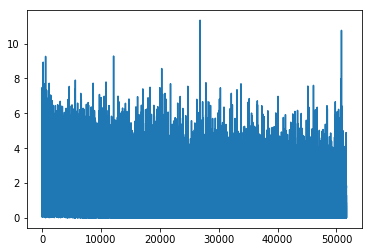

CPU times: user 31min 20s, sys: 5min 26s, total: 36min 47s
Wall time: 33min 33s


In [25]:
%time arya_train()
torch.save(resnet18.state_dict(), 'resnet18.pkl')

In [12]:
resnet18.load_state_dict(torch.load('resnet18.pkl'))
def classification_test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels,_ in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the ' + str(total) +' test images: %d %%' % (100 * correct / total))
    
classification_test(resnet18)

AssertionError: 
The NVIDIA driver on your system is too old (found version 6050).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org/binaries to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [27]:
def theon_sliding_window(image,aspect_ratio,size,slide_amount):
    # Begin
    windows = []
    labels = []
    threshold = 0
    for x in xrange(0,image.size[0],slide_amount):
        for y in xrange(0,image.size[1],slide_amount):
            box = [x,y,int(x+size*aspect_ratio),y+size]
            crop_img = image.crop(box).convert('RGB')
            crop_img = composed_transform(crop_img)
            images = Variable(crop_img)
            images = images.unsqueeze(0)
            if(use_gpu):
                images = images.cuda()
            output = resnet18(images)
            output = torch.nn.functional.softmax(output)
            prob,label = torch.topk(output.data,1)
#             print (prob[0][0])
#             print (label)
            if prob[0][0] > threshold and label[0][0] != 0:
                windows.append(box)
                labels.append(label)
    return windows,labels

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [28]:
def aegon_targaryen_non_maximum_supression(boxes,labels,threshold = 0.3):
    boxes = np.array(boxes)
    nms_boxes = []
    nms_labels = []
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
#     if boxes.dtype.kind == "i":
#         boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        nms_boxes.append(boxes[i])
        nms_labels.append(labels[i])
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
#     return boxes[pick].astype("int") , labels[pick]
    return nms_boxes , nms_labels

In [31]:
image = PIL.Image.open('/home/deepak/CS698O/Assignments/Assignment2/test/VOCdevkit/VOC2007/JPEGImages/000002.jpg')
windows,labels = theon_sliding_window(image,1,448,10)
print (windows,labels)

[[0, 170, 448, 618], [0, 180, 448, 628], [0, 190, 448, 638], [0, 200, 448, 648], [0, 210, 448, 658], [0, 230, 448, 678], [0, 240, 448, 688], [0, 280, 448, 728], [0, 320, 448, 768], [10, 210, 458, 658], [10, 250, 458, 698], [10, 350, 458, 798], [20, 190, 468, 638], [20, 220, 468, 668], [20, 230, 468, 678], [20, 260, 468, 708], [20, 270, 468, 718], [30, 230, 478, 678], [30, 270, 478, 718], [30, 320, 478, 768], [40, 200, 488, 648], [40, 240, 488, 688], [40, 270, 488, 718], [50, 190, 498, 638], [50, 240, 498, 688], [50, 250, 498, 698], [50, 270, 498, 718], [60, 240, 508, 688], [60, 250, 508, 698], [70, 240, 518, 688], [70, 260, 518, 708], [70, 270, 518, 718], [100, 250, 548, 698]] [
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[t

In [32]:
windows, labels = aegon_targaryen_non_maximum_supression(windows,labels,0.3)
print (windows,labels)

[array([ 10, 350, 458, 798])] [
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
]


Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [ ]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    correct = 0
    total = 0
    aspect_ratio = [1,0.75,1.33,0.5]
    size = [224,128,64]
    slide_amount = 10
    boxes = []
    labels = []
    for images, orig_labels, img_whole in test_loader:
        images = Variable(images)
        img_whole = Variable(img_whole)
        
        if(use_gpu):
            images = images.cuda()
            img_whole = img_whole.cuda()
        
        for i in range(len(aspect_ratio)):
            for j in range(len(size)):
                windows, labels = theon_sliding_window(img_whole,aspect_ratio(i),size(j),slide_amount)
                boxes.extend()
                labels.extend()
        boxes, labels = aegon_targaryen_non_maximum_supression(boxes,labels,0.3)
        
        
        

In [ ]:
%time daenerys_test(resnet18)

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [ ]:
print("The night has ended. Winter is finally over!")